# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [1]:
useColab=False
if useColab:
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=1, task = '35word')

Google Speech commands dataset version 1 already exists. Skipping download.
Converting test set WAVs to numpy files


0it [00:00, ?it/s]


Converting training set WAVs to numpy files


0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 1


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [4]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
51094
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [5]:
sr=16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
#handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

#use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

106

In [6]:
audios, classes = valGen.__getitem__(6)
classes

array([16, 20, 10, 33,  7, 32,  3, 12,  6,  9, 15, 17, 24, 22, 17, 13, 28,
       14,  4, 23,  4,  3, 24,  3, 16,  2,  4, 12, 11, 23, 15, 20,  7, 33,
        4, 14,  5, 25, 16, 17,  6, 11,  2, 23, 16,  2, 16, 22, 33,  8, 24,
        8,  5,  9,  2, 14, 33, 18, 24, 10, 35, 13,  1, 22])

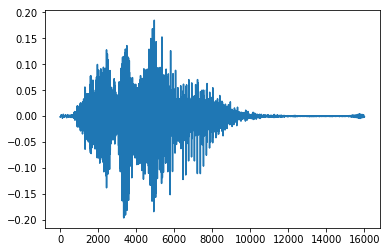

In [7]:
librosa.output.write_wav('file.wav', audios[5], sr, norm=False)
_= plt.plot(audios[5])

In [8]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 0
Non-trainable params: 1,091,664
_________________________________________________________________


In [9]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(64, 80, 125, 1)

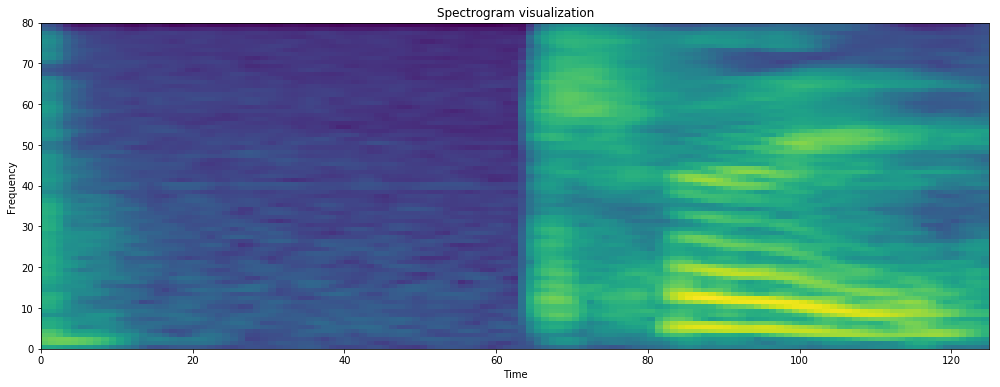

In [10]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[3,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

(array([3.0000e+00, 2.5800e+02, 1.6000e+01, 1.2000e+01, 5.0000e+00,
        7.0000e+00, 1.3000e+01, 6.0000e+00, 2.2000e+01, 3.8000e+01,
        4.0000e+01, 5.1000e+01, 4.8000e+01, 7.8000e+01, 7.3000e+01,
        3.2900e+02, 1.0100e+02, 1.7200e+02, 2.2600e+02, 2.6600e+02,
        2.6000e+02, 3.2000e+02, 3.3900e+02, 3.7500e+02, 5.2100e+02,
        8.0500e+02, 1.1360e+03, 5.1510e+03, 2.1090e+03, 1.8000e+03,
        2.3060e+03, 3.3300e+03, 5.6450e+03, 1.0063e+04, 1.5459e+04,
        2.0501e+04, 2.4102e+04, 2.7112e+04, 2.9855e+04, 2.9954e+04,
        2.8310e+04, 2.7433e+04, 2.6496e+04, 2.5299e+04, 2.4336e+04,
        2.2975e+04, 2.1515e+04, 2.0433e+04, 1.9341e+04, 1.9522e+04,
        1.9195e+04, 1.7788e+04, 1.6454e+04, 1.5540e+04, 1.4234e+04,
        1.3365e+04, 1.2195e+04, 1.1381e+04, 1.0566e+04, 9.6490e+03,
        9.0160e+03, 8.1000e+03, 7.7950e+03, 6.8760e+03, 6.4830e+03,
        5.6930e+03, 5.3730e+03, 4.8210e+03, 4.3150e+03, 3.8630e+03,
        3.2360e+03, 2.8050e+03, 2.5950e+03, 2.06

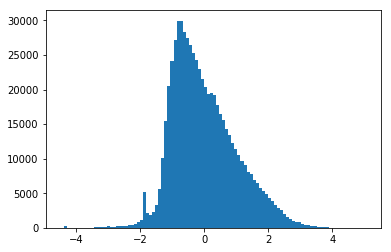

In [11]:
plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [12]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram

In [95]:
#self-attention LSTM
model = SpeechModels.AttConvLSTMSpeechModel(nCategs, samplingrate = sr, inputLength = iLen)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 16000)        0                                            
__________________________________________________________________________________________________
reshape_19 (Reshape)            (None, 1, 16000)     0           input_19[0][0]                   
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 125, 1)   1091664     reshape_19[0][0]                 
__________________________________________________________________________________________________
normalization2d_20 (Normalizati (None, 80, 125, 1)   0           mel_stft[0][0]                   
__________________________________________________________________________________________________
permute_19

In [96]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-ConvLSTMS.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results = model.fit_generator(trainGen, validation_data = valGen, epochs = 40, use_multiprocessing=True, workers=4,
                    callbacks=[earlystopper, checkpointer, lrate])

Epoch 1/40
Changing learning rate to 0.001


123/798 [===>..........................] - ETA: 9:05:01 - loss: 3.5836 - sparse_categorical_accuracy: 0.04 - ETA: 6:35:04 - loss: 3.5832 - sparse_categorical_accuracy: 0.03 - ETA: 5:39:56 - loss: 3.5828 - sparse_categorical_accuracy: 0.04 - ETA: 5:13:27 - loss: 3.5828 - sparse_categorical_accuracy: 0.04 - ETA: 4:58:08 - loss: 3.5830 - sparse_categorical_accuracy: 0.04 - ETA: 4:46:09 - loss: 3.5822 - sparse_categorical_accuracy: 0.05 - ETA: 4:38:22 - loss: 3.5820 - sparse_categorical_accuracy: 0.04 - ETA: 4:34:27 - loss: 3.5815 - sparse_categorical_accuracy: 0.04 - ETA: 4:29:18 - loss: 3.5814 - sparse_categorical_accuracy: 0.04 - ETA: 4:26:30 - loss: 3.5808 - sparse_categorical_accuracy: 0.04 - ETA: 4:23:06 - loss: 3.5806 - sparse_categorical_accuracy: 0.03 - ETA: 4:21:15 - loss: 3.5802 - sparse_categorical_accuracy: 0.03 - ETA: 4:18:44 - loss: 3.5801 - sparse_categorical_accuracy: 0.04 - ETA: 4:17:04 - loss: 3.5797 - sparse_categorical_accuracy: 0.04 - ETA: 4:14:53 - loss: 3.5795 - spa

247/798 [========>.....................] - ETA: 3:23:32 - loss: 3.4679 - sparse_categorical_accuracy: 0.03 - ETA: 3:23:13 - loss: 3.4673 - sparse_categorical_accuracy: 0.03 - ETA: 3:22:54 - loss: 3.4666 - sparse_categorical_accuracy: 0.03 - ETA: 3:22:34 - loss: 3.4660 - sparse_categorical_accuracy: 0.03 - ETA: 3:22:16 - loss: 3.4653 - sparse_categorical_accuracy: 0.03 - ETA: 3:22:01 - loss: 3.4650 - sparse_categorical_accuracy: 0.03 - ETA: 3:21:43 - loss: 3.4643 - sparse_categorical_accuracy: 0.03 - ETA: 3:21:20 - loss: 3.4636 - sparse_categorical_accuracy: 0.03 - ETA: 3:21:04 - loss: 3.4626 - sparse_categorical_accuracy: 0.03 - ETA: 3:20:41 - loss: 3.4621 - sparse_categorical_accuracy: 0.03 - ETA: 3:20:19 - loss: 3.4614 - sparse_categorical_accuracy: 0.03 - ETA: 3:20:04 - loss: 3.4604 - sparse_categorical_accuracy: 0.03 - ETA: 3:19:38 - loss: 3.4602 - sparse_categorical_accuracy: 0.03 - ETA: 3:19:22 - loss: 3.4596 - sparse_categorical_accuracy: 0.03 - ETA: 3:19:05 - loss: 3.4590 - spa

371/798 [============>.................] - ETA: 2:44:53 - loss: 3.3902 - sparse_categorical_accuracy: 0.05 - ETA: 2:44:35 - loss: 3.3895 - sparse_categorical_accuracy: 0.05 - ETA: 2:44:18 - loss: 3.3885 - sparse_categorical_accuracy: 0.05 - ETA: 2:43:58 - loss: 3.3876 - sparse_categorical_accuracy: 0.05 - ETA: 2:43:39 - loss: 3.3871 - sparse_categorical_accuracy: 0.05 - ETA: 2:43:22 - loss: 3.3863 - sparse_categorical_accuracy: 0.05 - ETA: 2:43:04 - loss: 3.3854 - sparse_categorical_accuracy: 0.05 - ETA: 2:42:47 - loss: 3.3848 - sparse_categorical_accuracy: 0.05 - ETA: 2:42:28 - loss: 3.3839 - sparse_categorical_accuracy: 0.05 - ETA: 2:42:10 - loss: 3.3830 - sparse_categorical_accuracy: 0.05 - ETA: 2:41:54 - loss: 3.3826 - sparse_categorical_accuracy: 0.05 - ETA: 2:41:38 - loss: 3.3819 - sparse_categorical_accuracy: 0.05 - ETA: 2:41:20 - loss: 3.3809 - sparse_categorical_accuracy: 0.05 - ETA: 2:41:02 - loss: 3.3800 - sparse_categorical_accuracy: 0.05 - ETA: 2:40:42 - loss: 3.3791 - spa

495/798 [=================>............] - ETA: 2:07:24 - loss: 3.2905 - sparse_categorical_accuracy: 0.07 - ETA: 2:07:05 - loss: 3.2893 - sparse_categorical_accuracy: 0.07 - ETA: 2:06:46 - loss: 3.2887 - sparse_categorical_accuracy: 0.07 - ETA: 2:06:29 - loss: 3.2879 - sparse_categorical_accuracy: 0.07 - ETA: 2:06:11 - loss: 3.2875 - sparse_categorical_accuracy: 0.07 - ETA: 2:05:54 - loss: 3.2870 - sparse_categorical_accuracy: 0.07 - ETA: 2:05:36 - loss: 3.2862 - sparse_categorical_accuracy: 0.07 - ETA: 2:05:18 - loss: 3.2853 - sparse_categorical_accuracy: 0.07 - ETA: 2:05:00 - loss: 3.2843 - sparse_categorical_accuracy: 0.07 - ETA: 2:04:43 - loss: 3.2842 - sparse_categorical_accuracy: 0.07 - ETA: 2:04:25 - loss: 3.2835 - sparse_categorical_accuracy: 0.07 - ETA: 2:04:06 - loss: 3.2826 - sparse_categorical_accuracy: 0.07 - ETA: 2:03:48 - loss: 3.2817 - sparse_categorical_accuracy: 0.07 - ETA: 2:03:30 - loss: 3.2808 - sparse_categorical_accuracy: 0.07 - ETA: 2:03:11 - loss: 3.2799 - spa

620/798 [======================>.......] - ETA: 1:30:03 - loss: 3.2065 - sparse_categorical_accuracy: 0.08 - ETA: 1:29:46 - loss: 3.2059 - sparse_categorical_accuracy: 0.08 - ETA: 1:29:27 - loss: 3.2051 - sparse_categorical_accuracy: 0.08 - ETA: 1:29:10 - loss: 3.2045 - sparse_categorical_accuracy: 0.08 - ETA: 1:28:51 - loss: 3.2038 - sparse_categorical_accuracy: 0.08 - ETA: 1:28:33 - loss: 3.2036 - sparse_categorical_accuracy: 0.08 - ETA: 1:28:15 - loss: 3.2031 - sparse_categorical_accuracy: 0.08 - ETA: 1:27:57 - loss: 3.2024 - sparse_categorical_accuracy: 0.08 - ETA: 1:27:39 - loss: 3.2018 - sparse_categorical_accuracy: 0.08 - ETA: 1:27:21 - loss: 3.2012 - sparse_categorical_accuracy: 0.08 - ETA: 1:27:03 - loss: 3.2009 - sparse_categorical_accuracy: 0.08 - ETA: 1:26:45 - loss: 3.2004 - sparse_categorical_accuracy: 0.08 - ETA: 1:26:27 - loss: 3.1997 - sparse_categorical_accuracy: 0.08 - ETA: 1:26:09 - loss: 3.1990 - sparse_categorical_accuracy: 0.08 - ETA: 1:25:51 - loss: 3.1985 - spa

748/798 [===========================>..] - ETA: 52:46 - loss: 3.1331 - sparse_categorical_accuracy: 0.10 - ETA: 52:29 - loss: 3.1324 - sparse_categorical_accuracy: 0.10 - ETA: 52:11 - loss: 3.1317 - sparse_categorical_accuracy: 0.10 - ETA: 51:53 - loss: 3.1310 - sparse_categorical_accuracy: 0.10 - ETA: 51:35 - loss: 3.1301 - sparse_categorical_accuracy: 0.10 - ETA: 51:17 - loss: 3.1299 - sparse_categorical_accuracy: 0.10 - ETA: 50:59 - loss: 3.1295 - sparse_categorical_accuracy: 0.10 - ETA: 50:41 - loss: 3.1292 - sparse_categorical_accuracy: 0.10 - ETA: 50:23 - loss: 3.1286 - sparse_categorical_accuracy: 0.10 - ETA: 50:05 - loss: 3.1282 - sparse_categorical_accuracy: 0.10 - ETA: 49:47 - loss: 3.1278 - sparse_categorical_accuracy: 0.10 - ETA: 49:29 - loss: 3.1277 - sparse_categorical_accuracy: 0.10 - ETA: 49:11 - loss: 3.1270 - sparse_categorical_accuracy: 0.10 - ETA: 48:53 - loss: 3.1263 - sparse_categorical_accuracy: 0.10 - ETA: 48:35 - loss: 3.1257 - sparse_categorical_accuracy: 0.10

798/798 [==============================] - ETA: 14:35 - loss: 3.0647 - sparse_categorical_accuracy: 0.11 - ETA: 14:17 - loss: 3.0639 - sparse_categorical_accuracy: 0.11 - ETA: 13:59 - loss: 3.0634 - sparse_categorical_accuracy: 0.11 - ETA: 13:41 - loss: 3.0627 - sparse_categorical_accuracy: 0.11 - ETA: 13:23 - loss: 3.0622 - sparse_categorical_accuracy: 0.11 - ETA: 13:05 - loss: 3.0618 - sparse_categorical_accuracy: 0.11 - ETA: 12:48 - loss: 3.0614 - sparse_categorical_accuracy: 0.11 - ETA: 12:30 - loss: 3.0608 - sparse_categorical_accuracy: 0.11 - ETA: 12:12 - loss: 3.0600 - sparse_categorical_accuracy: 0.11 - ETA: 11:54 - loss: 3.0596 - sparse_categorical_accuracy: 0.11 - ETA: 11:36 - loss: 3.0587 - sparse_categorical_accuracy: 0.11 - ETA: 11:18 - loss: 3.0582 - sparse_categorical_accuracy: 0.11 - ETA: 11:00 - loss: 3.0577 - sparse_categorical_accuracy: 0.11 - ETA: 10:43 - loss: 3.0571 - sparse_categorical_accuracy: 0.11 - ETA: 10:25 - loss: 3.0567 - sparse_categorical_accuracy: 0.11

124/798 [===>..........................] - ETA: 4:08:18 - loss: 2.7789 - sparse_categorical_accuracy: 0.14 - ETA: 3:57:42 - loss: 2.7188 - sparse_categorical_accuracy: 0.17 - ETA: 3:57:20 - loss: 2.6545 - sparse_categorical_accuracy: 0.17 - ETA: 3:55:52 - loss: 2.6514 - sparse_categorical_accuracy: 0.17 - ETA: 3:54:38 - loss: 2.6406 - sparse_categorical_accuracy: 0.18 - ETA: 3:53:45 - loss: 2.6355 - sparse_categorical_accuracy: 0.19 - ETA: 3:53:46 - loss: 2.6472 - sparse_categorical_accuracy: 0.18 - ETA: 3:53:58 - loss: 2.6563 - sparse_categorical_accuracy: 0.17 - ETA: 3:53:16 - loss: 2.6661 - sparse_categorical_accuracy: 0.17 - ETA: 3:53:50 - loss: 2.6593 - sparse_categorical_accuracy: 0.17 - ETA: 3:53:56 - loss: 2.6658 - sparse_categorical_accuracy: 0.18 - ETA: 3:53:12 - loss: 2.6703 - sparse_categorical_accuracy: 0.17 - ETA: 3:52:22 - loss: 2.6726 - sparse_categorical_accuracy: 0.18 - ETA: 3:52:46 - loss: 2.6685 - sparse_categorical_accuracy: 0.18 - ETA: 3:53:25 - loss: 2.6612 - spa

248/798 [========>.....................] - ETA: 3:18:22 - loss: 2.5137 - sparse_categorical_accuracy: 0.24 - ETA: 3:18:02 - loss: 2.5100 - sparse_categorical_accuracy: 0.24 - ETA: 3:17:43 - loss: 2.5094 - sparse_categorical_accuracy: 0.24 - ETA: 3:17:22 - loss: 2.5096 - sparse_categorical_accuracy: 0.24 - ETA: 3:17:02 - loss: 2.5094 - sparse_categorical_accuracy: 0.25 - ETA: 3:16:42 - loss: 2.5084 - sparse_categorical_accuracy: 0.25 - ETA: 3:16:24 - loss: 2.5075 - sparse_categorical_accuracy: 0.25 - ETA: 3:16:07 - loss: 2.5064 - sparse_categorical_accuracy: 0.25 - ETA: 3:15:49 - loss: 2.5048 - sparse_categorical_accuracy: 0.25 - ETA: 3:15:31 - loss: 2.5035 - sparse_categorical_accuracy: 0.25 - ETA: 3:15:11 - loss: 2.5021 - sparse_categorical_accuracy: 0.25 - ETA: 3:14:51 - loss: 2.5016 - sparse_categorical_accuracy: 0.25 - ETA: 3:14:34 - loss: 2.5012 - sparse_categorical_accuracy: 0.25 - ETA: 3:14:13 - loss: 2.5007 - sparse_categorical_accuracy: 0.25 - ETA: 3:13:54 - loss: 2.4997 - spa

372/798 [============>.................] - ETA: 2:40:29 - loss: 2.4334 - sparse_categorical_accuracy: 0.26 - ETA: 2:40:11 - loss: 2.4335 - sparse_categorical_accuracy: 0.26 - ETA: 2:39:53 - loss: 2.4333 - sparse_categorical_accuracy: 0.26 - ETA: 2:39:35 - loss: 2.4330 - sparse_categorical_accuracy: 0.26 - ETA: 2:39:17 - loss: 2.4331 - sparse_categorical_accuracy: 0.26 - ETA: 2:38:59 - loss: 2.4328 - sparse_categorical_accuracy: 0.26 - ETA: 2:38:42 - loss: 2.4318 - sparse_categorical_accuracy: 0.26 - ETA: 2:38:23 - loss: 2.4315 - sparse_categorical_accuracy: 0.26 - ETA: 2:38:06 - loss: 2.4310 - sparse_categorical_accuracy: 0.26 - ETA: 2:37:48 - loss: 2.4307 - sparse_categorical_accuracy: 0.26 - ETA: 2:37:30 - loss: 2.4302 - sparse_categorical_accuracy: 0.26 - ETA: 2:37:13 - loss: 2.4301 - sparse_categorical_accuracy: 0.26 - ETA: 2:36:55 - loss: 2.4298 - sparse_categorical_accuracy: 0.26 - ETA: 2:36:38 - loss: 2.4288 - sparse_categorical_accuracy: 0.26 - ETA: 2:36:19 - loss: 2.4274 - spa

496/798 [=================>............] - ETA: 2:03:52 - loss: 2.3784 - sparse_categorical_accuracy: 0.28 - ETA: 2:03:34 - loss: 2.3777 - sparse_categorical_accuracy: 0.28 - ETA: 2:03:16 - loss: 2.3768 - sparse_categorical_accuracy: 0.28 - ETA: 2:02:59 - loss: 2.3766 - sparse_categorical_accuracy: 0.28 - ETA: 2:02:42 - loss: 2.3761 - sparse_categorical_accuracy: 0.28 - ETA: 2:02:24 - loss: 2.3761 - sparse_categorical_accuracy: 0.28 - ETA: 2:02:06 - loss: 2.3751 - sparse_categorical_accuracy: 0.28 - ETA: 2:01:49 - loss: 2.3751 - sparse_categorical_accuracy: 0.28 - ETA: 2:01:31 - loss: 2.3750 - sparse_categorical_accuracy: 0.28 - ETA: 2:01:13 - loss: 2.3743 - sparse_categorical_accuracy: 0.28 - ETA: 2:00:55 - loss: 2.3750 - sparse_categorical_accuracy: 0.28 - ETA: 2:00:37 - loss: 2.3747 - sparse_categorical_accuracy: 0.28 - ETA: 2:00:19 - loss: 2.3745 - sparse_categorical_accuracy: 0.28 - ETA: 2:00:02 - loss: 2.3741 - sparse_categorical_accuracy: 0.28 - ETA: 1:59:44 - loss: 2.3736 - spa

621/798 [======================>.......] - ETA: 1:27:44 - loss: 2.3306 - sparse_categorical_accuracy: 0.29 - ETA: 1:27:27 - loss: 2.3306 - sparse_categorical_accuracy: 0.29 - ETA: 1:27:09 - loss: 2.3301 - sparse_categorical_accuracy: 0.29 - ETA: 1:26:52 - loss: 2.3308 - sparse_categorical_accuracy: 0.29 - ETA: 1:26:35 - loss: 2.3307 - sparse_categorical_accuracy: 0.29 - ETA: 1:26:17 - loss: 2.3303 - sparse_categorical_accuracy: 0.29 - ETA: 1:26:00 - loss: 2.3296 - sparse_categorical_accuracy: 0.29 - ETA: 1:25:43 - loss: 2.3291 - sparse_categorical_accuracy: 0.29 - ETA: 1:25:25 - loss: 2.3280 - sparse_categorical_accuracy: 0.29 - ETA: 1:25:07 - loss: 2.3277 - sparse_categorical_accuracy: 0.29 - ETA: 1:24:49 - loss: 2.3270 - sparse_categorical_accuracy: 0.29 - ETA: 1:24:32 - loss: 2.3270 - sparse_categorical_accuracy: 0.29 - ETA: 1:24:15 - loss: 2.3262 - sparse_categorical_accuracy: 0.29 - ETA: 1:23:57 - loss: 2.3257 - sparse_categorical_accuracy: 0.29 - ETA: 1:23:39 - loss: 2.3250 - spa

749/798 [===========================>..] - ETA: 51:26 - loss: 2.2890 - sparse_categorical_accuracy: 0.31 - ETA: 51:09 - loss: 2.2888 - sparse_categorical_accuracy: 0.31 - ETA: 50:51 - loss: 2.2882 - sparse_categorical_accuracy: 0.31 - ETA: 50:34 - loss: 2.2876 - sparse_categorical_accuracy: 0.31 - ETA: 50:16 - loss: 2.2874 - sparse_categorical_accuracy: 0.31 - ETA: 49:58 - loss: 2.2874 - sparse_categorical_accuracy: 0.31 - ETA: 49:41 - loss: 2.2871 - sparse_categorical_accuracy: 0.31 - ETA: 49:23 - loss: 2.2868 - sparse_categorical_accuracy: 0.31 - ETA: 49:06 - loss: 2.2870 - sparse_categorical_accuracy: 0.31 - ETA: 48:48 - loss: 2.2866 - sparse_categorical_accuracy: 0.31 - ETA: 48:30 - loss: 2.2863 - sparse_categorical_accuracy: 0.31 - ETA: 48:13 - loss: 2.2861 - sparse_categorical_accuracy: 0.31 - ETA: 47:55 - loss: 2.2857 - sparse_categorical_accuracy: 0.31 - ETA: 47:37 - loss: 2.2852 - sparse_categorical_accuracy: 0.31 - ETA: 47:20 - loss: 2.2851 - sparse_categorical_accuracy: 0.31

798/798 [==============================] - ETA: 14:01 - loss: 2.2457 - sparse_categorical_accuracy: 0.32 - ETA: 13:43 - loss: 2.2457 - sparse_categorical_accuracy: 0.32 - ETA: 13:26 - loss: 2.2454 - sparse_categorical_accuracy: 0.32 - ETA: 13:08 - loss: 2.2451 - sparse_categorical_accuracy: 0.32 - ETA: 12:51 - loss: 2.2453 - sparse_categorical_accuracy: 0.32 - ETA: 12:33 - loss: 2.2452 - sparse_categorical_accuracy: 0.32 - ETA: 12:16 - loss: 2.2447 - sparse_categorical_accuracy: 0.32 - ETA: 11:58 - loss: 2.2444 - sparse_categorical_accuracy: 0.32 - ETA: 11:41 - loss: 2.2443 - sparse_categorical_accuracy: 0.32 - ETA: 11:23 - loss: 2.2439 - sparse_categorical_accuracy: 0.32 - ETA: 11:06 - loss: 2.2436 - sparse_categorical_accuracy: 0.32 - ETA: 10:48 - loss: 2.2432 - sparse_categorical_accuracy: 0.32 - ETA: 10:31 - loss: 2.2430 - sparse_categorical_accuracy: 0.32 - ETA: 10:13 - loss: 2.2429 - sparse_categorical_accuracy: 0.32 - ETA: 9:56 - loss: 2.2424 - sparse_categorical_accuracy: 0.328

124/798 [===>..........................] - ETA: 4:24:43 - loss: 2.1853 - sparse_categorical_accuracy: 0.35 - ETA: 4:16:53 - loss: 2.0361 - sparse_categorical_accuracy: 0.39 - ETA: 4:08:49 - loss: 2.0362 - sparse_categorical_accuracy: 0.41 - ETA: 4:08:09 - loss: 1.9897 - sparse_categorical_accuracy: 0.42 - ETA: 4:07:07 - loss: 2.0276 - sparse_categorical_accuracy: 0.41 - ETA: 4:06:20 - loss: 2.0068 - sparse_categorical_accuracy: 0.41 - ETA: 4:03:28 - loss: 2.0164 - sparse_categorical_accuracy: 0.41 - ETA: 4:01:21 - loss: 1.9960 - sparse_categorical_accuracy: 0.40 - ETA: 4:00:12 - loss: 1.9762 - sparse_categorical_accuracy: 0.41 - ETA: 3:59:46 - loss: 1.9584 - sparse_categorical_accuracy: 0.42 - ETA: 3:59:14 - loss: 1.9728 - sparse_categorical_accuracy: 0.41 - ETA: 3:57:46 - loss: 1.9739 - sparse_categorical_accuracy: 0.41 - ETA: 3:56:24 - loss: 1.9537 - sparse_categorical_accuracy: 0.42 - ETA: 3:55:26 - loss: 1.9547 - sparse_categorical_accuracy: 0.42 - ETA: 3:55:08 - loss: 1.9405 - spa

248/798 [========>.....................] - ETA: 3:17:22 - loss: 1.9376 - sparse_categorical_accuracy: 0.42 - ETA: 3:17:04 - loss: 1.9371 - sparse_categorical_accuracy: 0.42 - ETA: 3:16:49 - loss: 1.9384 - sparse_categorical_accuracy: 0.42 - ETA: 3:16:29 - loss: 1.9394 - sparse_categorical_accuracy: 0.42 - ETA: 3:16:13 - loss: 1.9395 - sparse_categorical_accuracy: 0.42 - ETA: 3:15:55 - loss: 1.9410 - sparse_categorical_accuracy: 0.42 - ETA: 3:15:36 - loss: 1.9401 - sparse_categorical_accuracy: 0.42 - ETA: 3:15:21 - loss: 1.9392 - sparse_categorical_accuracy: 0.42 - ETA: 3:15:08 - loss: 1.9397 - sparse_categorical_accuracy: 0.42 - ETA: 3:14:49 - loss: 1.9397 - sparse_categorical_accuracy: 0.42 - ETA: 3:14:34 - loss: 1.9390 - sparse_categorical_accuracy: 0.42 - ETA: 3:14:22 - loss: 1.9371 - sparse_categorical_accuracy: 0.42 - ETA: 3:14:00 - loss: 1.9347 - sparse_categorical_accuracy: 0.42 - ETA: 3:13:41 - loss: 1.9342 - sparse_categorical_accuracy: 0.42 - ETA: 3:13:24 - loss: 1.9316 - spa

372/798 [============>.................] - ETA: 2:41:11 - loss: 1.8979 - sparse_categorical_accuracy: 0.44 - ETA: 2:40:53 - loss: 1.8972 - sparse_categorical_accuracy: 0.44 - ETA: 2:40:35 - loss: 1.8966 - sparse_categorical_accuracy: 0.44 - ETA: 2:40:18 - loss: 1.8968 - sparse_categorical_accuracy: 0.43 - ETA: 2:40:06 - loss: 1.8957 - sparse_categorical_accuracy: 0.44 - ETA: 2:39:49 - loss: 1.8944 - sparse_categorical_accuracy: 0.44 - ETA: 2:39:32 - loss: 1.8949 - sparse_categorical_accuracy: 0.44 - ETA: 2:39:16 - loss: 1.8947 - sparse_categorical_accuracy: 0.44 - ETA: 2:39:00 - loss: 1.8940 - sparse_categorical_accuracy: 0.44 - ETA: 2:38:44 - loss: 1.8948 - sparse_categorical_accuracy: 0.44 - ETA: 2:38:28 - loss: 1.8937 - sparse_categorical_accuracy: 0.44 - ETA: 2:38:10 - loss: 1.8937 - sparse_categorical_accuracy: 0.44 - ETA: 2:37:53 - loss: 1.8936 - sparse_categorical_accuracy: 0.44 - ETA: 2:37:35 - loss: 1.8947 - sparse_categorical_accuracy: 0.44 - ETA: 2:37:17 - loss: 1.8944 - spa

496/798 [=================>............] - ETA: 2:05:16 - loss: 1.8681 - sparse_categorical_accuracy: 0.45 - ETA: 2:04:58 - loss: 1.8688 - sparse_categorical_accuracy: 0.45 - ETA: 2:04:41 - loss: 1.8684 - sparse_categorical_accuracy: 0.45 - ETA: 2:04:24 - loss: 1.8683 - sparse_categorical_accuracy: 0.45 - ETA: 2:04:06 - loss: 1.8690 - sparse_categorical_accuracy: 0.45 - ETA: 2:03:49 - loss: 1.8680 - sparse_categorical_accuracy: 0.45 - ETA: 2:03:31 - loss: 1.8690 - sparse_categorical_accuracy: 0.44 - ETA: 2:03:13 - loss: 1.8693 - sparse_categorical_accuracy: 0.45 - ETA: 2:02:58 - loss: 1.8694 - sparse_categorical_accuracy: 0.45 - ETA: 2:02:40 - loss: 1.8692 - sparse_categorical_accuracy: 0.45 - ETA: 2:02:22 - loss: 1.8690 - sparse_categorical_accuracy: 0.45 - ETA: 2:02:05 - loss: 1.8682 - sparse_categorical_accuracy: 0.45 - ETA: 2:01:47 - loss: 1.8676 - sparse_categorical_accuracy: 0.45 - ETA: 2:01:30 - loss: 1.8673 - sparse_categorical_accuracy: 0.45 - ETA: 2:01:12 - loss: 1.8669 - spa

621/798 [======================>.......] - ETA: 1:28:44 - loss: 1.8429 - sparse_categorical_accuracy: 0.45 - ETA: 1:28:26 - loss: 1.8426 - sparse_categorical_accuracy: 0.45 - ETA: 1:28:09 - loss: 1.8421 - sparse_categorical_accuracy: 0.46 - ETA: 1:27:51 - loss: 1.8415 - sparse_categorical_accuracy: 0.46 - ETA: 1:27:33 - loss: 1.8412 - sparse_categorical_accuracy: 0.46 - ETA: 1:27:15 - loss: 1.8404 - sparse_categorical_accuracy: 0.46 - ETA: 1:26:57 - loss: 1.8399 - sparse_categorical_accuracy: 0.46 - ETA: 1:26:40 - loss: 1.8397 - sparse_categorical_accuracy: 0.46 - ETA: 1:26:22 - loss: 1.8386 - sparse_categorical_accuracy: 0.46 - ETA: 1:26:04 - loss: 1.8382 - sparse_categorical_accuracy: 0.46 - ETA: 1:25:47 - loss: 1.8378 - sparse_categorical_accuracy: 0.46 - ETA: 1:25:29 - loss: 1.8371 - sparse_categorical_accuracy: 0.46 - ETA: 1:25:11 - loss: 1.8368 - sparse_categorical_accuracy: 0.46 - ETA: 1:24:53 - loss: 1.8358 - sparse_categorical_accuracy: 0.46 - ETA: 1:24:35 - loss: 1.8352 - spa

749/798 [===========================>..] - ETA: 51:52 - loss: 1.8112 - sparse_categorical_accuracy: 0.46 - ETA: 51:35 - loss: 1.8112 - sparse_categorical_accuracy: 0.46 - ETA: 51:17 - loss: 1.8107 - sparse_categorical_accuracy: 0.47 - ETA: 50:59 - loss: 1.8105 - sparse_categorical_accuracy: 0.47 - ETA: 50:41 - loss: 1.8108 - sparse_categorical_accuracy: 0.47 - ETA: 50:24 - loss: 1.8104 - sparse_categorical_accuracy: 0.47 - ETA: 50:06 - loss: 1.8101 - sparse_categorical_accuracy: 0.47 - ETA: 49:48 - loss: 1.8097 - sparse_categorical_accuracy: 0.47 - ETA: 49:30 - loss: 1.8093 - sparse_categorical_accuracy: 0.47 - ETA: 49:13 - loss: 1.8092 - sparse_categorical_accuracy: 0.47 - ETA: 48:55 - loss: 1.8084 - sparse_categorical_accuracy: 0.47 - ETA: 48:37 - loss: 1.8081 - sparse_categorical_accuracy: 0.47 - ETA: 48:20 - loss: 1.8078 - sparse_categorical_accuracy: 0.47 - ETA: 48:02 - loss: 1.8072 - sparse_categorical_accuracy: 0.47 - ETA: 47:44 - loss: 1.8071 - sparse_categorical_accuracy: 0.47

798/798 [==============================] - ETA: 14:08 - loss: 1.7876 - sparse_categorical_accuracy: 0.47 - ETA: 13:51 - loss: 1.7874 - sparse_categorical_accuracy: 0.47 - ETA: 13:33 - loss: 1.7875 - sparse_categorical_accuracy: 0.47 - ETA: 13:15 - loss: 1.7872 - sparse_categorical_accuracy: 0.47 - ETA: 12:58 - loss: 1.7874 - sparse_categorical_accuracy: 0.47 - ETA: 12:40 - loss: 1.7873 - sparse_categorical_accuracy: 0.47 - ETA: 12:23 - loss: 1.7872 - sparse_categorical_accuracy: 0.47 - ETA: 12:05 - loss: 1.7868 - sparse_categorical_accuracy: 0.47 - ETA: 11:47 - loss: 1.7866 - sparse_categorical_accuracy: 0.47 - ETA: 11:30 - loss: 1.7863 - sparse_categorical_accuracy: 0.47 - ETA: 11:12 - loss: 1.7860 - sparse_categorical_accuracy: 0.47 - ETA: 10:54 - loss: 1.7858 - sparse_categorical_accuracy: 0.47 - ETA: 10:36 - loss: 1.7856 - sparse_categorical_accuracy: 0.47 - ETA: 10:19 - loss: 1.7855 - sparse_categorical_accuracy: 0.47 - ETA: 10:01 - loss: 1.7851 - sparse_categorical_accuracy: 0.47

124/798 [===>..........................] - ETA: 4:15:00 - loss: 1.8115 - sparse_categorical_accuracy: 0.42 - ETA: 4:19:39 - loss: 1.7350 - sparse_categorical_accuracy: 0.45 - ETA: 4:14:37 - loss: 1.7548 - sparse_categorical_accuracy: 0.45 - ETA: 4:08:48 - loss: 1.7174 - sparse_categorical_accuracy: 0.48 - ETA: 4:05:24 - loss: 1.6812 - sparse_categorical_accuracy: 0.48 - ETA: 4:02:36 - loss: 1.5971 - sparse_categorical_accuracy: 0.51 - ETA: 4:02:20 - loss: 1.6268 - sparse_categorical_accuracy: 0.51 - ETA: 4:01:42 - loss: 1.6064 - sparse_categorical_accuracy: 0.51 - ETA: 4:00:04 - loss: 1.6270 - sparse_categorical_accuracy: 0.50 - ETA: 3:58:58 - loss: 1.6187 - sparse_categorical_accuracy: 0.50 - ETA: 3:58:29 - loss: 1.5941 - sparse_categorical_accuracy: 0.51 - ETA: 3:57:38 - loss: 1.5937 - sparse_categorical_accuracy: 0.52 - ETA: 3:57:34 - loss: 1.5877 - sparse_categorical_accuracy: 0.52 - ETA: 3:56:42 - loss: 1.6066 - sparse_categorical_accuracy: 0.52 - ETA: 3:55:45 - loss: 1.6082 - spa

248/798 [========>.....................] - ETA: 3:20:25 - loss: 1.6026 - sparse_categorical_accuracy: 0.52 - ETA: 3:20:06 - loss: 1.6034 - sparse_categorical_accuracy: 0.52 - ETA: 3:19:48 - loss: 1.6027 - sparse_categorical_accuracy: 0.52 - ETA: 3:19:27 - loss: 1.6020 - sparse_categorical_accuracy: 0.52 - ETA: 3:19:10 - loss: 1.6038 - sparse_categorical_accuracy: 0.52 - ETA: 3:18:51 - loss: 1.6024 - sparse_categorical_accuracy: 0.52 - ETA: 3:18:34 - loss: 1.6018 - sparse_categorical_accuracy: 0.52 - ETA: 3:18:17 - loss: 1.6027 - sparse_categorical_accuracy: 0.52 - ETA: 3:17:56 - loss: 1.6015 - sparse_categorical_accuracy: 0.52 - ETA: 3:17:36 - loss: 1.6003 - sparse_categorical_accuracy: 0.52 - ETA: 3:17:20 - loss: 1.6022 - sparse_categorical_accuracy: 0.52 - ETA: 3:16:59 - loss: 1.6020 - sparse_categorical_accuracy: 0.52 - ETA: 3:16:39 - loss: 1.6015 - sparse_categorical_accuracy: 0.52 - ETA: 3:16:22 - loss: 1.5997 - sparse_categorical_accuracy: 0.52 - ETA: 3:16:05 - loss: 1.5984 - spa

372/798 [============>.................] - ETA: 2:42:48 - loss: 1.5697 - sparse_categorical_accuracy: 0.53 - ETA: 2:42:32 - loss: 1.5690 - sparse_categorical_accuracy: 0.53 - ETA: 2:42:14 - loss: 1.5690 - sparse_categorical_accuracy: 0.53 - ETA: 2:41:55 - loss: 1.5686 - sparse_categorical_accuracy: 0.53 - ETA: 2:41:36 - loss: 1.5679 - sparse_categorical_accuracy: 0.53 - ETA: 2:41:17 - loss: 1.5677 - sparse_categorical_accuracy: 0.53 - ETA: 2:40:59 - loss: 1.5677 - sparse_categorical_accuracy: 0.53 - ETA: 2:40:41 - loss: 1.5671 - sparse_categorical_accuracy: 0.53 - ETA: 2:40:22 - loss: 1.5664 - sparse_categorical_accuracy: 0.53 - ETA: 2:40:04 - loss: 1.5649 - sparse_categorical_accuracy: 0.53 - ETA: 2:39:48 - loss: 1.5643 - sparse_categorical_accuracy: 0.53 - ETA: 2:39:30 - loss: 1.5647 - sparse_categorical_accuracy: 0.53 - ETA: 2:39:12 - loss: 1.5645 - sparse_categorical_accuracy: 0.53 - ETA: 2:38:55 - loss: 1.5636 - sparse_categorical_accuracy: 0.53 - ETA: 2:38:36 - loss: 1.5638 - spa

496/798 [=================>............] - ETA: 2:05:52 - loss: 1.5557 - sparse_categorical_accuracy: 0.54 - ETA: 2:05:34 - loss: 1.5552 - sparse_categorical_accuracy: 0.54 - ETA: 2:05:16 - loss: 1.5549 - sparse_categorical_accuracy: 0.54 - ETA: 2:04:59 - loss: 1.5555 - sparse_categorical_accuracy: 0.54 - ETA: 2:04:41 - loss: 1.5556 - sparse_categorical_accuracy: 0.54 - ETA: 2:04:24 - loss: 1.5555 - sparse_categorical_accuracy: 0.54 - ETA: 2:04:06 - loss: 1.5548 - sparse_categorical_accuracy: 0.54 - ETA: 2:03:50 - loss: 1.5541 - sparse_categorical_accuracy: 0.54 - ETA: 2:03:32 - loss: 1.5539 - sparse_categorical_accuracy: 0.54 - ETA: 2:03:14 - loss: 1.5532 - sparse_categorical_accuracy: 0.54 - ETA: 2:02:56 - loss: 1.5537 - sparse_categorical_accuracy: 0.54 - ETA: 2:02:38 - loss: 1.5549 - sparse_categorical_accuracy: 0.54 - ETA: 2:02:21 - loss: 1.5545 - sparse_categorical_accuracy: 0.54 - ETA: 2:02:03 - loss: 1.5543 - sparse_categorical_accuracy: 0.54 - ETA: 2:01:45 - loss: 1.5553 - spa

621/798 [======================>.......] - ETA: 1:29:05 - loss: 1.5410 - sparse_categorical_accuracy: 0.54 - ETA: 1:28:47 - loss: 1.5409 - sparse_categorical_accuracy: 0.54 - ETA: 1:28:29 - loss: 1.5413 - sparse_categorical_accuracy: 0.54 - ETA: 1:28:11 - loss: 1.5411 - sparse_categorical_accuracy: 0.54 - ETA: 1:27:54 - loss: 1.5409 - sparse_categorical_accuracy: 0.54 - ETA: 1:27:36 - loss: 1.5408 - sparse_categorical_accuracy: 0.54 - ETA: 1:27:18 - loss: 1.5409 - sparse_categorical_accuracy: 0.54 - ETA: 1:27:00 - loss: 1.5415 - sparse_categorical_accuracy: 0.54 - ETA: 1:26:43 - loss: 1.5410 - sparse_categorical_accuracy: 0.54 - ETA: 1:26:25 - loss: 1.5409 - sparse_categorical_accuracy: 0.54 - ETA: 1:26:08 - loss: 1.5411 - sparse_categorical_accuracy: 0.54 - ETA: 1:25:50 - loss: 1.5403 - sparse_categorical_accuracy: 0.54 - ETA: 1:25:32 - loss: 1.5405 - sparse_categorical_accuracy: 0.54 - ETA: 1:25:14 - loss: 1.5405 - sparse_categorical_accuracy: 0.54 - ETA: 1:24:57 - loss: 1.5407 - spa

749/798 [===========================>..] - ETA: 52:07 - loss: 1.5311 - sparse_categorical_accuracy: 0.54 - ETA: 51:49 - loss: 1.5303 - sparse_categorical_accuracy: 0.54 - ETA: 51:31 - loss: 1.5299 - sparse_categorical_accuracy: 0.54 - ETA: 51:13 - loss: 1.5295 - sparse_categorical_accuracy: 0.54 - ETA: 50:56 - loss: 1.5291 - sparse_categorical_accuracy: 0.54 - ETA: 50:38 - loss: 1.5295 - sparse_categorical_accuracy: 0.54 - ETA: 50:20 - loss: 1.5296 - sparse_categorical_accuracy: 0.54 - ETA: 50:02 - loss: 1.5297 - sparse_categorical_accuracy: 0.54 - ETA: 49:45 - loss: 1.5297 - sparse_categorical_accuracy: 0.54 - ETA: 49:27 - loss: 1.5301 - sparse_categorical_accuracy: 0.54 - ETA: 49:09 - loss: 1.5301 - sparse_categorical_accuracy: 0.54 - ETA: 48:52 - loss: 1.5299 - sparse_categorical_accuracy: 0.54 - ETA: 48:34 - loss: 1.5292 - sparse_categorical_accuracy: 0.54 - ETA: 48:16 - loss: 1.5289 - sparse_categorical_accuracy: 0.54 - ETA: 47:59 - loss: 1.5287 - sparse_categorical_accuracy: 0.54

798/798 [==============================] - ETA: 14:12 - loss: 1.5111 - sparse_categorical_accuracy: 0.55 - ETA: 13:55 - loss: 1.5109 - sparse_categorical_accuracy: 0.55 - ETA: 13:37 - loss: 1.5111 - sparse_categorical_accuracy: 0.55 - ETA: 13:19 - loss: 1.5109 - sparse_categorical_accuracy: 0.55 - ETA: 13:01 - loss: 1.5108 - sparse_categorical_accuracy: 0.55 - ETA: 12:44 - loss: 1.5106 - sparse_categorical_accuracy: 0.55 - ETA: 12:26 - loss: 1.5104 - sparse_categorical_accuracy: 0.55 - ETA: 12:08 - loss: 1.5103 - sparse_categorical_accuracy: 0.55 - ETA: 11:50 - loss: 1.5101 - sparse_categorical_accuracy: 0.55 - ETA: 11:32 - loss: 1.5102 - sparse_categorical_accuracy: 0.55 - ETA: 11:15 - loss: 1.5100 - sparse_categorical_accuracy: 0.55 - ETA: 10:57 - loss: 1.5101 - sparse_categorical_accuracy: 0.55 - ETA: 10:39 - loss: 1.5102 - sparse_categorical_accuracy: 0.55 - ETA: 10:21 - loss: 1.5099 - sparse_categorical_accuracy: 0.55 - ETA: 10:04 - loss: 1.5103 - sparse_categorical_accuracy: 0.55

124/798 [===>..........................] - ETA: 4:18:35 - loss: 1.3034 - sparse_categorical_accuracy: 0.65 - ETA: 4:16:57 - loss: 1.3574 - sparse_categorical_accuracy: 0.60 - ETA: 4:07:03 - loss: 1.4046 - sparse_categorical_accuracy: 0.58 - ETA: 4:01:29 - loss: 1.4258 - sparse_categorical_accuracy: 0.60 - ETA: 3:58:41 - loss: 1.4012 - sparse_categorical_accuracy: 0.60 - ETA: 3:57:17 - loss: 1.4097 - sparse_categorical_accuracy: 0.59 - ETA: 3:56:07 - loss: 1.4470 - sparse_categorical_accuracy: 0.58 - ETA: 3:54:59 - loss: 1.4726 - sparse_categorical_accuracy: 0.57 - ETA: 3:53:46 - loss: 1.4633 - sparse_categorical_accuracy: 0.57 - ETA: 3:52:44 - loss: 1.4463 - sparse_categorical_accuracy: 0.58 - ETA: 3:52:59 - loss: 1.4208 - sparse_categorical_accuracy: 0.58 - ETA: 3:51:34 - loss: 1.4349 - sparse_categorical_accuracy: 0.58 - ETA: 3:51:31 - loss: 1.4080 - sparse_categorical_accuracy: 0.59 - ETA: 3:51:10 - loss: 1.3880 - sparse_categorical_accuracy: 0.59 - ETA: 3:51:22 - loss: 1.3853 - spa

248/798 [========>.....................] - ETA: 3:24:44 - loss: 1.3857 - sparse_categorical_accuracy: 0.58 - ETA: 3:24:27 - loss: 1.3836 - sparse_categorical_accuracy: 0.58 - ETA: 3:24:11 - loss: 1.3817 - sparse_categorical_accuracy: 0.58 - ETA: 3:23:55 - loss: 1.3812 - sparse_categorical_accuracy: 0.58 - ETA: 3:23:37 - loss: 1.3826 - sparse_categorical_accuracy: 0.58 - ETA: 3:23:21 - loss: 1.3837 - sparse_categorical_accuracy: 0.58 - ETA: 3:22:59 - loss: 1.3844 - sparse_categorical_accuracy: 0.58 - ETA: 3:22:45 - loss: 1.3864 - sparse_categorical_accuracy: 0.58 - ETA: 3:22:28 - loss: 1.3850 - sparse_categorical_accuracy: 0.58 - ETA: 3:22:11 - loss: 1.3850 - sparse_categorical_accuracy: 0.58 - ETA: 3:21:52 - loss: 1.3878 - sparse_categorical_accuracy: 0.58 - ETA: 3:21:36 - loss: 1.3866 - sparse_categorical_accuracy: 0.58 - ETA: 3:21:14 - loss: 1.3874 - sparse_categorical_accuracy: 0.58 - ETA: 3:20:56 - loss: 1.3893 - sparse_categorical_accuracy: 0.58 - ETA: 3:20:38 - loss: 1.3877 - spa

372/798 [============>.................] - ETA: 2:48:07 - loss: 1.3763 - sparse_categorical_accuracy: 0.58 - ETA: 2:47:54 - loss: 1.3777 - sparse_categorical_accuracy: 0.58 - ETA: 2:47:37 - loss: 1.3771 - sparse_categorical_accuracy: 0.58 - ETA: 2:47:20 - loss: 1.3768 - sparse_categorical_accuracy: 0.58 - ETA: 2:47:02 - loss: 1.3780 - sparse_categorical_accuracy: 0.58 - ETA: 2:46:44 - loss: 1.3779 - sparse_categorical_accuracy: 0.58 - ETA: 2:46:26 - loss: 1.3782 - sparse_categorical_accuracy: 0.58 - ETA: 2:46:07 - loss: 1.3778 - sparse_categorical_accuracy: 0.58 - ETA: 2:45:47 - loss: 1.3766 - sparse_categorical_accuracy: 0.58 - ETA: 2:45:29 - loss: 1.3754 - sparse_categorical_accuracy: 0.58 - ETA: 2:45:11 - loss: 1.3740 - sparse_categorical_accuracy: 0.58 - ETA: 2:44:54 - loss: 1.3743 - sparse_categorical_accuracy: 0.58 - ETA: 2:44:36 - loss: 1.3749 - sparse_categorical_accuracy: 0.58 - ETA: 2:44:17 - loss: 1.3753 - sparse_categorical_accuracy: 0.58 - ETA: 2:43:57 - loss: 1.3749 - spa

496/798 [=================>............] - ETA: 2:10:21 - loss: 1.3627 - sparse_categorical_accuracy: 0.59 - ETA: 2:10:02 - loss: 1.3620 - sparse_categorical_accuracy: 0.59 - ETA: 2:09:46 - loss: 1.3611 - sparse_categorical_accuracy: 0.59 - ETA: 2:09:28 - loss: 1.3609 - sparse_categorical_accuracy: 0.59 - ETA: 2:09:10 - loss: 1.3607 - sparse_categorical_accuracy: 0.59 - ETA: 2:08:51 - loss: 1.3613 - sparse_categorical_accuracy: 0.59 - ETA: 2:08:33 - loss: 1.3615 - sparse_categorical_accuracy: 0.59 - ETA: 2:08:14 - loss: 1.3616 - sparse_categorical_accuracy: 0.59 - ETA: 2:07:58 - loss: 1.3611 - sparse_categorical_accuracy: 0.59 - ETA: 2:07:39 - loss: 1.3610 - sparse_categorical_accuracy: 0.59 - ETA: 2:07:20 - loss: 1.3606 - sparse_categorical_accuracy: 0.59 - ETA: 2:07:02 - loss: 1.3604 - sparse_categorical_accuracy: 0.59 - ETA: 2:06:43 - loss: 1.3603 - sparse_categorical_accuracy: 0.59 - ETA: 2:06:24 - loss: 1.3597 - sparse_categorical_accuracy: 0.59 - ETA: 2:06:05 - loss: 1.3597 - spa

621/798 [======================>.......] - ETA: 1:32:10 - loss: 1.3513 - sparse_categorical_accuracy: 0.60 - ETA: 1:31:51 - loss: 1.3507 - sparse_categorical_accuracy: 0.60 - ETA: 1:31:33 - loss: 1.3506 - sparse_categorical_accuracy: 0.60 - ETA: 1:31:14 - loss: 1.3503 - sparse_categorical_accuracy: 0.60 - ETA: 1:30:56 - loss: 1.3501 - sparse_categorical_accuracy: 0.60 - ETA: 1:30:37 - loss: 1.3503 - sparse_categorical_accuracy: 0.60 - ETA: 1:30:19 - loss: 1.3500 - sparse_categorical_accuracy: 0.60 - ETA: 1:30:01 - loss: 1.3508 - sparse_categorical_accuracy: 0.60 - ETA: 1:29:43 - loss: 1.3504 - sparse_categorical_accuracy: 0.60 - ETA: 1:29:24 - loss: 1.3503 - sparse_categorical_accuracy: 0.60 - ETA: 1:29:06 - loss: 1.3498 - sparse_categorical_accuracy: 0.60 - ETA: 1:28:47 - loss: 1.3498 - sparse_categorical_accuracy: 0.60 - ETA: 1:28:29 - loss: 1.3495 - sparse_categorical_accuracy: 0.60 - ETA: 1:28:10 - loss: 1.3492 - sparse_categorical_accuracy: 0.60 - ETA: 1:27:52 - loss: 1.3491 - spa

749/798 [===========================>..] - ETA: 53:55 - loss: 1.3372 - sparse_categorical_accuracy: 0.60 - ETA: 53:36 - loss: 1.3370 - sparse_categorical_accuracy: 0.60 - ETA: 53:18 - loss: 1.3367 - sparse_categorical_accuracy: 0.60 - ETA: 53:00 - loss: 1.3367 - sparse_categorical_accuracy: 0.60 - ETA: 52:41 - loss: 1.3363 - sparse_categorical_accuracy: 0.60 - ETA: 52:23 - loss: 1.3363 - sparse_categorical_accuracy: 0.60 - ETA: 52:04 - loss: 1.3364 - sparse_categorical_accuracy: 0.60 - ETA: 51:46 - loss: 1.3362 - sparse_categorical_accuracy: 0.60 - ETA: 51:27 - loss: 1.3361 - sparse_categorical_accuracy: 0.60 - ETA: 51:09 - loss: 1.3357 - sparse_categorical_accuracy: 0.60 - ETA: 50:50 - loss: 1.3352 - sparse_categorical_accuracy: 0.60 - ETA: 50:32 - loss: 1.3348 - sparse_categorical_accuracy: 0.60 - ETA: 50:13 - loss: 1.3348 - sparse_categorical_accuracy: 0.60 - ETA: 49:55 - loss: 1.3346 - sparse_categorical_accuracy: 0.60 - ETA: 49:37 - loss: 1.3343 - sparse_categorical_accuracy: 0.60

798/798 [==============================] - ETA: 14:42 - loss: 1.3212 - sparse_categorical_accuracy: 0.60 - ETA: 14:23 - loss: 1.3214 - sparse_categorical_accuracy: 0.60 - ETA: 14:05 - loss: 1.3210 - sparse_categorical_accuracy: 0.60 - ETA: 13:47 - loss: 1.3212 - sparse_categorical_accuracy: 0.60 - ETA: 13:28 - loss: 1.3210 - sparse_categorical_accuracy: 0.60 - ETA: 13:10 - loss: 1.3210 - sparse_categorical_accuracy: 0.60 - ETA: 12:51 - loss: 1.3210 - sparse_categorical_accuracy: 0.60 - ETA: 12:33 - loss: 1.3209 - sparse_categorical_accuracy: 0.60 - ETA: 12:15 - loss: 1.3206 - sparse_categorical_accuracy: 0.60 - ETA: 11:56 - loss: 1.3202 - sparse_categorical_accuracy: 0.60 - ETA: 11:38 - loss: 1.3201 - sparse_categorical_accuracy: 0.60 - ETA: 11:19 - loss: 1.3201 - sparse_categorical_accuracy: 0.60 - ETA: 11:01 - loss: 1.3201 - sparse_categorical_accuracy: 0.60 - ETA: 10:43 - loss: 1.3203 - sparse_categorical_accuracy: 0.60 - ETA: 10:24 - loss: 1.3210 - sparse_categorical_accuracy: 0.60

124/798 [===>..........................] - ETA: 4:37:26 - loss: 1.0778 - sparse_categorical_accuracy: 0.67 - ETA: 4:30:48 - loss: 1.0795 - sparse_categorical_accuracy: 0.65 - ETA: 4:21:22 - loss: 1.1262 - sparse_categorical_accuracy: 0.65 - ETA: 4:14:23 - loss: 1.2356 - sparse_categorical_accuracy: 0.64 - ETA: 4:12:27 - loss: 1.2037 - sparse_categorical_accuracy: 0.65 - ETA: 4:11:28 - loss: 1.2282 - sparse_categorical_accuracy: 0.64 - ETA: 4:10:56 - loss: 1.1922 - sparse_categorical_accuracy: 0.65 - ETA: 4:10:19 - loss: 1.1898 - sparse_categorical_accuracy: 0.64 - ETA: 4:08:07 - loss: 1.1601 - sparse_categorical_accuracy: 0.65 - ETA: 4:07:27 - loss: 1.1453 - sparse_categorical_accuracy: 0.65 - ETA: 4:06:11 - loss: 1.1306 - sparse_categorical_accuracy: 0.65 - ETA: 4:05:39 - loss: 1.1327 - sparse_categorical_accuracy: 0.66 - ETA: 4:03:36 - loss: 1.1366 - sparse_categorical_accuracy: 0.66 - ETA: 4:02:57 - loss: 1.1405 - sparse_categorical_accuracy: 0.65 - ETA: 4:02:18 - loss: 1.1359 - spa

248/798 [========>.....................] - ETA: 3:20:59 - loss: 1.1961 - sparse_categorical_accuracy: 0.64 - ETA: 3:20:43 - loss: 1.1948 - sparse_categorical_accuracy: 0.64 - ETA: 3:20:23 - loss: 1.1963 - sparse_categorical_accuracy: 0.64 - ETA: 3:20:05 - loss: 1.1971 - sparse_categorical_accuracy: 0.64 - ETA: 3:19:43 - loss: 1.1982 - sparse_categorical_accuracy: 0.64 - ETA: 3:19:34 - loss: 1.1983 - sparse_categorical_accuracy: 0.64 - ETA: 3:19:16 - loss: 1.2000 - sparse_categorical_accuracy: 0.64 - ETA: 3:18:56 - loss: 1.1996 - sparse_categorical_accuracy: 0.64 - ETA: 3:18:37 - loss: 1.2022 - sparse_categorical_accuracy: 0.64 - ETA: 3:18:20 - loss: 1.2014 - sparse_categorical_accuracy: 0.64 - ETA: 3:18:03 - loss: 1.2004 - sparse_categorical_accuracy: 0.64 - ETA: 3:17:44 - loss: 1.1981 - sparse_categorical_accuracy: 0.64 - ETA: 3:17:26 - loss: 1.1982 - sparse_categorical_accuracy: 0.64 - ETA: 3:17:04 - loss: 1.2005 - sparse_categorical_accuracy: 0.64 - ETA: 3:16:43 - loss: 1.2005 - spa

372/798 [============>.................] - ETA: 2:45:37 - loss: 1.1922 - sparse_categorical_accuracy: 0.64 - ETA: 2:45:18 - loss: 1.1915 - sparse_categorical_accuracy: 0.64 - ETA: 2:45:00 - loss: 1.1905 - sparse_categorical_accuracy: 0.64 - ETA: 2:44:42 - loss: 1.1912 - sparse_categorical_accuracy: 0.64 - ETA: 2:44:25 - loss: 1.1911 - sparse_categorical_accuracy: 0.64 - ETA: 2:44:07 - loss: 1.1902 - sparse_categorical_accuracy: 0.64 - ETA: 2:43:50 - loss: 1.1896 - sparse_categorical_accuracy: 0.64 - ETA: 2:43:31 - loss: 1.1893 - sparse_categorical_accuracy: 0.64 - ETA: 2:43:12 - loss: 1.1886 - sparse_categorical_accuracy: 0.64 - ETA: 2:42:56 - loss: 1.1874 - sparse_categorical_accuracy: 0.64 - ETA: 2:42:37 - loss: 1.1871 - sparse_categorical_accuracy: 0.64 - ETA: 2:42:20 - loss: 1.1866 - sparse_categorical_accuracy: 0.64 - ETA: 2:42:02 - loss: 1.1858 - sparse_categorical_accuracy: 0.64 - ETA: 2:41:44 - loss: 1.1855 - sparse_categorical_accuracy: 0.64 - ETA: 2:41:26 - loss: 1.1853 - spa

496/798 [=================>............] - ETA: 2:07:20 - loss: 1.1911 - sparse_categorical_accuracy: 0.65 - ETA: 2:07:01 - loss: 1.1913 - sparse_categorical_accuracy: 0.65 - ETA: 2:06:43 - loss: 1.1907 - sparse_categorical_accuracy: 0.65 - ETA: 2:06:24 - loss: 1.1907 - sparse_categorical_accuracy: 0.65 - ETA: 2:06:07 - loss: 1.1901 - sparse_categorical_accuracy: 0.65 - ETA: 2:05:48 - loss: 1.1912 - sparse_categorical_accuracy: 0.65 - ETA: 2:05:30 - loss: 1.1915 - sparse_categorical_accuracy: 0.65 - ETA: 2:05:12 - loss: 1.1916 - sparse_categorical_accuracy: 0.65 - ETA: 2:04:54 - loss: 1.1914 - sparse_categorical_accuracy: 0.65 - ETA: 2:04:35 - loss: 1.1907 - sparse_categorical_accuracy: 0.65 - ETA: 2:04:17 - loss: 1.1899 - sparse_categorical_accuracy: 0.65 - ETA: 2:03:58 - loss: 1.1906 - sparse_categorical_accuracy: 0.65 - ETA: 2:03:40 - loss: 1.1902 - sparse_categorical_accuracy: 0.65 - ETA: 2:03:22 - loss: 1.1905 - sparse_categorical_accuracy: 0.65 - ETA: 2:03:05 - loss: 1.1901 - spa

621/798 [======================>.......] - ETA: 1:29:44 - loss: 1.1855 - sparse_categorical_accuracy: 0.65 - ETA: 1:29:25 - loss: 1.1859 - sparse_categorical_accuracy: 0.65 - ETA: 1:29:08 - loss: 1.1854 - sparse_categorical_accuracy: 0.65 - ETA: 1:28:50 - loss: 1.1850 - sparse_categorical_accuracy: 0.65 - ETA: 1:28:31 - loss: 1.1853 - sparse_categorical_accuracy: 0.65 - ETA: 1:28:13 - loss: 1.1854 - sparse_categorical_accuracy: 0.65 - ETA: 1:27:55 - loss: 1.1855 - sparse_categorical_accuracy: 0.65 - ETA: 1:27:37 - loss: 1.1855 - sparse_categorical_accuracy: 0.65 - ETA: 1:27:19 - loss: 1.1857 - sparse_categorical_accuracy: 0.65 - ETA: 1:27:01 - loss: 1.1858 - sparse_categorical_accuracy: 0.65 - ETA: 1:26:43 - loss: 1.1858 - sparse_categorical_accuracy: 0.65 - ETA: 1:26:25 - loss: 1.1858 - sparse_categorical_accuracy: 0.65 - ETA: 1:26:06 - loss: 1.1862 - sparse_categorical_accuracy: 0.65 - ETA: 1:25:48 - loss: 1.1863 - sparse_categorical_accuracy: 0.65 - ETA: 1:25:31 - loss: 1.1861 - spa

749/798 [===========================>..] - ETA: 52:24 - loss: 1.1715 - sparse_categorical_accuracy: 0.65 - ETA: 52:06 - loss: 1.1714 - sparse_categorical_accuracy: 0.65 - ETA: 51:49 - loss: 1.1713 - sparse_categorical_accuracy: 0.65 - ETA: 51:31 - loss: 1.1714 - sparse_categorical_accuracy: 0.65 - ETA: 51:13 - loss: 1.1714 - sparse_categorical_accuracy: 0.65 - ETA: 50:55 - loss: 1.1713 - sparse_categorical_accuracy: 0.65 - ETA: 50:37 - loss: 1.1709 - sparse_categorical_accuracy: 0.65 - ETA: 50:19 - loss: 1.1713 - sparse_categorical_accuracy: 0.65 - ETA: 50:01 - loss: 1.1708 - sparse_categorical_accuracy: 0.65 - ETA: 49:43 - loss: 1.1709 - sparse_categorical_accuracy: 0.65 - ETA: 49:25 - loss: 1.1707 - sparse_categorical_accuracy: 0.65 - ETA: 49:07 - loss: 1.1703 - sparse_categorical_accuracy: 0.65 - ETA: 48:49 - loss: 1.1700 - sparse_categorical_accuracy: 0.65 - ETA: 48:31 - loss: 1.1699 - sparse_categorical_accuracy: 0.65 - ETA: 48:13 - loss: 1.1706 - sparse_categorical_accuracy: 0.65

798/798 [==============================] - ETA: 14:17 - loss: 1.1613 - sparse_categorical_accuracy: 0.66 - ETA: 13:59 - loss: 1.1613 - sparse_categorical_accuracy: 0.66 - ETA: 13:41 - loss: 1.1612 - sparse_categorical_accuracy: 0.66 - ETA: 13:24 - loss: 1.1611 - sparse_categorical_accuracy: 0.66 - ETA: 13:06 - loss: 1.1607 - sparse_categorical_accuracy: 0.66 - ETA: 12:48 - loss: 1.1610 - sparse_categorical_accuracy: 0.66 - ETA: 12:30 - loss: 1.1606 - sparse_categorical_accuracy: 0.66 - ETA: 12:12 - loss: 1.1603 - sparse_categorical_accuracy: 0.66 - ETA: 11:54 - loss: 1.1604 - sparse_categorical_accuracy: 0.66 - ETA: 11:36 - loss: 1.1601 - sparse_categorical_accuracy: 0.66 - ETA: 11:19 - loss: 1.1600 - sparse_categorical_accuracy: 0.66 - ETA: 11:01 - loss: 1.1596 - sparse_categorical_accuracy: 0.66 - ETA: 10:43 - loss: 1.1593 - sparse_categorical_accuracy: 0.66 - ETA: 10:25 - loss: 1.1590 - sparse_categorical_accuracy: 0.66 - ETA: 10:07 - loss: 1.1589 - sparse_categorical_accuracy: 0.66

124/798 [===>..........................] - ETA: 4:12:14 - loss: 1.4476 - sparse_categorical_accuracy: 0.54 - ETA: 4:20:48 - loss: 1.1997 - sparse_categorical_accuracy: 0.60 - ETA: 4:13:53 - loss: 1.0806 - sparse_categorical_accuracy: 0.66 - ETA: 4:10:02 - loss: 1.1212 - sparse_categorical_accuracy: 0.66 - ETA: 4:07:30 - loss: 1.1345 - sparse_categorical_accuracy: 0.66 - ETA: 4:05:54 - loss: 1.1577 - sparse_categorical_accuracy: 0.66 - ETA: 4:09:30 - loss: 1.1317 - sparse_categorical_accuracy: 0.68 - ETA: 4:07:40 - loss: 1.1362 - sparse_categorical_accuracy: 0.67 - ETA: 4:04:53 - loss: 1.1300 - sparse_categorical_accuracy: 0.68 - ETA: 4:02:36 - loss: 1.1241 - sparse_categorical_accuracy: 0.68 - ETA: 4:02:59 - loss: 1.1030 - sparse_categorical_accuracy: 0.69 - ETA: 4:01:30 - loss: 1.1012 - sparse_categorical_accuracy: 0.69 - ETA: 4:00:56 - loss: 1.0902 - sparse_categorical_accuracy: 0.69 - ETA: 4:00:14 - loss: 1.1042 - sparse_categorical_accuracy: 0.69 - ETA: 3:59:03 - loss: 1.1018 - spa

248/798 [========>.....................] - ETA: 3:19:33 - loss: 1.0740 - sparse_categorical_accuracy: 0.68 - ETA: 3:19:14 - loss: 1.0738 - sparse_categorical_accuracy: 0.68 - ETA: 3:18:59 - loss: 1.0736 - sparse_categorical_accuracy: 0.68 - ETA: 3:18:40 - loss: 1.0736 - sparse_categorical_accuracy: 0.68 - ETA: 3:18:27 - loss: 1.0731 - sparse_categorical_accuracy: 0.68 - ETA: 3:18:13 - loss: 1.0721 - sparse_categorical_accuracy: 0.68 - ETA: 3:17:56 - loss: 1.0713 - sparse_categorical_accuracy: 0.68 - ETA: 3:17:40 - loss: 1.0687 - sparse_categorical_accuracy: 0.68 - ETA: 3:17:27 - loss: 1.0667 - sparse_categorical_accuracy: 0.68 - ETA: 3:17:06 - loss: 1.0684 - sparse_categorical_accuracy: 0.68 - ETA: 3:16:53 - loss: 1.0664 - sparse_categorical_accuracy: 0.68 - ETA: 3:16:33 - loss: 1.0674 - sparse_categorical_accuracy: 0.68 - ETA: 3:16:13 - loss: 1.0653 - sparse_categorical_accuracy: 0.68 - ETA: 3:15:57 - loss: 1.0653 - sparse_categorical_accuracy: 0.68 - ETA: 3:15:38 - loss: 1.0654 - spa

372/798 [============>.................] - ETA: 2:43:04 - loss: 1.0537 - sparse_categorical_accuracy: 0.69 - ETA: 2:42:48 - loss: 1.0543 - sparse_categorical_accuracy: 0.69 - ETA: 2:42:32 - loss: 1.0538 - sparse_categorical_accuracy: 0.69 - ETA: 2:42:14 - loss: 1.0551 - sparse_categorical_accuracy: 0.69 - ETA: 2:41:56 - loss: 1.0552 - sparse_categorical_accuracy: 0.69 - ETA: 2:41:40 - loss: 1.0570 - sparse_categorical_accuracy: 0.69 - ETA: 2:41:22 - loss: 1.0565 - sparse_categorical_accuracy: 0.69 - ETA: 2:41:04 - loss: 1.0571 - sparse_categorical_accuracy: 0.69 - ETA: 2:40:47 - loss: 1.0576 - sparse_categorical_accuracy: 0.69 - ETA: 2:40:29 - loss: 1.0580 - sparse_categorical_accuracy: 0.69 - ETA: 2:40:11 - loss: 1.0590 - sparse_categorical_accuracy: 0.69 - ETA: 2:39:51 - loss: 1.0592 - sparse_categorical_accuracy: 0.69 - ETA: 2:39:32 - loss: 1.0590 - sparse_categorical_accuracy: 0.69 - ETA: 2:39:15 - loss: 1.0594 - sparse_categorical_accuracy: 0.69 - ETA: 2:38:56 - loss: 1.0593 - spa

496/798 [=================>............] - ETA: 6:28:29 - loss: 1.0500 - sparse_categorical_accuracy: 0.69 - ETA: 6:26:55 - loss: 1.0498 - sparse_categorical_accuracy: 0.69 - ETA: 6:25:21 - loss: 1.0492 - sparse_categorical_accuracy: 0.69 - ETA: 6:23:46 - loss: 1.0489 - sparse_categorical_accuracy: 0.69 - ETA: 6:22:13 - loss: 1.0483 - sparse_categorical_accuracy: 0.69 - ETA: 6:20:39 - loss: 1.0484 - sparse_categorical_accuracy: 0.69 - ETA: 6:19:06 - loss: 1.0479 - sparse_categorical_accuracy: 0.69 - ETA: 6:17:34 - loss: 1.0479 - sparse_categorical_accuracy: 0.69 - ETA: 6:16:02 - loss: 1.0493 - sparse_categorical_accuracy: 0.69 - ETA: 6:14:29 - loss: 1.0491 - sparse_categorical_accuracy: 0.69 - ETA: 6:12:58 - loss: 1.0495 - sparse_categorical_accuracy: 0.69 - ETA: 6:11:27 - loss: 1.0495 - sparse_categorical_accuracy: 0.69 - ETA: 6:09:56 - loss: 1.0499 - sparse_categorical_accuracy: 0.69 - ETA: 6:08:25 - loss: 1.0491 - sparse_categorical_accuracy: 0.69 - ETA: 6:06:55 - loss: 1.0491 - spa

620/798 [======================>.......] - ETA: 3:51:05 - loss: 1.0407 - sparse_categorical_accuracy: 0.69 - ETA: 3:50:03 - loss: 1.0416 - sparse_categorical_accuracy: 0.69 - ETA: 3:49:01 - loss: 1.0419 - sparse_categorical_accuracy: 0.69 - ETA: 3:47:59 - loss: 1.0416 - sparse_categorical_accuracy: 0.69 - ETA: 3:46:57 - loss: 1.0413 - sparse_categorical_accuracy: 0.69 - ETA: 3:45:56 - loss: 1.0414 - sparse_categorical_accuracy: 0.69 - ETA: 3:44:55 - loss: 1.0414 - sparse_categorical_accuracy: 0.69 - ETA: 3:43:54 - loss: 1.0414 - sparse_categorical_accuracy: 0.69 - ETA: 3:42:53 - loss: 1.0413 - sparse_categorical_accuracy: 0.69 - ETA: 3:41:53 - loss: 1.0412 - sparse_categorical_accuracy: 0.69 - ETA: 3:40:52 - loss: 1.0415 - sparse_categorical_accuracy: 0.69 - ETA: 3:39:51 - loss: 1.0416 - sparse_categorical_accuracy: 0.69 - ETA: 3:38:51 - loss: 1.0414 - sparse_categorical_accuracy: 0.69 - ETA: 3:37:51 - loss: 1.0417 - sparse_categorical_accuracy: 0.69 - ETA: 3:36:50 - loss: 1.0413 - spa

745/798 [===========================>..] - ETA: 2:00:36 - loss: 1.0364 - sparse_categorical_accuracy: 0.69 - ETA: 1:59:49 - loss: 1.0364 - sparse_categorical_accuracy: 0.69 - ETA: 1:59:03 - loss: 1.0362 - sparse_categorical_accuracy: 0.69 - ETA: 1:58:16 - loss: 1.0359 - sparse_categorical_accuracy: 0.69 - ETA: 1:57:30 - loss: 1.0357 - sparse_categorical_accuracy: 0.69 - ETA: 1:56:43 - loss: 1.0357 - sparse_categorical_accuracy: 0.69 - ETA: 1:55:57 - loss: 1.0355 - sparse_categorical_accuracy: 0.69 - ETA: 1:55:10 - loss: 1.0350 - sparse_categorical_accuracy: 0.69 - ETA: 1:54:24 - loss: 1.0345 - sparse_categorical_accuracy: 0.69 - ETA: 1:53:38 - loss: 1.0345 - sparse_categorical_accuracy: 0.69 - ETA: 1:52:52 - loss: 1.0341 - sparse_categorical_accuracy: 0.69 - ETA: 1:52:06 - loss: 1.0343 - sparse_categorical_accuracy: 0.69 - ETA: 1:51:20 - loss: 1.0339 - sparse_categorical_accuracy: 0.69 - ETA: 1:50:35 - loss: 1.0336 - sparse_categorical_accuracy: 0.69 - ETA: 1:49:49 - loss: 1.0333 - spa

798/798 [==============================] - ETA: 32:19 - loss: 1.0267 - sparse_categorical_accuracy: 0.70 - ETA: 31:40 - loss: 1.0266 - sparse_categorical_accuracy: 0.70 - ETA: 31:02 - loss: 1.0265 - sparse_categorical_accuracy: 0.70 - ETA: 30:23 - loss: 1.0265 - sparse_categorical_accuracy: 0.70 - ETA: 29:45 - loss: 1.0265 - sparse_categorical_accuracy: 0.70 - ETA: 29:07 - loss: 1.0266 - sparse_categorical_accuracy: 0.70 - ETA: 28:28 - loss: 1.0267 - sparse_categorical_accuracy: 0.70 - ETA: 27:50 - loss: 1.0262 - sparse_categorical_accuracy: 0.70 - ETA: 27:12 - loss: 1.0267 - sparse_categorical_accuracy: 0.70 - ETA: 26:34 - loss: 1.0265 - sparse_categorical_accuracy: 0.70 - ETA: 25:55 - loss: 1.0268 - sparse_categorical_accuracy: 0.70 - ETA: 25:17 - loss: 1.0268 - sparse_categorical_accuracy: 0.70 - ETA: 24:39 - loss: 1.0265 - sparse_categorical_accuracy: 0.70 - ETA: 24:01 - loss: 1.0261 - sparse_categorical_accuracy: 0.70 - ETA: 23:23 - loss: 1.0259 - sparse_categorical_accuracy: 0.70

124/798 [===>..........................] - ETA: 4:22:04 - loss: 0.7321 - sparse_categorical_accuracy: 0.81 - ETA: 4:18:15 - loss: 0.8434 - sparse_categorical_accuracy: 0.73 - ETA: 4:09:11 - loss: 0.8995 - sparse_categorical_accuracy: 0.73 - ETA: 4:03:01 - loss: 0.8538 - sparse_categorical_accuracy: 0.76 - ETA: 3:58:13 - loss: 0.8239 - sparse_categorical_accuracy: 0.76 - ETA: 3:55:39 - loss: 0.8310 - sparse_categorical_accuracy: 0.76 - ETA: 3:53:01 - loss: 0.8809 - sparse_categorical_accuracy: 0.74 - ETA: 3:51:22 - loss: 0.8823 - sparse_categorical_accuracy: 0.73 - ETA: 3:50:43 - loss: 0.8886 - sparse_categorical_accuracy: 0.72 - ETA: 3:50:00 - loss: 0.8597 - sparse_categorical_accuracy: 0.74 - ETA: 3:49:17 - loss: 0.8659 - sparse_categorical_accuracy: 0.74 - ETA: 3:48:15 - loss: 0.8523 - sparse_categorical_accuracy: 0.74 - ETA: 3:47:16 - loss: 0.8649 - sparse_categorical_accuracy: 0.74 - ETA: 3:46:48 - loss: 0.8584 - sparse_categorical_accuracy: 0.75 - ETA: 3:46:17 - loss: 0.8758 - spa

248/798 [========>.....................] - ETA: 3:12:34 - loss: 0.9303 - sparse_categorical_accuracy: 0.73 - ETA: 3:12:16 - loss: 0.9317 - sparse_categorical_accuracy: 0.73 - ETA: 3:11:56 - loss: 0.9306 - sparse_categorical_accuracy: 0.73 - ETA: 3:11:40 - loss: 0.9311 - sparse_categorical_accuracy: 0.73 - ETA: 3:11:22 - loss: 0.9327 - sparse_categorical_accuracy: 0.73 - ETA: 3:11:05 - loss: 0.9319 - sparse_categorical_accuracy: 0.73 - ETA: 3:10:47 - loss: 0.9326 - sparse_categorical_accuracy: 0.73 - ETA: 3:10:30 - loss: 0.9331 - sparse_categorical_accuracy: 0.73 - ETA: 3:10:11 - loss: 0.9325 - sparse_categorical_accuracy: 0.73 - ETA: 3:09:54 - loss: 0.9328 - sparse_categorical_accuracy: 0.72 - ETA: 3:09:37 - loss: 0.9330 - sparse_categorical_accuracy: 0.72 - ETA: 3:09:17 - loss: 0.9331 - sparse_categorical_accuracy: 0.73 - ETA: 3:09:00 - loss: 0.9342 - sparse_categorical_accuracy: 0.72 - ETA: 3:08:43 - loss: 0.9344 - sparse_categorical_accuracy: 0.72 - ETA: 3:08:27 - loss: 0.9345 - spa

372/798 [============>.................] - ETA: 2:36:55 - loss: 0.9279 - sparse_categorical_accuracy: 0.72 - ETA: 2:36:38 - loss: 0.9277 - sparse_categorical_accuracy: 0.72 - ETA: 2:36:20 - loss: 0.9282 - sparse_categorical_accuracy: 0.72 - ETA: 2:36:03 - loss: 0.9277 - sparse_categorical_accuracy: 0.72 - ETA: 2:35:45 - loss: 0.9283 - sparse_categorical_accuracy: 0.72 - ETA: 2:35:28 - loss: 0.9276 - sparse_categorical_accuracy: 0.72 - ETA: 2:35:11 - loss: 0.9270 - sparse_categorical_accuracy: 0.72 - ETA: 2:34:54 - loss: 0.9266 - sparse_categorical_accuracy: 0.72 - ETA: 2:34:37 - loss: 0.9265 - sparse_categorical_accuracy: 0.72 - ETA: 2:34:21 - loss: 0.9256 - sparse_categorical_accuracy: 0.72 - ETA: 2:34:04 - loss: 0.9265 - sparse_categorical_accuracy: 0.72 - ETA: 2:33:47 - loss: 0.9274 - sparse_categorical_accuracy: 0.72 - ETA: 2:33:31 - loss: 0.9281 - sparse_categorical_accuracy: 0.72 - ETA: 2:33:14 - loss: 0.9271 - sparse_categorical_accuracy: 0.72 - ETA: 2:32:57 - loss: 0.9266 - spa

496/798 [=================>............] - ETA: 2:01:26 - loss: 0.9287 - sparse_categorical_accuracy: 0.72 - ETA: 2:01:09 - loss: 0.9287 - sparse_categorical_accuracy: 0.72 - ETA: 2:00:53 - loss: 0.9279 - sparse_categorical_accuracy: 0.72 - ETA: 2:00:35 - loss: 0.9273 - sparse_categorical_accuracy: 0.72 - ETA: 2:00:19 - loss: 0.9280 - sparse_categorical_accuracy: 0.72 - ETA: 2:00:01 - loss: 0.9279 - sparse_categorical_accuracy: 0.72 - ETA: 1:59:44 - loss: 0.9285 - sparse_categorical_accuracy: 0.72 - ETA: 1:59:27 - loss: 0.9287 - sparse_categorical_accuracy: 0.72 - ETA: 1:59:10 - loss: 0.9286 - sparse_categorical_accuracy: 0.72 - ETA: 1:58:53 - loss: 0.9286 - sparse_categorical_accuracy: 0.72 - ETA: 1:58:36 - loss: 0.9283 - sparse_categorical_accuracy: 0.72 - ETA: 1:58:18 - loss: 0.9284 - sparse_categorical_accuracy: 0.72 - ETA: 1:58:01 - loss: 0.9281 - sparse_categorical_accuracy: 0.72 - ETA: 1:57:44 - loss: 0.9281 - sparse_categorical_accuracy: 0.72 - ETA: 1:57:27 - loss: 0.9277 - spa

621/798 [======================>.......] - ETA: 1:25:57 - loss: 0.9253 - sparse_categorical_accuracy: 0.72 - ETA: 1:25:40 - loss: 0.9253 - sparse_categorical_accuracy: 0.72 - ETA: 1:25:23 - loss: 0.9255 - sparse_categorical_accuracy: 0.72 - ETA: 1:25:06 - loss: 0.9254 - sparse_categorical_accuracy: 0.72 - ETA: 1:24:48 - loss: 0.9259 - sparse_categorical_accuracy: 0.72 - ETA: 1:24:31 - loss: 0.9261 - sparse_categorical_accuracy: 0.72 - ETA: 1:24:14 - loss: 0.9257 - sparse_categorical_accuracy: 0.72 - ETA: 1:23:57 - loss: 0.9257 - sparse_categorical_accuracy: 0.72 - ETA: 1:23:39 - loss: 0.9255 - sparse_categorical_accuracy: 0.72 - ETA: 1:23:23 - loss: 0.9250 - sparse_categorical_accuracy: 0.72 - ETA: 1:23:05 - loss: 0.9252 - sparse_categorical_accuracy: 0.72 - ETA: 1:22:48 - loss: 0.9256 - sparse_categorical_accuracy: 0.72 - ETA: 1:22:31 - loss: 0.9258 - sparse_categorical_accuracy: 0.72 - ETA: 1:22:14 - loss: 0.9260 - sparse_categorical_accuracy: 0.72 - ETA: 1:21:57 - loss: 0.9258 - spa

749/798 [===========================>..] - ETA: 50:16 - loss: 0.9196 - sparse_categorical_accuracy: 0.73 - ETA: 49:59 - loss: 0.9195 - sparse_categorical_accuracy: 0.73 - ETA: 49:42 - loss: 0.9193 - sparse_categorical_accuracy: 0.73 - ETA: 49:25 - loss: 0.9197 - sparse_categorical_accuracy: 0.73 - ETA: 49:08 - loss: 0.9196 - sparse_categorical_accuracy: 0.73 - ETA: 48:51 - loss: 0.9196 - sparse_categorical_accuracy: 0.73 - ETA: 48:34 - loss: 0.9195 - sparse_categorical_accuracy: 0.73 - ETA: 48:17 - loss: 0.9191 - sparse_categorical_accuracy: 0.73 - ETA: 48:00 - loss: 0.9195 - sparse_categorical_accuracy: 0.73 - ETA: 47:43 - loss: 0.9195 - sparse_categorical_accuracy: 0.73 - ETA: 47:26 - loss: 0.9198 - sparse_categorical_accuracy: 0.73 - ETA: 47:09 - loss: 0.9196 - sparse_categorical_accuracy: 0.73 - ETA: 46:52 - loss: 0.9196 - sparse_categorical_accuracy: 0.73 - ETA: 46:35 - loss: 0.9193 - sparse_categorical_accuracy: 0.73 - ETA: 46:18 - loss: 0.9191 - sparse_categorical_accuracy: 0.73

798/798 [==============================] - ETA: 13:46 - loss: 0.9159 - sparse_categorical_accuracy: 0.73 - ETA: 13:29 - loss: 0.9160 - sparse_categorical_accuracy: 0.73 - ETA: 13:11 - loss: 0.9160 - sparse_categorical_accuracy: 0.73 - ETA: 12:54 - loss: 0.9160 - sparse_categorical_accuracy: 0.73 - ETA: 12:37 - loss: 0.9160 - sparse_categorical_accuracy: 0.73 - ETA: 12:20 - loss: 0.9158 - sparse_categorical_accuracy: 0.73 - ETA: 12:03 - loss: 0.9159 - sparse_categorical_accuracy: 0.73 - ETA: 11:45 - loss: 0.9158 - sparse_categorical_accuracy: 0.73 - ETA: 11:28 - loss: 0.9157 - sparse_categorical_accuracy: 0.73 - ETA: 11:11 - loss: 0.9161 - sparse_categorical_accuracy: 0.73 - ETA: 10:54 - loss: 0.9163 - sparse_categorical_accuracy: 0.73 - ETA: 10:36 - loss: 0.9164 - sparse_categorical_accuracy: 0.73 - ETA: 10:19 - loss: 0.9164 - sparse_categorical_accuracy: 0.73 - ETA: 10:02 - loss: 0.9164 - sparse_categorical_accuracy: 0.73 - ETA: 9:45 - loss: 0.9163 - sparse_categorical_accuracy: 0.731

124/798 [===>..........................] - ETA: 4:21:01 - loss: 0.6906 - sparse_categorical_accuracy: 0.81 - ETA: 4:15:00 - loss: 0.6565 - sparse_categorical_accuracy: 0.81 - ETA: 4:03:49 - loss: 0.8420 - sparse_categorical_accuracy: 0.77 - ETA: 3:59:51 - loss: 0.8325 - sparse_categorical_accuracy: 0.76 - ETA: 3:56:55 - loss: 0.7622 - sparse_categorical_accuracy: 0.78 - ETA: 3:54:40 - loss: 0.7877 - sparse_categorical_accuracy: 0.77 - ETA: 3:52:26 - loss: 0.7899 - sparse_categorical_accuracy: 0.77 - ETA: 3:51:00 - loss: 0.7969 - sparse_categorical_accuracy: 0.77 - ETA: 3:50:16 - loss: 0.7858 - sparse_categorical_accuracy: 0.77 - ETA: 3:49:59 - loss: 0.7922 - sparse_categorical_accuracy: 0.77 - ETA: 3:48:56 - loss: 0.8076 - sparse_categorical_accuracy: 0.77 - ETA: 3:48:01 - loss: 0.8183 - sparse_categorical_accuracy: 0.76 - ETA: 3:47:45 - loss: 0.8324 - sparse_categorical_accuracy: 0.76 - ETA: 3:47:16 - loss: 0.8279 - sparse_categorical_accuracy: 0.75 - ETA: 3:46:41 - loss: 0.8108 - spa

248/798 [========>.....................] - ETA: 3:12:46 - loss: 0.8394 - sparse_categorical_accuracy: 0.75 - ETA: 3:12:30 - loss: 0.8403 - sparse_categorical_accuracy: 0.75 - ETA: 3:12:13 - loss: 0.8448 - sparse_categorical_accuracy: 0.75 - ETA: 3:11:57 - loss: 0.8434 - sparse_categorical_accuracy: 0.75 - ETA: 3:11:37 - loss: 0.8432 - sparse_categorical_accuracy: 0.75 - ETA: 3:11:21 - loss: 0.8439 - sparse_categorical_accuracy: 0.75 - ETA: 3:11:05 - loss: 0.8419 - sparse_categorical_accuracy: 0.75 - ETA: 3:10:48 - loss: 0.8406 - sparse_categorical_accuracy: 0.75 - ETA: 3:10:32 - loss: 0.8403 - sparse_categorical_accuracy: 0.75 - ETA: 3:10:15 - loss: 0.8419 - sparse_categorical_accuracy: 0.75 - ETA: 3:09:57 - loss: 0.8411 - sparse_categorical_accuracy: 0.75 - ETA: 3:09:41 - loss: 0.8406 - sparse_categorical_accuracy: 0.75 - ETA: 3:09:25 - loss: 0.8399 - sparse_categorical_accuracy: 0.75 - ETA: 3:09:09 - loss: 0.8393 - sparse_categorical_accuracy: 0.75 - ETA: 3:08:51 - loss: 0.8383 - spa

372/798 [============>.................] - ETA: 2:37:32 - loss: 0.8380 - sparse_categorical_accuracy: 0.75 - ETA: 2:37:15 - loss: 0.8382 - sparse_categorical_accuracy: 0.75 - ETA: 2:36:58 - loss: 0.8405 - sparse_categorical_accuracy: 0.75 - ETA: 2:36:40 - loss: 0.8403 - sparse_categorical_accuracy: 0.75 - ETA: 2:36:23 - loss: 0.8401 - sparse_categorical_accuracy: 0.75 - ETA: 2:36:07 - loss: 0.8398 - sparse_categorical_accuracy: 0.75 - ETA: 2:35:49 - loss: 0.8393 - sparse_categorical_accuracy: 0.75 - ETA: 2:35:32 - loss: 0.8401 - sparse_categorical_accuracy: 0.75 - ETA: 2:35:15 - loss: 0.8400 - sparse_categorical_accuracy: 0.75 - ETA: 2:34:57 - loss: 0.8396 - sparse_categorical_accuracy: 0.75 - ETA: 2:34:40 - loss: 0.8402 - sparse_categorical_accuracy: 0.75 - ETA: 2:34:22 - loss: 0.8399 - sparse_categorical_accuracy: 0.75 - ETA: 2:34:04 - loss: 0.8388 - sparse_categorical_accuracy: 0.75 - ETA: 2:33:48 - loss: 0.8389 - sparse_categorical_accuracy: 0.75 - ETA: 2:33:31 - loss: 0.8383 - spa

496/798 [=================>............] - ETA: 2:01:38 - loss: 0.8308 - sparse_categorical_accuracy: 0.75 - ETA: 2:01:21 - loss: 0.8314 - sparse_categorical_accuracy: 0.75 - ETA: 2:01:04 - loss: 0.8308 - sparse_categorical_accuracy: 0.75 - ETA: 2:00:47 - loss: 0.8309 - sparse_categorical_accuracy: 0.75 - ETA: 2:00:30 - loss: 0.8322 - sparse_categorical_accuracy: 0.75 - ETA: 2:00:12 - loss: 0.8320 - sparse_categorical_accuracy: 0.75 - ETA: 1:59:55 - loss: 0.8322 - sparse_categorical_accuracy: 0.75 - ETA: 1:59:38 - loss: 0.8319 - sparse_categorical_accuracy: 0.75 - ETA: 1:59:21 - loss: 0.8322 - sparse_categorical_accuracy: 0.75 - ETA: 1:59:04 - loss: 0.8320 - sparse_categorical_accuracy: 0.75 - ETA: 1:58:47 - loss: 0.8315 - sparse_categorical_accuracy: 0.75 - ETA: 1:58:29 - loss: 0.8318 - sparse_categorical_accuracy: 0.75 - ETA: 1:58:12 - loss: 0.8317 - sparse_categorical_accuracy: 0.75 - ETA: 1:57:55 - loss: 0.8321 - sparse_categorical_accuracy: 0.75 - ETA: 1:57:37 - loss: 0.8317 - spa

621/798 [======================>.......] - ETA: 1:26:05 - loss: 0.8340 - sparse_categorical_accuracy: 0.75 - ETA: 1:25:48 - loss: 0.8341 - sparse_categorical_accuracy: 0.75 - ETA: 1:25:31 - loss: 0.8341 - sparse_categorical_accuracy: 0.75 - ETA: 1:25:14 - loss: 0.8342 - sparse_categorical_accuracy: 0.75 - ETA: 1:24:56 - loss: 0.8348 - sparse_categorical_accuracy: 0.75 - ETA: 1:24:39 - loss: 0.8345 - sparse_categorical_accuracy: 0.75 - ETA: 1:24:22 - loss: 0.8340 - sparse_categorical_accuracy: 0.75 - ETA: 1:24:05 - loss: 0.8333 - sparse_categorical_accuracy: 0.75 - ETA: 1:23:47 - loss: 0.8331 - sparse_categorical_accuracy: 0.75 - ETA: 1:23:30 - loss: 0.8334 - sparse_categorical_accuracy: 0.75 - ETA: 1:23:13 - loss: 0.8335 - sparse_categorical_accuracy: 0.75 - ETA: 1:22:56 - loss: 0.8337 - sparse_categorical_accuracy: 0.75 - ETA: 1:22:39 - loss: 0.8338 - sparse_categorical_accuracy: 0.75 - ETA: 1:22:21 - loss: 0.8338 - sparse_categorical_accuracy: 0.75 - ETA: 1:22:04 - loss: 0.8339 - spa

749/798 [===========================>..] - ETA: 50:16 - loss: 0.8325 - sparse_categorical_accuracy: 0.75 - ETA: 49:59 - loss: 0.8327 - sparse_categorical_accuracy: 0.75 - ETA: 49:42 - loss: 0.8329 - sparse_categorical_accuracy: 0.75 - ETA: 49:25 - loss: 0.8327 - sparse_categorical_accuracy: 0.75 - ETA: 49:08 - loss: 0.8326 - sparse_categorical_accuracy: 0.75 - ETA: 48:51 - loss: 0.8321 - sparse_categorical_accuracy: 0.75 - ETA: 48:34 - loss: 0.8320 - sparse_categorical_accuracy: 0.75 - ETA: 48:16 - loss: 0.8324 - sparse_categorical_accuracy: 0.75 - ETA: 47:59 - loss: 0.8323 - sparse_categorical_accuracy: 0.75 - ETA: 47:42 - loss: 0.8325 - sparse_categorical_accuracy: 0.75 - ETA: 47:25 - loss: 0.8322 - sparse_categorical_accuracy: 0.75 - ETA: 47:08 - loss: 0.8325 - sparse_categorical_accuracy: 0.75 - ETA: 46:51 - loss: 0.8324 - sparse_categorical_accuracy: 0.75 - ETA: 46:34 - loss: 0.8321 - sparse_categorical_accuracy: 0.75 - ETA: 46:16 - loss: 0.8320 - sparse_categorical_accuracy: 0.75

798/798 [==============================] - ETA: 13:42 - loss: 0.8271 - sparse_categorical_accuracy: 0.75 - ETA: 13:25 - loss: 0.8271 - sparse_categorical_accuracy: 0.75 - ETA: 13:07 - loss: 0.8272 - sparse_categorical_accuracy: 0.75 - ETA: 12:50 - loss: 0.8275 - sparse_categorical_accuracy: 0.75 - ETA: 12:33 - loss: 0.8277 - sparse_categorical_accuracy: 0.75 - ETA: 12:16 - loss: 0.8278 - sparse_categorical_accuracy: 0.75 - ETA: 11:59 - loss: 0.8278 - sparse_categorical_accuracy: 0.75 - ETA: 11:42 - loss: 0.8277 - sparse_categorical_accuracy: 0.75 - ETA: 11:25 - loss: 0.8275 - sparse_categorical_accuracy: 0.75 - ETA: 11:08 - loss: 0.8273 - sparse_categorical_accuracy: 0.75 - ETA: 10:50 - loss: 0.8278 - sparse_categorical_accuracy: 0.75 - ETA: 10:33 - loss: 0.8280 - sparse_categorical_accuracy: 0.75 - ETA: 10:16 - loss: 0.8279 - sparse_categorical_accuracy: 0.75 - ETA: 9:59 - loss: 0.8284 - sparse_categorical_accuracy: 0.7578 - ETA: 9:42 - loss: 0.8285 - sparse_categorical_accuracy: 0.75

124/798 [===>..........................] - ETA: 4:20:59 - loss: 0.9556 - sparse_categorical_accuracy: 0.78 - ETA: 4:14:22 - loss: 0.8458 - sparse_categorical_accuracy: 0.76 - ETA: 4:04:43 - loss: 0.8544 - sparse_categorical_accuracy: 0.73 - ETA: 4:01:27 - loss: 0.8094 - sparse_categorical_accuracy: 0.75 - ETA: 3:58:19 - loss: 0.7755 - sparse_categorical_accuracy: 0.75 - ETA: 3:56:41 - loss: 0.7528 - sparse_categorical_accuracy: 0.75 - ETA: 3:53:58 - loss: 0.7304 - sparse_categorical_accuracy: 0.76 - ETA: 3:52:50 - loss: 0.7215 - sparse_categorical_accuracy: 0.76 - ETA: 3:52:04 - loss: 0.7184 - sparse_categorical_accuracy: 0.76 - ETA: 3:50:48 - loss: 0.7118 - sparse_categorical_accuracy: 0.77 - ETA: 3:50:20 - loss: 0.6840 - sparse_categorical_accuracy: 0.78 - ETA: 3:49:35 - loss: 0.7005 - sparse_categorical_accuracy: 0.77 - ETA: 3:48:51 - loss: 0.7058 - sparse_categorical_accuracy: 0.77 - ETA: 3:48:19 - loss: 0.7216 - sparse_categorical_accuracy: 0.77 - ETA: 3:48:02 - loss: 0.7343 - spa

248/798 [========>.....................] - ETA: 3:13:01 - loss: 0.7252 - sparse_categorical_accuracy: 0.78 - ETA: 3:12:43 - loss: 0.7249 - sparse_categorical_accuracy: 0.78 - ETA: 3:12:25 - loss: 0.7238 - sparse_categorical_accuracy: 0.78 - ETA: 3:12:05 - loss: 0.7244 - sparse_categorical_accuracy: 0.78 - ETA: 3:11:47 - loss: 0.7252 - sparse_categorical_accuracy: 0.78 - ETA: 3:11:29 - loss: 0.7279 - sparse_categorical_accuracy: 0.78 - ETA: 3:11:11 - loss: 0.7273 - sparse_categorical_accuracy: 0.78 - ETA: 3:10:54 - loss: 0.7258 - sparse_categorical_accuracy: 0.78 - ETA: 3:10:38 - loss: 0.7256 - sparse_categorical_accuracy: 0.78 - ETA: 3:10:18 - loss: 0.7248 - sparse_categorical_accuracy: 0.78 - ETA: 3:10:03 - loss: 0.7248 - sparse_categorical_accuracy: 0.78 - ETA: 3:09:44 - loss: 0.7248 - sparse_categorical_accuracy: 0.78 - ETA: 3:09:26 - loss: 0.7237 - sparse_categorical_accuracy: 0.78 - ETA: 3:09:09 - loss: 0.7238 - sparse_categorical_accuracy: 0.78 - ETA: 3:08:50 - loss: 0.7218 - spa

372/798 [============>.................] - ETA: 2:36:57 - loss: 0.7218 - sparse_categorical_accuracy: 0.78 - ETA: 2:36:39 - loss: 0.7213 - sparse_categorical_accuracy: 0.78 - ETA: 2:36:23 - loss: 0.7225 - sparse_categorical_accuracy: 0.78 - ETA: 2:36:06 - loss: 0.7225 - sparse_categorical_accuracy: 0.78 - ETA: 2:35:48 - loss: 0.7235 - sparse_categorical_accuracy: 0.78 - ETA: 2:35:30 - loss: 0.7235 - sparse_categorical_accuracy: 0.78 - ETA: 2:35:13 - loss: 0.7233 - sparse_categorical_accuracy: 0.78 - ETA: 2:34:56 - loss: 0.7226 - sparse_categorical_accuracy: 0.78 - ETA: 2:34:39 - loss: 0.7217 - sparse_categorical_accuracy: 0.78 - ETA: 2:34:22 - loss: 0.7215 - sparse_categorical_accuracy: 0.78 - ETA: 2:34:05 - loss: 0.7217 - sparse_categorical_accuracy: 0.79 - ETA: 2:33:48 - loss: 0.7209 - sparse_categorical_accuracy: 0.79 - ETA: 2:33:32 - loss: 0.7209 - sparse_categorical_accuracy: 0.79 - ETA: 2:33:15 - loss: 0.7217 - sparse_categorical_accuracy: 0.78 - ETA: 2:32:57 - loss: 0.7229 - spa

496/798 [=================>............] - ETA: 2:02:10 - loss: 0.7287 - sparse_categorical_accuracy: 0.78 - ETA: 2:01:55 - loss: 0.7288 - sparse_categorical_accuracy: 0.78 - ETA: 2:01:39 - loss: 0.7285 - sparse_categorical_accuracy: 0.78 - ETA: 2:01:22 - loss: 0.7284 - sparse_categorical_accuracy: 0.78 - ETA: 2:01:06 - loss: 0.7286 - sparse_categorical_accuracy: 0.78 - ETA: 2:00:48 - loss: 0.7287 - sparse_categorical_accuracy: 0.78 - ETA: 2:00:31 - loss: 0.7293 - sparse_categorical_accuracy: 0.78 - ETA: 2:00:15 - loss: 0.7289 - sparse_categorical_accuracy: 0.78 - ETA: 1:59:58 - loss: 0.7289 - sparse_categorical_accuracy: 0.78 - ETA: 1:59:41 - loss: 0.7284 - sparse_categorical_accuracy: 0.78 - ETA: 1:59:24 - loss: 0.7289 - sparse_categorical_accuracy: 0.78 - ETA: 1:59:07 - loss: 0.7293 - sparse_categorical_accuracy: 0.78 - ETA: 1:58:49 - loss: 0.7296 - sparse_categorical_accuracy: 0.78 - ETA: 1:58:33 - loss: 0.7298 - sparse_categorical_accuracy: 0.78 - ETA: 1:58:17 - loss: 0.7296 - spa

621/798 [======================>.......] - ETA: 1:27:06 - loss: 0.7292 - sparse_categorical_accuracy: 0.78 - ETA: 1:26:49 - loss: 0.7291 - sparse_categorical_accuracy: 0.78 - ETA: 1:26:32 - loss: 0.7292 - sparse_categorical_accuracy: 0.78 - ETA: 1:26:15 - loss: 0.7293 - sparse_categorical_accuracy: 0.78 - ETA: 1:25:57 - loss: 0.7294 - sparse_categorical_accuracy: 0.78 - ETA: 1:25:40 - loss: 0.7298 - sparse_categorical_accuracy: 0.78 - ETA: 1:25:23 - loss: 0.7299 - sparse_categorical_accuracy: 0.78 - ETA: 1:25:06 - loss: 0.7299 - sparse_categorical_accuracy: 0.78 - ETA: 1:24:48 - loss: 0.7298 - sparse_categorical_accuracy: 0.78 - ETA: 1:24:31 - loss: 0.7302 - sparse_categorical_accuracy: 0.78 - ETA: 1:24:13 - loss: 0.7302 - sparse_categorical_accuracy: 0.78 - ETA: 1:23:57 - loss: 0.7299 - sparse_categorical_accuracy: 0.78 - ETA: 1:23:39 - loss: 0.7299 - sparse_categorical_accuracy: 0.78 - ETA: 1:23:21 - loss: 0.7297 - sparse_categorical_accuracy: 0.78 - ETA: 1:23:04 - loss: 0.7293 - spa

749/798 [===========================>..] - ETA: 51:20 - loss: 0.7229 - sparse_categorical_accuracy: 0.79 - ETA: 51:03 - loss: 0.7226 - sparse_categorical_accuracy: 0.79 - ETA: 50:45 - loss: 0.7225 - sparse_categorical_accuracy: 0.79 - ETA: 50:28 - loss: 0.7228 - sparse_categorical_accuracy: 0.79 - ETA: 50:10 - loss: 0.7231 - sparse_categorical_accuracy: 0.79 - ETA: 49:53 - loss: 0.7236 - sparse_categorical_accuracy: 0.79 - ETA: 49:36 - loss: 0.7237 - sparse_categorical_accuracy: 0.79 - ETA: 49:18 - loss: 0.7236 - sparse_categorical_accuracy: 0.79 - ETA: 49:01 - loss: 0.7233 - sparse_categorical_accuracy: 0.79 - ETA: 48:44 - loss: 0.7233 - sparse_categorical_accuracy: 0.79 - ETA: 48:27 - loss: 0.7231 - sparse_categorical_accuracy: 0.79 - ETA: 48:09 - loss: 0.7229 - sparse_categorical_accuracy: 0.79 - ETA: 47:52 - loss: 0.7226 - sparse_categorical_accuracy: 0.79 - ETA: 47:35 - loss: 0.7225 - sparse_categorical_accuracy: 0.79 - ETA: 47:18 - loss: 0.7225 - sparse_categorical_accuracy: 0.79

798/798 [==============================] - ETA: 14:06 - loss: 0.7219 - sparse_categorical_accuracy: 0.79 - ETA: 13:48 - loss: 0.7216 - sparse_categorical_accuracy: 0.79 - ETA: 13:31 - loss: 0.7216 - sparse_categorical_accuracy: 0.79 - ETA: 13:13 - loss: 0.7215 - sparse_categorical_accuracy: 0.79 - ETA: 12:55 - loss: 0.7217 - sparse_categorical_accuracy: 0.79 - ETA: 12:38 - loss: 0.7219 - sparse_categorical_accuracy: 0.79 - ETA: 12:20 - loss: 0.7223 - sparse_categorical_accuracy: 0.79 - ETA: 12:03 - loss: 0.7224 - sparse_categorical_accuracy: 0.79 - ETA: 11:45 - loss: 0.7224 - sparse_categorical_accuracy: 0.79 - ETA: 11:27 - loss: 0.7223 - sparse_categorical_accuracy: 0.79 - ETA: 11:10 - loss: 0.7221 - sparse_categorical_accuracy: 0.79 - ETA: 10:52 - loss: 0.7221 - sparse_categorical_accuracy: 0.79 - ETA: 10:35 - loss: 0.7221 - sparse_categorical_accuracy: 0.79 - ETA: 10:17 - loss: 0.7217 - sparse_categorical_accuracy: 0.79 - ETA: 9:59 - loss: 0.7215 - sparse_categorical_accuracy: 0.791

124/798 [===>..........................] - ETA: 4:16:37 - loss: 0.7693 - sparse_categorical_accuracy: 0.76 - ETA: 4:22:41 - loss: 0.7632 - sparse_categorical_accuracy: 0.79 - ETA: 4:11:20 - loss: 0.7539 - sparse_categorical_accuracy: 0.79 - ETA: 4:05:18 - loss: 0.7402 - sparse_categorical_accuracy: 0.80 - ETA: 4:02:32 - loss: 0.7374 - sparse_categorical_accuracy: 0.80 - ETA: 3:59:48 - loss: 0.7466 - sparse_categorical_accuracy: 0.79 - ETA: 4:04:08 - loss: 0.7654 - sparse_categorical_accuracy: 0.79 - ETA: 4:02:09 - loss: 0.7626 - sparse_categorical_accuracy: 0.79 - ETA: 4:00:54 - loss: 0.7174 - sparse_categorical_accuracy: 0.80 - ETA: 3:59:13 - loss: 0.7211 - sparse_categorical_accuracy: 0.80 - ETA: 3:57:37 - loss: 0.7370 - sparse_categorical_accuracy: 0.80 - ETA: 3:56:30 - loss: 0.7357 - sparse_categorical_accuracy: 0.80 - ETA: 3:55:43 - loss: 0.7087 - sparse_categorical_accuracy: 0.81 - ETA: 3:54:53 - loss: 0.6998 - sparse_categorical_accuracy: 0.80 - ETA: 3:53:57 - loss: 0.6928 - spa

248/798 [========>.....................] - ETA: 3:25:38 - loss: 0.6928 - sparse_categorical_accuracy: 0.79 - ETA: 3:25:14 - loss: 0.6931 - sparse_categorical_accuracy: 0.79 - ETA: 3:24:55 - loss: 0.6927 - sparse_categorical_accuracy: 0.79 - ETA: 3:24:41 - loss: 0.6915 - sparse_categorical_accuracy: 0.79 - ETA: 3:24:18 - loss: 0.6921 - sparse_categorical_accuracy: 0.79 - ETA: 3:23:57 - loss: 0.6920 - sparse_categorical_accuracy: 0.79 - ETA: 3:23:34 - loss: 0.6923 - sparse_categorical_accuracy: 0.79 - ETA: 3:23:18 - loss: 0.6948 - sparse_categorical_accuracy: 0.79 - ETA: 3:22:56 - loss: 0.6930 - sparse_categorical_accuracy: 0.79 - ETA: 3:22:32 - loss: 0.6931 - sparse_categorical_accuracy: 0.79 - ETA: 3:22:10 - loss: 0.6939 - sparse_categorical_accuracy: 0.79 - ETA: 3:21:51 - loss: 0.6940 - sparse_categorical_accuracy: 0.79 - ETA: 3:21:31 - loss: 0.6932 - sparse_categorical_accuracy: 0.79 - ETA: 3:21:13 - loss: 0.6937 - sparse_categorical_accuracy: 0.79 - ETA: 3:20:54 - loss: 0.6936 - spa

372/798 [============>.................] - ETA: 2:47:11 - loss: 0.6834 - sparse_categorical_accuracy: 0.80 - ETA: 2:46:51 - loss: 0.6832 - sparse_categorical_accuracy: 0.80 - ETA: 2:46:33 - loss: 0.6835 - sparse_categorical_accuracy: 0.79 - ETA: 2:46:14 - loss: 0.6828 - sparse_categorical_accuracy: 0.80 - ETA: 2:45:54 - loss: 0.6824 - sparse_categorical_accuracy: 0.80 - ETA: 2:45:35 - loss: 0.6823 - sparse_categorical_accuracy: 0.80 - ETA: 2:45:15 - loss: 0.6819 - sparse_categorical_accuracy: 0.80 - ETA: 2:44:55 - loss: 0.6815 - sparse_categorical_accuracy: 0.80 - ETA: 2:44:36 - loss: 0.6819 - sparse_categorical_accuracy: 0.80 - ETA: 2:44:19 - loss: 0.6821 - sparse_categorical_accuracy: 0.80 - ETA: 2:44:00 - loss: 0.6822 - sparse_categorical_accuracy: 0.80 - ETA: 2:43:41 - loss: 0.6833 - sparse_categorical_accuracy: 0.80 - ETA: 2:43:22 - loss: 0.6831 - sparse_categorical_accuracy: 0.80 - ETA: 2:43:02 - loss: 0.6847 - sparse_categorical_accuracy: 0.80 - ETA: 2:42:45 - loss: 0.6852 - spa

496/798 [=================>............] - ETA: 2:09:06 - loss: 0.6827 - sparse_categorical_accuracy: 0.80 - ETA: 2:08:48 - loss: 0.6825 - sparse_categorical_accuracy: 0.80 - ETA: 2:08:29 - loss: 0.6820 - sparse_categorical_accuracy: 0.80 - ETA: 2:08:11 - loss: 0.6823 - sparse_categorical_accuracy: 0.80 - ETA: 2:07:53 - loss: 0.6830 - sparse_categorical_accuracy: 0.80 - ETA: 2:07:35 - loss: 0.6830 - sparse_categorical_accuracy: 0.80 - ETA: 2:07:17 - loss: 0.6835 - sparse_categorical_accuracy: 0.80 - ETA: 2:06:57 - loss: 0.6838 - sparse_categorical_accuracy: 0.80 - ETA: 2:06:39 - loss: 0.6843 - sparse_categorical_accuracy: 0.80 - ETA: 2:06:21 - loss: 0.6845 - sparse_categorical_accuracy: 0.80 - ETA: 2:06:04 - loss: 0.6843 - sparse_categorical_accuracy: 0.80 - ETA: 2:05:46 - loss: 0.6840 - sparse_categorical_accuracy: 0.80 - ETA: 2:05:28 - loss: 0.6844 - sparse_categorical_accuracy: 0.80 - ETA: 2:05:10 - loss: 0.6840 - sparse_categorical_accuracy: 0.80 - ETA: 2:04:53 - loss: 0.6841 - spa

621/798 [======================>.......] - ETA: 1:32:19 - loss: 0.6885 - sparse_categorical_accuracy: 0.79 - ETA: 1:32:01 - loss: 0.6889 - sparse_categorical_accuracy: 0.79 - ETA: 1:31:42 - loss: 0.6891 - sparse_categorical_accuracy: 0.79 - ETA: 1:31:23 - loss: 0.6898 - sparse_categorical_accuracy: 0.79 - ETA: 1:31:05 - loss: 0.6902 - sparse_categorical_accuracy: 0.79 - ETA: 1:30:46 - loss: 0.6903 - sparse_categorical_accuracy: 0.79 - ETA: 1:30:27 - loss: 0.6903 - sparse_categorical_accuracy: 0.79 - ETA: 1:30:09 - loss: 0.6903 - sparse_categorical_accuracy: 0.79 - ETA: 1:29:49 - loss: 0.6903 - sparse_categorical_accuracy: 0.79 - ETA: 1:29:31 - loss: 0.6906 - sparse_categorical_accuracy: 0.79 - ETA: 1:29:13 - loss: 0.6905 - sparse_categorical_accuracy: 0.79 - ETA: 1:28:54 - loss: 0.6909 - sparse_categorical_accuracy: 0.79 - ETA: 1:28:35 - loss: 0.6905 - sparse_categorical_accuracy: 0.79 - ETA: 1:28:16 - loss: 0.6907 - sparse_categorical_accuracy: 0.79 - ETA: 1:27:57 - loss: 0.6908 - spa

749/798 [===========================>..] - ETA: 53:47 - loss: 0.6945 - sparse_categorical_accuracy: 0.79 - ETA: 53:29 - loss: 0.6948 - sparse_categorical_accuracy: 0.79 - ETA: 53:11 - loss: 0.6949 - sparse_categorical_accuracy: 0.79 - ETA: 52:52 - loss: 0.6950 - sparse_categorical_accuracy: 0.79 - ETA: 52:34 - loss: 0.6949 - sparse_categorical_accuracy: 0.79 - ETA: 52:16 - loss: 0.6954 - sparse_categorical_accuracy: 0.79 - ETA: 51:57 - loss: 0.6952 - sparse_categorical_accuracy: 0.79 - ETA: 51:38 - loss: 0.6949 - sparse_categorical_accuracy: 0.79 - ETA: 51:20 - loss: 0.6946 - sparse_categorical_accuracy: 0.79 - ETA: 51:02 - loss: 0.6948 - sparse_categorical_accuracy: 0.79 - ETA: 50:43 - loss: 0.6950 - sparse_categorical_accuracy: 0.79 - ETA: 50:25 - loss: 0.6949 - sparse_categorical_accuracy: 0.79 - ETA: 50:06 - loss: 0.6946 - sparse_categorical_accuracy: 0.79 - ETA: 49:48 - loss: 0.6948 - sparse_categorical_accuracy: 0.79 - ETA: 49:30 - loss: 0.6949 - sparse_categorical_accuracy: 0.79

798/798 [==============================] - ETA: 14:37 - loss: 0.6876 - sparse_categorical_accuracy: 0.80 - ETA: 14:19 - loss: 0.6876 - sparse_categorical_accuracy: 0.80 - ETA: 14:00 - loss: 0.6878 - sparse_categorical_accuracy: 0.80 - ETA: 13:42 - loss: 0.6877 - sparse_categorical_accuracy: 0.80 - ETA: 13:24 - loss: 0.6878 - sparse_categorical_accuracy: 0.80 - ETA: 13:05 - loss: 0.6880 - sparse_categorical_accuracy: 0.80 - ETA: 12:47 - loss: 0.6879 - sparse_categorical_accuracy: 0.80 - ETA: 12:29 - loss: 0.6881 - sparse_categorical_accuracy: 0.80 - ETA: 12:11 - loss: 0.6882 - sparse_categorical_accuracy: 0.80 - ETA: 11:52 - loss: 0.6881 - sparse_categorical_accuracy: 0.80 - ETA: 11:34 - loss: 0.6879 - sparse_categorical_accuracy: 0.80 - ETA: 11:16 - loss: 0.6878 - sparse_categorical_accuracy: 0.80 - ETA: 10:57 - loss: 0.6876 - sparse_categorical_accuracy: 0.80 - ETA: 10:39 - loss: 0.6875 - sparse_categorical_accuracy: 0.80 - ETA: 10:21 - loss: 0.6875 - sparse_categorical_accuracy: 0.80

124/798 [===>..........................] - ETA: 4:19:54 - loss: 0.5959 - sparse_categorical_accuracy: 0.82 - ETA: 4:16:36 - loss: 0.6035 - sparse_categorical_accuracy: 0.82 - ETA: 4:05:08 - loss: 0.6781 - sparse_categorical_accuracy: 0.84 - ETA: 3:59:06 - loss: 0.6493 - sparse_categorical_accuracy: 0.84 - ETA: 3:56:05 - loss: 0.6784 - sparse_categorical_accuracy: 0.83 - ETA: 3:53:19 - loss: 0.6732 - sparse_categorical_accuracy: 0.83 - ETA: 3:52:16 - loss: 0.6678 - sparse_categorical_accuracy: 0.82 - ETA: 3:50:58 - loss: 0.6643 - sparse_categorical_accuracy: 0.82 - ETA: 3:52:01 - loss: 0.6377 - sparse_categorical_accuracy: 0.82 - ETA: 3:50:40 - loss: 0.7071 - sparse_categorical_accuracy: 0.81 - ETA: 3:49:50 - loss: 0.7089 - sparse_categorical_accuracy: 0.81 - ETA: 3:49:25 - loss: 0.6833 - sparse_categorical_accuracy: 0.82 - ETA: 3:48:57 - loss: 0.6846 - sparse_categorical_accuracy: 0.81 - ETA: 3:48:00 - loss: 0.6733 - sparse_categorical_accuracy: 0.82 - ETA: 3:47:40 - loss: 0.6699 - spa

248/798 [========>.....................] - ETA: 3:18:31 - loss: 0.6408 - sparse_categorical_accuracy: 0.81 - ETA: 3:18:10 - loss: 0.6413 - sparse_categorical_accuracy: 0.81 - ETA: 3:17:48 - loss: 0.6425 - sparse_categorical_accuracy: 0.81 - ETA: 3:17:30 - loss: 0.6429 - sparse_categorical_accuracy: 0.81 - ETA: 3:17:15 - loss: 0.6417 - sparse_categorical_accuracy: 0.81 - ETA: 3:17:04 - loss: 0.6433 - sparse_categorical_accuracy: 0.81 - ETA: 3:16:43 - loss: 0.6427 - sparse_categorical_accuracy: 0.81 - ETA: 3:16:23 - loss: 0.6432 - sparse_categorical_accuracy: 0.81 - ETA: 3:16:03 - loss: 0.6431 - sparse_categorical_accuracy: 0.81 - ETA: 3:15:50 - loss: 0.6428 - sparse_categorical_accuracy: 0.81 - ETA: 3:15:29 - loss: 0.6433 - sparse_categorical_accuracy: 0.81 - ETA: 3:15:10 - loss: 0.6432 - sparse_categorical_accuracy: 0.81 - ETA: 3:14:48 - loss: 0.6433 - sparse_categorical_accuracy: 0.81 - ETA: 3:14:32 - loss: 0.6433 - sparse_categorical_accuracy: 0.81 - ETA: 3:14:19 - loss: 0.6426 - spa

372/798 [============>.................] - ETA: 2:41:39 - loss: 0.6484 - sparse_categorical_accuracy: 0.81 - ETA: 2:41:20 - loss: 0.6481 - sparse_categorical_accuracy: 0.81 - ETA: 2:41:01 - loss: 0.6476 - sparse_categorical_accuracy: 0.81 - ETA: 2:40:43 - loss: 0.6469 - sparse_categorical_accuracy: 0.81 - ETA: 2:40:24 - loss: 0.6470 - sparse_categorical_accuracy: 0.81 - ETA: 2:40:05 - loss: 0.6471 - sparse_categorical_accuracy: 0.81 - ETA: 2:39:46 - loss: 0.6470 - sparse_categorical_accuracy: 0.81 - ETA: 2:39:27 - loss: 0.6474 - sparse_categorical_accuracy: 0.81 - ETA: 2:39:09 - loss: 0.6466 - sparse_categorical_accuracy: 0.81 - ETA: 2:38:52 - loss: 0.6469 - sparse_categorical_accuracy: 0.81 - ETA: 2:38:33 - loss: 0.6463 - sparse_categorical_accuracy: 0.81 - ETA: 2:38:14 - loss: 0.6471 - sparse_categorical_accuracy: 0.81 - ETA: 2:37:55 - loss: 0.6468 - sparse_categorical_accuracy: 0.81 - ETA: 2:37:36 - loss: 0.6467 - sparse_categorical_accuracy: 0.81 - ETA: 2:37:19 - loss: 0.6466 - spa

496/798 [=================>............] - ETA: 2:05:21 - loss: 0.6526 - sparse_categorical_accuracy: 0.81 - ETA: 2:05:03 - loss: 0.6521 - sparse_categorical_accuracy: 0.81 - ETA: 2:04:45 - loss: 0.6527 - sparse_categorical_accuracy: 0.81 - ETA: 2:04:27 - loss: 0.6523 - sparse_categorical_accuracy: 0.81 - ETA: 2:04:10 - loss: 0.6521 - sparse_categorical_accuracy: 0.81 - ETA: 2:03:52 - loss: 0.6518 - sparse_categorical_accuracy: 0.81 - ETA: 2:03:34 - loss: 0.6515 - sparse_categorical_accuracy: 0.81 - ETA: 2:03:18 - loss: 0.6518 - sparse_categorical_accuracy: 0.81 - ETA: 2:03:00 - loss: 0.6526 - sparse_categorical_accuracy: 0.81 - ETA: 2:02:43 - loss: 0.6531 - sparse_categorical_accuracy: 0.81 - ETA: 2:02:26 - loss: 0.6535 - sparse_categorical_accuracy: 0.81 - ETA: 2:02:09 - loss: 0.6529 - sparse_categorical_accuracy: 0.81 - ETA: 2:01:51 - loss: 0.6528 - sparse_categorical_accuracy: 0.81 - ETA: 2:01:33 - loss: 0.6529 - sparse_categorical_accuracy: 0.81 - ETA: 2:01:16 - loss: 0.6542 - spa

621/798 [======================>.......] - ETA: 1:28:49 - loss: 0.6523 - sparse_categorical_accuracy: 0.81 - ETA: 1:28:32 - loss: 0.6522 - sparse_categorical_accuracy: 0.81 - ETA: 1:28:14 - loss: 0.6519 - sparse_categorical_accuracy: 0.81 - ETA: 1:27:57 - loss: 0.6518 - sparse_categorical_accuracy: 0.81 - ETA: 1:27:39 - loss: 0.6517 - sparse_categorical_accuracy: 0.81 - ETA: 1:27:22 - loss: 0.6516 - sparse_categorical_accuracy: 0.81 - ETA: 1:27:04 - loss: 0.6515 - sparse_categorical_accuracy: 0.81 - ETA: 1:26:46 - loss: 0.6514 - sparse_categorical_accuracy: 0.81 - ETA: 1:26:28 - loss: 0.6518 - sparse_categorical_accuracy: 0.81 - ETA: 1:26:10 - loss: 0.6520 - sparse_categorical_accuracy: 0.81 - ETA: 1:25:52 - loss: 0.6527 - sparse_categorical_accuracy: 0.81 - ETA: 1:25:35 - loss: 0.6526 - sparse_categorical_accuracy: 0.81 - ETA: 1:25:17 - loss: 0.6530 - sparse_categorical_accuracy: 0.81 - ETA: 1:24:59 - loss: 0.6529 - sparse_categorical_accuracy: 0.81 - ETA: 1:24:41 - loss: 0.6528 - spa

749/798 [===========================>..] - ETA: 51:53 - loss: 0.6580 - sparse_categorical_accuracy: 0.80 - ETA: 51:36 - loss: 0.6578 - sparse_categorical_accuracy: 0.80 - ETA: 51:18 - loss: 0.6575 - sparse_categorical_accuracy: 0.80 - ETA: 51:00 - loss: 0.6578 - sparse_categorical_accuracy: 0.80 - ETA: 50:42 - loss: 0.6585 - sparse_categorical_accuracy: 0.80 - ETA: 50:25 - loss: 0.6586 - sparse_categorical_accuracy: 0.80 - ETA: 50:07 - loss: 0.6589 - sparse_categorical_accuracy: 0.80 - ETA: 49:49 - loss: 0.6587 - sparse_categorical_accuracy: 0.80 - ETA: 49:32 - loss: 0.6584 - sparse_categorical_accuracy: 0.80 - ETA: 49:15 - loss: 0.6584 - sparse_categorical_accuracy: 0.80 - ETA: 48:57 - loss: 0.6586 - sparse_categorical_accuracy: 0.80 - ETA: 48:40 - loss: 0.6586 - sparse_categorical_accuracy: 0.80 - ETA: 48:22 - loss: 0.6587 - sparse_categorical_accuracy: 0.80 - ETA: 48:04 - loss: 0.6585 - sparse_categorical_accuracy: 0.80 - ETA: 47:47 - loss: 0.6582 - sparse_categorical_accuracy: 0.80

798/798 [==============================] - ETA: 14:08 - loss: 0.6599 - sparse_categorical_accuracy: 0.80 - ETA: 13:51 - loss: 0.6599 - sparse_categorical_accuracy: 0.80 - ETA: 13:33 - loss: 0.6596 - sparse_categorical_accuracy: 0.80 - ETA: 13:15 - loss: 0.6596 - sparse_categorical_accuracy: 0.80 - ETA: 12:58 - loss: 0.6595 - sparse_categorical_accuracy: 0.80 - ETA: 12:40 - loss: 0.6598 - sparse_categorical_accuracy: 0.80 - ETA: 12:22 - loss: 0.6599 - sparse_categorical_accuracy: 0.80 - ETA: 12:04 - loss: 0.6598 - sparse_categorical_accuracy: 0.80 - ETA: 11:47 - loss: 0.6599 - sparse_categorical_accuracy: 0.80 - ETA: 11:29 - loss: 0.6596 - sparse_categorical_accuracy: 0.80 - ETA: 11:11 - loss: 0.6598 - sparse_categorical_accuracy: 0.80 - ETA: 10:54 - loss: 0.6597 - sparse_categorical_accuracy: 0.80 - ETA: 10:36 - loss: 0.6598 - sparse_categorical_accuracy: 0.80 - ETA: 10:18 - loss: 0.6598 - sparse_categorical_accuracy: 0.80 - ETA: 10:01 - loss: 0.6596 - sparse_categorical_accuracy: 0.80

124/798 [===>..........................] - ETA: 4:25:17 - loss: 0.5407 - sparse_categorical_accuracy: 0.87 - ETA: 4:28:50 - loss: 0.5777 - sparse_categorical_accuracy: 0.84 - ETA: 4:19:53 - loss: 0.5321 - sparse_categorical_accuracy: 0.84 - ETA: 4:13:33 - loss: 0.5431 - sparse_categorical_accuracy: 0.84 - ETA: 4:10:01 - loss: 0.5410 - sparse_categorical_accuracy: 0.84 - ETA: 4:06:42 - loss: 0.5572 - sparse_categorical_accuracy: 0.84 - ETA: 4:03:37 - loss: 0.5711 - sparse_categorical_accuracy: 0.84 - ETA: 4:01:24 - loss: 0.5723 - sparse_categorical_accuracy: 0.84 - ETA: 3:58:53 - loss: 0.6028 - sparse_categorical_accuracy: 0.83 - ETA: 3:57:19 - loss: 0.6116 - sparse_categorical_accuracy: 0.82 - ETA: 3:56:06 - loss: 0.6311 - sparse_categorical_accuracy: 0.81 - ETA: 3:55:03 - loss: 0.6443 - sparse_categorical_accuracy: 0.81 - ETA: 3:54:40 - loss: 0.6485 - sparse_categorical_accuracy: 0.81 - ETA: 3:53:37 - loss: 0.6468 - sparse_categorical_accuracy: 0.80 - ETA: 3:52:26 - loss: 0.6326 - spa

248/798 [========>.....................] - ETA: 3:17:49 - loss: 0.6309 - sparse_categorical_accuracy: 0.81 - ETA: 3:17:30 - loss: 0.6329 - sparse_categorical_accuracy: 0.81 - ETA: 3:17:12 - loss: 0.6320 - sparse_categorical_accuracy: 0.81 - ETA: 3:16:55 - loss: 0.6314 - sparse_categorical_accuracy: 0.81 - ETA: 3:16:41 - loss: 0.6325 - sparse_categorical_accuracy: 0.81 - ETA: 3:16:26 - loss: 0.6352 - sparse_categorical_accuracy: 0.81 - ETA: 3:16:05 - loss: 0.6353 - sparse_categorical_accuracy: 0.81 - ETA: 3:15:46 - loss: 0.6334 - sparse_categorical_accuracy: 0.81 - ETA: 3:15:32 - loss: 0.6351 - sparse_categorical_accuracy: 0.81 - ETA: 3:15:16 - loss: 0.6346 - sparse_categorical_accuracy: 0.81 - ETA: 3:14:55 - loss: 0.6345 - sparse_categorical_accuracy: 0.81 - ETA: 3:14:34 - loss: 0.6353 - sparse_categorical_accuracy: 0.81 - ETA: 3:14:16 - loss: 0.6349 - sparse_categorical_accuracy: 0.81 - ETA: 3:13:56 - loss: 0.6337 - sparse_categorical_accuracy: 0.81 - ETA: 3:13:38 - loss: 0.6337 - spa

372/798 [============>.................] - ETA: 2:41:22 - loss: 0.6344 - sparse_categorical_accuracy: 0.81 - ETA: 2:41:05 - loss: 0.6337 - sparse_categorical_accuracy: 0.81 - ETA: 2:40:48 - loss: 0.6332 - sparse_categorical_accuracy: 0.81 - ETA: 2:40:31 - loss: 0.6336 - sparse_categorical_accuracy: 0.81 - ETA: 2:40:16 - loss: 0.6335 - sparse_categorical_accuracy: 0.81 - ETA: 2:39:57 - loss: 0.6324 - sparse_categorical_accuracy: 0.81 - ETA: 2:39:39 - loss: 0.6314 - sparse_categorical_accuracy: 0.81 - ETA: 2:39:25 - loss: 0.6314 - sparse_categorical_accuracy: 0.81 - ETA: 2:39:11 - loss: 0.6317 - sparse_categorical_accuracy: 0.81 - ETA: 2:38:52 - loss: 0.6311 - sparse_categorical_accuracy: 0.81 - ETA: 2:38:35 - loss: 0.6311 - sparse_categorical_accuracy: 0.81 - ETA: 2:38:16 - loss: 0.6304 - sparse_categorical_accuracy: 0.81 - ETA: 2:37:58 - loss: 0.6310 - sparse_categorical_accuracy: 0.81 - ETA: 2:37:38 - loss: 0.6310 - sparse_categorical_accuracy: 0.81 - ETA: 2:37:22 - loss: 0.6300 - spa

496/798 [=================>............] - ETA: 2:04:49 - loss: 0.6341 - sparse_categorical_accuracy: 0.81 - ETA: 2:04:32 - loss: 0.6334 - sparse_categorical_accuracy: 0.81 - ETA: 2:04:14 - loss: 0.6338 - sparse_categorical_accuracy: 0.81 - ETA: 2:03:58 - loss: 0.6337 - sparse_categorical_accuracy: 0.81 - ETA: 2:03:40 - loss: 0.6338 - sparse_categorical_accuracy: 0.81 - ETA: 2:03:23 - loss: 0.6336 - sparse_categorical_accuracy: 0.81 - ETA: 2:03:07 - loss: 0.6336 - sparse_categorical_accuracy: 0.81 - ETA: 2:02:49 - loss: 0.6332 - sparse_categorical_accuracy: 0.81 - ETA: 2:02:31 - loss: 0.6335 - sparse_categorical_accuracy: 0.81 - ETA: 2:02:16 - loss: 0.6335 - sparse_categorical_accuracy: 0.81 - ETA: 2:01:59 - loss: 0.6334 - sparse_categorical_accuracy: 0.81 - ETA: 2:01:43 - loss: 0.6334 - sparse_categorical_accuracy: 0.81 - ETA: 2:01:27 - loss: 0.6334 - sparse_categorical_accuracy: 0.81 - ETA: 2:01:10 - loss: 0.6338 - sparse_categorical_accuracy: 0.81 - ETA: 2:00:52 - loss: 0.6343 - spa

621/798 [======================>.......] - ETA: 1:28:26 - loss: 0.6376 - sparse_categorical_accuracy: 0.81 - ETA: 1:28:08 - loss: 0.6380 - sparse_categorical_accuracy: 0.81 - ETA: 1:27:51 - loss: 0.6377 - sparse_categorical_accuracy: 0.81 - ETA: 1:27:34 - loss: 0.6381 - sparse_categorical_accuracy: 0.81 - ETA: 1:27:16 - loss: 0.6383 - sparse_categorical_accuracy: 0.81 - ETA: 1:26:58 - loss: 0.6381 - sparse_categorical_accuracy: 0.81 - ETA: 1:26:41 - loss: 0.6382 - sparse_categorical_accuracy: 0.81 - ETA: 1:26:23 - loss: 0.6384 - sparse_categorical_accuracy: 0.81 - ETA: 1:26:05 - loss: 0.6380 - sparse_categorical_accuracy: 0.81 - ETA: 1:25:48 - loss: 0.6381 - sparse_categorical_accuracy: 0.81 - ETA: 1:25:29 - loss: 0.6383 - sparse_categorical_accuracy: 0.81 - ETA: 1:25:11 - loss: 0.6384 - sparse_categorical_accuracy: 0.81 - ETA: 1:24:54 - loss: 0.6388 - sparse_categorical_accuracy: 0.81 - ETA: 1:24:36 - loss: 0.6387 - sparse_categorical_accuracy: 0.81 - ETA: 1:24:18 - loss: 0.6385 - spa

749/798 [===========================>..] - ETA: 51:45 - loss: 0.6339 - sparse_categorical_accuracy: 0.81 - ETA: 51:27 - loss: 0.6337 - sparse_categorical_accuracy: 0.81 - ETA: 51:09 - loss: 0.6343 - sparse_categorical_accuracy: 0.81 - ETA: 50:52 - loss: 0.6346 - sparse_categorical_accuracy: 0.81 - ETA: 50:34 - loss: 0.6344 - sparse_categorical_accuracy: 0.81 - ETA: 50:17 - loss: 0.6347 - sparse_categorical_accuracy: 0.81 - ETA: 50:00 - loss: 0.6345 - sparse_categorical_accuracy: 0.81 - ETA: 49:42 - loss: 0.6343 - sparse_categorical_accuracy: 0.81 - ETA: 49:24 - loss: 0.6346 - sparse_categorical_accuracy: 0.81 - ETA: 49:07 - loss: 0.6344 - sparse_categorical_accuracy: 0.81 - ETA: 48:50 - loss: 0.6346 - sparse_categorical_accuracy: 0.81 - ETA: 48:32 - loss: 0.6350 - sparse_categorical_accuracy: 0.81 - ETA: 48:15 - loss: 0.6351 - sparse_categorical_accuracy: 0.81 - ETA: 47:57 - loss: 0.6349 - sparse_categorical_accuracy: 0.81 - ETA: 47:40 - loss: 0.6348 - sparse_categorical_accuracy: 0.81

798/798 [==============================] - ETA: 14:07 - loss: 0.6361 - sparse_categorical_accuracy: 0.81 - ETA: 13:50 - loss: 0.6361 - sparse_categorical_accuracy: 0.81 - ETA: 13:32 - loss: 0.6363 - sparse_categorical_accuracy: 0.81 - ETA: 13:15 - loss: 0.6362 - sparse_categorical_accuracy: 0.81 - ETA: 12:57 - loss: 0.6362 - sparse_categorical_accuracy: 0.81 - ETA: 12:39 - loss: 0.6362 - sparse_categorical_accuracy: 0.81 - ETA: 12:22 - loss: 0.6363 - sparse_categorical_accuracy: 0.81 - ETA: 12:04 - loss: 0.6367 - sparse_categorical_accuracy: 0.81 - ETA: 11:46 - loss: 0.6367 - sparse_categorical_accuracy: 0.81 - ETA: 11:29 - loss: 0.6369 - sparse_categorical_accuracy: 0.81 - ETA: 11:11 - loss: 0.6371 - sparse_categorical_accuracy: 0.81 - ETA: 10:53 - loss: 0.6372 - sparse_categorical_accuracy: 0.81 - ETA: 10:36 - loss: 0.6372 - sparse_categorical_accuracy: 0.81 - ETA: 10:18 - loss: 0.6370 - sparse_categorical_accuracy: 0.81 - ETA: 10:00 - loss: 0.6369 - sparse_categorical_accuracy: 0.81

124/798 [===>..........................] - ETA: 4:31:16 - loss: 0.5162 - sparse_categorical_accuracy: 0.84 - ETA: 4:24:21 - loss: 0.5140 - sparse_categorical_accuracy: 0.84 - ETA: 4:10:52 - loss: 0.5571 - sparse_categorical_accuracy: 0.83 - ETA: 4:04:58 - loss: 0.5274 - sparse_categorical_accuracy: 0.84 - ETA: 4:01:17 - loss: 0.5567 - sparse_categorical_accuracy: 0.83 - ETA: 3:57:58 - loss: 0.5565 - sparse_categorical_accuracy: 0.82 - ETA: 3:58:03 - loss: 0.5602 - sparse_categorical_accuracy: 0.82 - ETA: 3:57:38 - loss: 0.5731 - sparse_categorical_accuracy: 0.81 - ETA: 3:56:18 - loss: 0.5628 - sparse_categorical_accuracy: 0.82 - ETA: 3:55:03 - loss: 0.5489 - sparse_categorical_accuracy: 0.82 - ETA: 3:54:09 - loss: 0.5629 - sparse_categorical_accuracy: 0.82 - ETA: 3:53:42 - loss: 0.5687 - sparse_categorical_accuracy: 0.81 - ETA: 3:52:54 - loss: 0.5574 - sparse_categorical_accuracy: 0.81 - ETA: 3:52:09 - loss: 0.5542 - sparse_categorical_accuracy: 0.81 - ETA: 3:51:59 - loss: 0.5592 - spa

248/798 [========>.....................] - ETA: 3:17:32 - loss: 0.6082 - sparse_categorical_accuracy: 0.81 - ETA: 3:17:17 - loss: 0.6061 - sparse_categorical_accuracy: 0.82 - ETA: 3:17:05 - loss: 0.6067 - sparse_categorical_accuracy: 0.82 - ETA: 3:16:44 - loss: 0.6066 - sparse_categorical_accuracy: 0.82 - ETA: 3:16:30 - loss: 0.6054 - sparse_categorical_accuracy: 0.82 - ETA: 3:16:10 - loss: 0.6052 - sparse_categorical_accuracy: 0.82 - ETA: 3:15:56 - loss: 0.6053 - sparse_categorical_accuracy: 0.82 - ETA: 3:15:40 - loss: 0.6054 - sparse_categorical_accuracy: 0.82 - ETA: 3:15:25 - loss: 0.6034 - sparse_categorical_accuracy: 0.82 - ETA: 3:15:06 - loss: 0.6027 - sparse_categorical_accuracy: 0.82 - ETA: 3:14:51 - loss: 0.6023 - sparse_categorical_accuracy: 0.82 - ETA: 3:14:31 - loss: 0.6014 - sparse_categorical_accuracy: 0.82 - ETA: 3:14:14 - loss: 0.6018 - sparse_categorical_accuracy: 0.82 - ETA: 3:13:56 - loss: 0.6027 - sparse_categorical_accuracy: 0.82 - ETA: 3:13:38 - loss: 0.6030 - spa

372/798 [============>.................] - ETA: 2:41:22 - loss: 0.6063 - sparse_categorical_accuracy: 0.82 - ETA: 2:41:06 - loss: 0.6059 - sparse_categorical_accuracy: 0.82 - ETA: 2:40:50 - loss: 0.6064 - sparse_categorical_accuracy: 0.82 - ETA: 2:40:33 - loss: 0.6062 - sparse_categorical_accuracy: 0.82 - ETA: 2:40:17 - loss: 0.6081 - sparse_categorical_accuracy: 0.82 - ETA: 2:39:59 - loss: 0.6081 - sparse_categorical_accuracy: 0.82 - ETA: 2:39:41 - loss: 0.6085 - sparse_categorical_accuracy: 0.82 - ETA: 2:39:24 - loss: 0.6096 - sparse_categorical_accuracy: 0.82 - ETA: 2:39:08 - loss: 0.6098 - sparse_categorical_accuracy: 0.82 - ETA: 2:38:52 - loss: 0.6097 - sparse_categorical_accuracy: 0.82 - ETA: 2:38:34 - loss: 0.6099 - sparse_categorical_accuracy: 0.82 - ETA: 2:38:16 - loss: 0.6104 - sparse_categorical_accuracy: 0.82 - ETA: 2:37:57 - loss: 0.6107 - sparse_categorical_accuracy: 0.82 - ETA: 2:37:40 - loss: 0.6104 - sparse_categorical_accuracy: 0.82 - ETA: 2:37:23 - loss: 0.6102 - spa

496/798 [=================>............] - ETA: 2:05:17 - loss: 0.6136 - sparse_categorical_accuracy: 0.82 - ETA: 2:05:00 - loss: 0.6133 - sparse_categorical_accuracy: 0.82 - ETA: 2:04:43 - loss: 0.6135 - sparse_categorical_accuracy: 0.82 - ETA: 2:04:25 - loss: 0.6135 - sparse_categorical_accuracy: 0.82 - ETA: 2:04:06 - loss: 0.6132 - sparse_categorical_accuracy: 0.82 - ETA: 2:03:48 - loss: 0.6133 - sparse_categorical_accuracy: 0.82 - ETA: 2:03:29 - loss: 0.6140 - sparse_categorical_accuracy: 0.82 - ETA: 2:03:11 - loss: 0.6143 - sparse_categorical_accuracy: 0.82 - ETA: 2:02:53 - loss: 0.6144 - sparse_categorical_accuracy: 0.82 - ETA: 2:02:35 - loss: 0.6146 - sparse_categorical_accuracy: 0.82 - ETA: 2:02:17 - loss: 0.6144 - sparse_categorical_accuracy: 0.82 - ETA: 2:01:59 - loss: 0.6136 - sparse_categorical_accuracy: 0.82 - ETA: 2:01:41 - loss: 0.6136 - sparse_categorical_accuracy: 0.82 - ETA: 2:01:22 - loss: 0.6136 - sparse_categorical_accuracy: 0.82 - ETA: 2:01:05 - loss: 0.6132 - spa

621/798 [======================>.......] - ETA: 1:28:35 - loss: 0.6096 - sparse_categorical_accuracy: 0.82 - ETA: 1:28:17 - loss: 0.6094 - sparse_categorical_accuracy: 0.82 - ETA: 1:27:59 - loss: 0.6098 - sparse_categorical_accuracy: 0.82 - ETA: 1:27:42 - loss: 0.6099 - sparse_categorical_accuracy: 0.82 - ETA: 1:27:24 - loss: 0.6100 - sparse_categorical_accuracy: 0.82 - ETA: 1:27:05 - loss: 0.6103 - sparse_categorical_accuracy: 0.82 - ETA: 1:26:48 - loss: 0.6105 - sparse_categorical_accuracy: 0.82 - ETA: 1:26:30 - loss: 0.6111 - sparse_categorical_accuracy: 0.82 - ETA: 1:26:12 - loss: 0.6106 - sparse_categorical_accuracy: 0.82 - ETA: 1:25:54 - loss: 0.6105 - sparse_categorical_accuracy: 0.82 - ETA: 1:25:37 - loss: 0.6103 - sparse_categorical_accuracy: 0.82 - ETA: 1:25:19 - loss: 0.6104 - sparse_categorical_accuracy: 0.82 - ETA: 1:25:02 - loss: 0.6110 - sparse_categorical_accuracy: 0.82 - ETA: 1:24:44 - loss: 0.6113 - sparse_categorical_accuracy: 0.82 - ETA: 1:24:27 - loss: 0.6112 - spa

749/798 [===========================>..] - ETA: 51:51 - loss: 0.6152 - sparse_categorical_accuracy: 0.82 - ETA: 51:34 - loss: 0.6151 - sparse_categorical_accuracy: 0.82 - ETA: 51:16 - loss: 0.6156 - sparse_categorical_accuracy: 0.82 - ETA: 50:58 - loss: 0.6154 - sparse_categorical_accuracy: 0.82 - ETA: 50:41 - loss: 0.6155 - sparse_categorical_accuracy: 0.82 - ETA: 50:24 - loss: 0.6154 - sparse_categorical_accuracy: 0.82 - ETA: 50:06 - loss: 0.6151 - sparse_categorical_accuracy: 0.82 - ETA: 49:48 - loss: 0.6151 - sparse_categorical_accuracy: 0.82 - ETA: 49:31 - loss: 0.6148 - sparse_categorical_accuracy: 0.82 - ETA: 49:13 - loss: 0.6145 - sparse_categorical_accuracy: 0.82 - ETA: 48:56 - loss: 0.6147 - sparse_categorical_accuracy: 0.82 - ETA: 48:38 - loss: 0.6147 - sparse_categorical_accuracy: 0.82 - ETA: 48:21 - loss: 0.6144 - sparse_categorical_accuracy: 0.82 - ETA: 48:03 - loss: 0.6148 - sparse_categorical_accuracy: 0.82 - ETA: 47:45 - loss: 0.6148 - sparse_categorical_accuracy: 0.82

798/798 [==============================] - ETA: 14:11 - loss: 0.6139 - sparse_categorical_accuracy: 0.82 - ETA: 13:53 - loss: 0.6137 - sparse_categorical_accuracy: 0.82 - ETA: 13:35 - loss: 0.6138 - sparse_categorical_accuracy: 0.82 - ETA: 13:17 - loss: 0.6143 - sparse_categorical_accuracy: 0.82 - ETA: 13:00 - loss: 0.6144 - sparse_categorical_accuracy: 0.82 - ETA: 12:42 - loss: 0.6147 - sparse_categorical_accuracy: 0.82 - ETA: 12:24 - loss: 0.6146 - sparse_categorical_accuracy: 0.82 - ETA: 12:06 - loss: 0.6148 - sparse_categorical_accuracy: 0.82 - ETA: 11:49 - loss: 0.6149 - sparse_categorical_accuracy: 0.82 - ETA: 11:31 - loss: 0.6146 - sparse_categorical_accuracy: 0.82 - ETA: 11:13 - loss: 0.6147 - sparse_categorical_accuracy: 0.82 - ETA: 10:55 - loss: 0.6146 - sparse_categorical_accuracy: 0.82 - ETA: 10:38 - loss: 0.6145 - sparse_categorical_accuracy: 0.82 - ETA: 10:20 - loss: 0.6148 - sparse_categorical_accuracy: 0.82 - ETA: 10:02 - loss: 0.6149 - sparse_categorical_accuracy: 0.82

124/798 [===>..........................] - ETA: 4:09:28 - loss: 0.6135 - sparse_categorical_accuracy: 0.81 - ETA: 4:13:49 - loss: 0.5720 - sparse_categorical_accuracy: 0.82 - ETA: 4:06:40 - loss: 0.5502 - sparse_categorical_accuracy: 0.82 - ETA: 4:03:34 - loss: 0.5382 - sparse_categorical_accuracy: 0.83 - ETA: 4:00:36 - loss: 0.5219 - sparse_categorical_accuracy: 0.83 - ETA: 3:58:31 - loss: 0.5339 - sparse_categorical_accuracy: 0.82 - ETA: 3:57:36 - loss: 0.5321 - sparse_categorical_accuracy: 0.82 - ETA: 3:56:43 - loss: 0.5174 - sparse_categorical_accuracy: 0.83 - ETA: 3:56:54 - loss: 0.5390 - sparse_categorical_accuracy: 0.82 - ETA: 3:56:23 - loss: 0.5338 - sparse_categorical_accuracy: 0.82 - ETA: 3:56:10 - loss: 0.5353 - sparse_categorical_accuracy: 0.83 - ETA: 3:55:38 - loss: 0.5430 - sparse_categorical_accuracy: 0.83 - ETA: 3:55:36 - loss: 0.5444 - sparse_categorical_accuracy: 0.83 - ETA: 3:55:16 - loss: 0.5565 - sparse_categorical_accuracy: 0.82 - ETA: 3:55:17 - loss: 0.5692 - spa

248/798 [========>.....................] - ETA: 3:19:04 - loss: 0.5778 - sparse_categorical_accuracy: 0.83 - ETA: 3:18:44 - loss: 0.5781 - sparse_categorical_accuracy: 0.83 - ETA: 3:18:24 - loss: 0.5778 - sparse_categorical_accuracy: 0.83 - ETA: 3:18:08 - loss: 0.5793 - sparse_categorical_accuracy: 0.83 - ETA: 3:17:52 - loss: 0.5791 - sparse_categorical_accuracy: 0.83 - ETA: 3:17:30 - loss: 0.5783 - sparse_categorical_accuracy: 0.83 - ETA: 3:17:13 - loss: 0.5776 - sparse_categorical_accuracy: 0.83 - ETA: 3:16:57 - loss: 0.5802 - sparse_categorical_accuracy: 0.83 - ETA: 3:16:40 - loss: 0.5807 - sparse_categorical_accuracy: 0.83 - ETA: 3:16:23 - loss: 0.5807 - sparse_categorical_accuracy: 0.83 - ETA: 3:16:05 - loss: 0.5834 - sparse_categorical_accuracy: 0.83 - ETA: 3:15:46 - loss: 0.5833 - sparse_categorical_accuracy: 0.83 - ETA: 3:15:26 - loss: 0.5837 - sparse_categorical_accuracy: 0.83 - ETA: 3:15:06 - loss: 0.5820 - sparse_categorical_accuracy: 0.83 - ETA: 3:14:46 - loss: 0.5802 - spa

372/798 [============>.................] - ETA: 2:41:43 - loss: 0.5837 - sparse_categorical_accuracy: 0.83 - ETA: 2:41:25 - loss: 0.5832 - sparse_categorical_accuracy: 0.83 - ETA: 2:41:05 - loss: 0.5844 - sparse_categorical_accuracy: 0.83 - ETA: 2:40:48 - loss: 0.5854 - sparse_categorical_accuracy: 0.83 - ETA: 2:40:30 - loss: 0.5857 - sparse_categorical_accuracy: 0.83 - ETA: 2:40:10 - loss: 0.5857 - sparse_categorical_accuracy: 0.83 - ETA: 2:39:50 - loss: 0.5848 - sparse_categorical_accuracy: 0.83 - ETA: 2:39:34 - loss: 0.5840 - sparse_categorical_accuracy: 0.83 - ETA: 2:39:16 - loss: 0.5837 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:58 - loss: 0.5845 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:39 - loss: 0.5843 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:22 - loss: 0.5847 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:05 - loss: 0.5842 - sparse_categorical_accuracy: 0.83 - ETA: 2:37:49 - loss: 0.5835 - sparse_categorical_accuracy: 0.83 - ETA: 2:37:31 - loss: 0.5830 - spa

496/798 [=================>............] - ETA: 2:05:25 - loss: 0.5797 - sparse_categorical_accuracy: 0.83 - ETA: 2:05:07 - loss: 0.5790 - sparse_categorical_accuracy: 0.83 - ETA: 2:04:49 - loss: 0.5791 - sparse_categorical_accuracy: 0.83 - ETA: 2:04:31 - loss: 0.5804 - sparse_categorical_accuracy: 0.83 - ETA: 2:04:14 - loss: 0.5810 - sparse_categorical_accuracy: 0.83 - ETA: 2:03:55 - loss: 0.5810 - sparse_categorical_accuracy: 0.83 - ETA: 2:03:38 - loss: 0.5809 - sparse_categorical_accuracy: 0.83 - ETA: 2:03:21 - loss: 0.5809 - sparse_categorical_accuracy: 0.83 - ETA: 2:03:04 - loss: 0.5811 - sparse_categorical_accuracy: 0.83 - ETA: 2:02:45 - loss: 0.5808 - sparse_categorical_accuracy: 0.83 - ETA: 2:02:28 - loss: 0.5802 - sparse_categorical_accuracy: 0.83 - ETA: 2:02:09 - loss: 0.5810 - sparse_categorical_accuracy: 0.83 - ETA: 2:01:52 - loss: 0.5804 - sparse_categorical_accuracy: 0.83 - ETA: 2:01:35 - loss: 0.5801 - sparse_categorical_accuracy: 0.83 - ETA: 2:01:17 - loss: 0.5796 - spa

621/798 [======================>.......] - ETA: 1:28:41 - loss: 0.5861 - sparse_categorical_accuracy: 0.82 - ETA: 1:28:23 - loss: 0.5861 - sparse_categorical_accuracy: 0.82 - ETA: 1:28:06 - loss: 0.5859 - sparse_categorical_accuracy: 0.82 - ETA: 1:27:48 - loss: 0.5861 - sparse_categorical_accuracy: 0.82 - ETA: 1:27:30 - loss: 0.5858 - sparse_categorical_accuracy: 0.82 - ETA: 1:27:14 - loss: 0.5853 - sparse_categorical_accuracy: 0.82 - ETA: 1:26:56 - loss: 0.5851 - sparse_categorical_accuracy: 0.82 - ETA: 1:26:39 - loss: 0.5848 - sparse_categorical_accuracy: 0.82 - ETA: 1:26:21 - loss: 0.5849 - sparse_categorical_accuracy: 0.82 - ETA: 1:26:03 - loss: 0.5852 - sparse_categorical_accuracy: 0.82 - ETA: 1:25:46 - loss: 0.5849 - sparse_categorical_accuracy: 0.82 - ETA: 1:25:28 - loss: 0.5849 - sparse_categorical_accuracy: 0.82 - ETA: 1:25:11 - loss: 0.5847 - sparse_categorical_accuracy: 0.82 - ETA: 1:24:54 - loss: 0.5849 - sparse_categorical_accuracy: 0.82 - ETA: 1:24:36 - loss: 0.5845 - spa

749/798 [===========================>..] - ETA: 51:51 - loss: 0.5866 - sparse_categorical_accuracy: 0.82 - ETA: 51:33 - loss: 0.5868 - sparse_categorical_accuracy: 0.82 - ETA: 51:16 - loss: 0.5871 - sparse_categorical_accuracy: 0.82 - ETA: 50:58 - loss: 0.5874 - sparse_categorical_accuracy: 0.82 - ETA: 50:40 - loss: 0.5874 - sparse_categorical_accuracy: 0.82 - ETA: 50:22 - loss: 0.5872 - sparse_categorical_accuracy: 0.82 - ETA: 50:04 - loss: 0.5871 - sparse_categorical_accuracy: 0.82 - ETA: 49:46 - loss: 0.5870 - sparse_categorical_accuracy: 0.82 - ETA: 49:29 - loss: 0.5870 - sparse_categorical_accuracy: 0.82 - ETA: 49:11 - loss: 0.5874 - sparse_categorical_accuracy: 0.82 - ETA: 48:53 - loss: 0.5878 - sparse_categorical_accuracy: 0.82 - ETA: 48:36 - loss: 0.5879 - sparse_categorical_accuracy: 0.82 - ETA: 48:18 - loss: 0.5878 - sparse_categorical_accuracy: 0.82 - ETA: 48:00 - loss: 0.5876 - sparse_categorical_accuracy: 0.82 - ETA: 47:42 - loss: 0.5876 - sparse_categorical_accuracy: 0.82

798/798 [==============================] - ETA: 14:07 - loss: 0.5933 - sparse_categorical_accuracy: 0.82 - ETA: 13:50 - loss: 0.5933 - sparse_categorical_accuracy: 0.82 - ETA: 13:32 - loss: 0.5932 - sparse_categorical_accuracy: 0.82 - ETA: 13:14 - loss: 0.5930 - sparse_categorical_accuracy: 0.82 - ETA: 12:57 - loss: 0.5926 - sparse_categorical_accuracy: 0.82 - ETA: 12:39 - loss: 0.5928 - sparse_categorical_accuracy: 0.82 - ETA: 12:21 - loss: 0.5927 - sparse_categorical_accuracy: 0.82 - ETA: 12:04 - loss: 0.5929 - sparse_categorical_accuracy: 0.82 - ETA: 11:46 - loss: 0.5932 - sparse_categorical_accuracy: 0.82 - ETA: 11:28 - loss: 0.5930 - sparse_categorical_accuracy: 0.82 - ETA: 11:11 - loss: 0.5930 - sparse_categorical_accuracy: 0.82 - ETA: 10:53 - loss: 0.5929 - sparse_categorical_accuracy: 0.82 - ETA: 10:35 - loss: 0.5928 - sparse_categorical_accuracy: 0.82 - ETA: 10:18 - loss: 0.5926 - sparse_categorical_accuracy: 0.82 - ETA: 10:00 - loss: 0.5927 - sparse_categorical_accuracy: 0.82

124/798 [===>..........................] - ETA: 4:08:25 - loss: 0.6314 - sparse_categorical_accuracy: 0.85 - ETA: 4:17:07 - loss: 0.6551 - sparse_categorical_accuracy: 0.84 - ETA: 4:09:46 - loss: 0.5865 - sparse_categorical_accuracy: 0.84 - ETA: 4:04:18 - loss: 0.5753 - sparse_categorical_accuracy: 0.85 - ETA: 4:00:19 - loss: 0.5552 - sparse_categorical_accuracy: 0.85 - ETA: 3:56:52 - loss: 0.5564 - sparse_categorical_accuracy: 0.85 - ETA: 3:54:47 - loss: 0.5565 - sparse_categorical_accuracy: 0.85 - ETA: 3:55:39 - loss: 0.5499 - sparse_categorical_accuracy: 0.85 - ETA: 3:57:24 - loss: 0.5424 - sparse_categorical_accuracy: 0.85 - ETA: 3:56:56 - loss: 0.5506 - sparse_categorical_accuracy: 0.85 - ETA: 3:57:52 - loss: 0.5742 - sparse_categorical_accuracy: 0.84 - ETA: 3:58:44 - loss: 0.5871 - sparse_categorical_accuracy: 0.85 - ETA: 3:58:15 - loss: 0.5811 - sparse_categorical_accuracy: 0.84 - ETA: 3:57:49 - loss: 0.5857 - sparse_categorical_accuracy: 0.84 - ETA: 3:57:10 - loss: 0.5761 - spa

248/798 [========>.....................] - ETA: 3:18:20 - loss: 0.5550 - sparse_categorical_accuracy: 0.83 - ETA: 3:18:02 - loss: 0.5542 - sparse_categorical_accuracy: 0.83 - ETA: 3:17:45 - loss: 0.5554 - sparse_categorical_accuracy: 0.83 - ETA: 3:17:28 - loss: 0.5552 - sparse_categorical_accuracy: 0.83 - ETA: 3:17:18 - loss: 0.5559 - sparse_categorical_accuracy: 0.83 - ETA: 3:16:57 - loss: 0.5561 - sparse_categorical_accuracy: 0.83 - ETA: 3:16:39 - loss: 0.5570 - sparse_categorical_accuracy: 0.83 - ETA: 3:16:19 - loss: 0.5575 - sparse_categorical_accuracy: 0.83 - ETA: 3:16:02 - loss: 0.5577 - sparse_categorical_accuracy: 0.83 - ETA: 3:15:52 - loss: 0.5578 - sparse_categorical_accuracy: 0.83 - ETA: 3:15:36 - loss: 0.5569 - sparse_categorical_accuracy: 0.83 - ETA: 3:15:15 - loss: 0.5574 - sparse_categorical_accuracy: 0.83 - ETA: 3:14:57 - loss: 0.5573 - sparse_categorical_accuracy: 0.83 - ETA: 3:14:39 - loss: 0.5557 - sparse_categorical_accuracy: 0.83 - ETA: 3:14:25 - loss: 0.5552 - spa

372/798 [============>.................] - ETA: 2:41:57 - loss: 0.5702 - sparse_categorical_accuracy: 0.83 - ETA: 2:41:39 - loss: 0.5694 - sparse_categorical_accuracy: 0.83 - ETA: 2:41:19 - loss: 0.5691 - sparse_categorical_accuracy: 0.83 - ETA: 2:41:02 - loss: 0.5688 - sparse_categorical_accuracy: 0.83 - ETA: 2:40:43 - loss: 0.5692 - sparse_categorical_accuracy: 0.83 - ETA: 2:40:24 - loss: 0.5692 - sparse_categorical_accuracy: 0.83 - ETA: 2:40:07 - loss: 0.5702 - sparse_categorical_accuracy: 0.83 - ETA: 2:39:48 - loss: 0.5710 - sparse_categorical_accuracy: 0.83 - ETA: 2:39:30 - loss: 0.5714 - sparse_categorical_accuracy: 0.83 - ETA: 2:39:14 - loss: 0.5713 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:56 - loss: 0.5725 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:40 - loss: 0.5727 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:21 - loss: 0.5723 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:04 - loss: 0.5718 - sparse_categorical_accuracy: 0.83 - ETA: 2:37:45 - loss: 0.5713 - spa

496/798 [=================>............] - ETA: 2:05:14 - loss: 0.5733 - sparse_categorical_accuracy: 0.83 - ETA: 2:04:56 - loss: 0.5736 - sparse_categorical_accuracy: 0.83 - ETA: 2:04:38 - loss: 0.5735 - sparse_categorical_accuracy: 0.83 - ETA: 2:04:21 - loss: 0.5730 - sparse_categorical_accuracy: 0.83 - ETA: 2:04:03 - loss: 0.5725 - sparse_categorical_accuracy: 0.83 - ETA: 2:03:45 - loss: 0.5720 - sparse_categorical_accuracy: 0.83 - ETA: 2:03:27 - loss: 0.5723 - sparse_categorical_accuracy: 0.83 - ETA: 2:03:11 - loss: 0.5718 - sparse_categorical_accuracy: 0.83 - ETA: 2:02:55 - loss: 0.5712 - sparse_categorical_accuracy: 0.83 - ETA: 2:02:37 - loss: 0.5708 - sparse_categorical_accuracy: 0.83 - ETA: 2:02:19 - loss: 0.5710 - sparse_categorical_accuracy: 0.83 - ETA: 2:02:00 - loss: 0.5708 - sparse_categorical_accuracy: 0.83 - ETA: 2:01:43 - loss: 0.5705 - sparse_categorical_accuracy: 0.83 - ETA: 2:01:25 - loss: 0.5706 - sparse_categorical_accuracy: 0.83 - ETA: 2:01:07 - loss: 0.5708 - spa

621/798 [======================>.......] - ETA: 1:28:51 - loss: 0.5743 - sparse_categorical_accuracy: 0.83 - ETA: 1:28:33 - loss: 0.5746 - sparse_categorical_accuracy: 0.83 - ETA: 1:28:17 - loss: 0.5742 - sparse_categorical_accuracy: 0.83 - ETA: 1:28:01 - loss: 0.5741 - sparse_categorical_accuracy: 0.83 - ETA: 1:27:44 - loss: 0.5739 - sparse_categorical_accuracy: 0.83 - ETA: 1:27:27 - loss: 0.5740 - sparse_categorical_accuracy: 0.83 - ETA: 1:27:11 - loss: 0.5741 - sparse_categorical_accuracy: 0.83 - ETA: 1:26:56 - loss: 0.5747 - sparse_categorical_accuracy: 0.83 - ETA: 1:26:38 - loss: 0.5748 - sparse_categorical_accuracy: 0.83 - ETA: 1:26:21 - loss: 0.5752 - sparse_categorical_accuracy: 0.83 - ETA: 1:26:04 - loss: 0.5752 - sparse_categorical_accuracy: 0.83 - ETA: 1:25:47 - loss: 0.5752 - sparse_categorical_accuracy: 0.83 - ETA: 1:25:30 - loss: 0.5752 - sparse_categorical_accuracy: 0.83 - ETA: 1:25:13 - loss: 0.5757 - sparse_categorical_accuracy: 0.83 - ETA: 1:24:55 - loss: 0.5759 - spa

749/798 [===========================>..] - ETA: 53:10 - loss: 0.5748 - sparse_categorical_accuracy: 0.83 - ETA: 52:52 - loss: 0.5749 - sparse_categorical_accuracy: 0.83 - ETA: 52:35 - loss: 0.5748 - sparse_categorical_accuracy: 0.83 - ETA: 52:17 - loss: 0.5746 - sparse_categorical_accuracy: 0.83 - ETA: 51:59 - loss: 0.5745 - sparse_categorical_accuracy: 0.83 - ETA: 51:42 - loss: 0.5748 - sparse_categorical_accuracy: 0.83 - ETA: 51:24 - loss: 0.5749 - sparse_categorical_accuracy: 0.83 - ETA: 51:07 - loss: 0.5749 - sparse_categorical_accuracy: 0.83 - ETA: 50:49 - loss: 0.5752 - sparse_categorical_accuracy: 0.83 - ETA: 50:31 - loss: 0.5749 - sparse_categorical_accuracy: 0.83 - ETA: 50:14 - loss: 0.5753 - sparse_categorical_accuracy: 0.83 - ETA: 49:56 - loss: 0.5751 - sparse_categorical_accuracy: 0.83 - ETA: 49:38 - loss: 0.5750 - sparse_categorical_accuracy: 0.83 - ETA: 49:21 - loss: 0.5750 - sparse_categorical_accuracy: 0.83 - ETA: 49:03 - loss: 0.5748 - sparse_categorical_accuracy: 0.83

798/798 [==============================] - ETA: 14:46 - loss: 0.5769 - sparse_categorical_accuracy: 0.83 - ETA: 14:28 - loss: 0.5768 - sparse_categorical_accuracy: 0.83 - ETA: 14:09 - loss: 0.5770 - sparse_categorical_accuracy: 0.83 - ETA: 13:51 - loss: 0.5770 - sparse_categorical_accuracy: 0.83 - ETA: 13:33 - loss: 0.5769 - sparse_categorical_accuracy: 0.83 - ETA: 13:14 - loss: 0.5770 - sparse_categorical_accuracy: 0.83 - ETA: 12:56 - loss: 0.5770 - sparse_categorical_accuracy: 0.83 - ETA: 12:37 - loss: 0.5769 - sparse_categorical_accuracy: 0.83 - ETA: 12:19 - loss: 0.5771 - sparse_categorical_accuracy: 0.83 - ETA: 12:01 - loss: 0.5769 - sparse_categorical_accuracy: 0.83 - ETA: 11:42 - loss: 0.5766 - sparse_categorical_accuracy: 0.83 - ETA: 11:24 - loss: 0.5764 - sparse_categorical_accuracy: 0.83 - ETA: 11:05 - loss: 0.5765 - sparse_categorical_accuracy: 0.83 - ETA: 10:47 - loss: 0.5768 - sparse_categorical_accuracy: 0.83 - ETA: 10:29 - loss: 0.5767 - sparse_categorical_accuracy: 0.83

124/798 [===>..........................] - ETA: 4:52:45 - loss: 0.7778 - sparse_categorical_accuracy: 0.79 - ETA: 4:54:33 - loss: 0.5843 - sparse_categorical_accuracy: 0.83 - ETA: 4:44:27 - loss: 0.5960 - sparse_categorical_accuracy: 0.81 - ETA: 4:40:37 - loss: 0.5797 - sparse_categorical_accuracy: 0.82 - ETA: 4:36:04 - loss: 0.6394 - sparse_categorical_accuracy: 0.80 - ETA: 4:33:38 - loss: 0.6319 - sparse_categorical_accuracy: 0.82 - ETA: 4:32:48 - loss: 0.5983 - sparse_categorical_accuracy: 0.82 - ETA: 4:31:09 - loss: 0.5811 - sparse_categorical_accuracy: 0.82 - ETA: 4:30:11 - loss: 0.5698 - sparse_categorical_accuracy: 0.82 - ETA: 4:33:11 - loss: 0.5921 - sparse_categorical_accuracy: 0.81 - ETA: 4:32:10 - loss: 0.5774 - sparse_categorical_accuracy: 0.82 - ETA: 4:31:31 - loss: 0.5822 - sparse_categorical_accuracy: 0.81 - ETA: 4:30:36 - loss: 0.5723 - sparse_categorical_accuracy: 0.82 - ETA: 4:30:03 - loss: 0.5698 - sparse_categorical_accuracy: 0.82 - ETA: 4:29:15 - loss: 0.5661 - spa

248/798 [========>.....................] - ETA: 3:21:59 - loss: 0.5512 - sparse_categorical_accuracy: 0.83 - ETA: 3:21:51 - loss: 0.5505 - sparse_categorical_accuracy: 0.83 - ETA: 3:22:01 - loss: 0.5495 - sparse_categorical_accuracy: 0.83 - ETA: 3:21:47 - loss: 0.5483 - sparse_categorical_accuracy: 0.84 - ETA: 3:21:49 - loss: 0.5472 - sparse_categorical_accuracy: 0.84 - ETA: 3:21:44 - loss: 0.5474 - sparse_categorical_accuracy: 0.84 - ETA: 3:21:34 - loss: 0.5483 - sparse_categorical_accuracy: 0.84 - ETA: 3:21:25 - loss: 0.5482 - sparse_categorical_accuracy: 0.84 - ETA: 3:21:19 - loss: 0.5477 - sparse_categorical_accuracy: 0.84 - ETA: 3:20:59 - loss: 0.5486 - sparse_categorical_accuracy: 0.84 - ETA: 3:20:50 - loss: 0.5489 - sparse_categorical_accuracy: 0.83 - ETA: 3:20:36 - loss: 0.5478 - sparse_categorical_accuracy: 0.84 - ETA: 3:20:27 - loss: 0.5482 - sparse_categorical_accuracy: 0.84 - ETA: 3:20:18 - loss: 0.5470 - sparse_categorical_accuracy: 0.84 - ETA: 3:20:06 - loss: 0.5478 - spa

372/798 [============>.................] - ETA: 2:53:14 - loss: 0.5550 - sparse_categorical_accuracy: 0.83 - ETA: 2:52:57 - loss: 0.5545 - sparse_categorical_accuracy: 0.83 - ETA: 2:52:41 - loss: 0.5538 - sparse_categorical_accuracy: 0.83 - ETA: 2:52:24 - loss: 0.5536 - sparse_categorical_accuracy: 0.84 - ETA: 2:52:11 - loss: 0.5540 - sparse_categorical_accuracy: 0.83 - ETA: 2:51:51 - loss: 0.5540 - sparse_categorical_accuracy: 0.84 - ETA: 2:51:34 - loss: 0.5539 - sparse_categorical_accuracy: 0.84 - ETA: 2:51:17 - loss: 0.5533 - sparse_categorical_accuracy: 0.84 - ETA: 2:50:57 - loss: 0.5534 - sparse_categorical_accuracy: 0.84 - ETA: 2:50:40 - loss: 0.5529 - sparse_categorical_accuracy: 0.84 - ETA: 2:50:21 - loss: 0.5540 - sparse_categorical_accuracy: 0.84 - ETA: 2:50:05 - loss: 0.5546 - sparse_categorical_accuracy: 0.84 - ETA: 2:49:49 - loss: 0.5548 - sparse_categorical_accuracy: 0.83 - ETA: 2:49:34 - loss: 0.5550 - sparse_categorical_accuracy: 0.84 - ETA: 2:49:19 - loss: 0.5545 - spa

496/798 [=================>............] - ETA: 2:15:55 - loss: 0.5482 - sparse_categorical_accuracy: 0.84 - ETA: 2:15:35 - loss: 0.5481 - sparse_categorical_accuracy: 0.84 - ETA: 2:15:17 - loss: 0.5482 - sparse_categorical_accuracy: 0.84 - ETA: 2:14:57 - loss: 0.5480 - sparse_categorical_accuracy: 0.84 - ETA: 2:14:38 - loss: 0.5481 - sparse_categorical_accuracy: 0.84 - ETA: 2:14:20 - loss: 0.5478 - sparse_categorical_accuracy: 0.84 - ETA: 2:14:01 - loss: 0.5474 - sparse_categorical_accuracy: 0.84 - ETA: 2:13:42 - loss: 0.5476 - sparse_categorical_accuracy: 0.84 - ETA: 2:13:24 - loss: 0.5473 - sparse_categorical_accuracy: 0.84 - ETA: 2:13:05 - loss: 0.5480 - sparse_categorical_accuracy: 0.84 - ETA: 2:12:46 - loss: 0.5477 - sparse_categorical_accuracy: 0.84 - ETA: 2:12:28 - loss: 0.5474 - sparse_categorical_accuracy: 0.84 - ETA: 2:12:10 - loss: 0.5482 - sparse_categorical_accuracy: 0.84 - ETA: 2:11:52 - loss: 0.5484 - sparse_categorical_accuracy: 0.84 - ETA: 2:11:33 - loss: 0.5483 - spa

620/798 [======================>.......] - ETA: 4:03:34 - loss: 0.5525 - sparse_categorical_accuracy: 0.83 - ETA: 4:02:28 - loss: 0.5522 - sparse_categorical_accuracy: 0.83 - ETA: 4:01:23 - loss: 0.5526 - sparse_categorical_accuracy: 0.83 - ETA: 4:00:17 - loss: 0.5521 - sparse_categorical_accuracy: 0.83 - ETA: 5:14:30 - loss: 0.5521 - sparse_categorical_accuracy: 0.83 - ETA: 5:13:00 - loss: 0.5524 - sparse_categorical_accuracy: 0.83 - ETA: 5:11:30 - loss: 0.5529 - sparse_categorical_accuracy: 0.83 - ETA: 5:10:01 - loss: 0.5530 - sparse_categorical_accuracy: 0.83 - ETA: 5:08:32 - loss: 0.5532 - sparse_categorical_accuracy: 0.83 - ETA: 5:07:04 - loss: 0.5532 - sparse_categorical_accuracy: 0.83 - ETA: 5:05:36 - loss: 0.5529 - sparse_categorical_accuracy: 0.83 - ETA: 5:04:08 - loss: 0.5535 - sparse_categorical_accuracy: 0.83 - ETA: 5:02:40 - loss: 0.5534 - sparse_categorical_accuracy: 0.83 - ETA: 5:01:12 - loss: 0.5534 - sparse_categorical_accuracy: 0.83 - ETA: 4:59:45 - loss: 0.5533 - spa

745/798 [===========================>..] - ETA: 2:42:40 - loss: 0.5554 - sparse_categorical_accuracy: 0.83 - ETA: 2:41:35 - loss: 0.5554 - sparse_categorical_accuracy: 0.83 - ETA: 2:40:30 - loss: 0.5557 - sparse_categorical_accuracy: 0.83 - ETA: 2:39:26 - loss: 0.5558 - sparse_categorical_accuracy: 0.83 - ETA: 2:38:21 - loss: 0.5558 - sparse_categorical_accuracy: 0.83 - ETA: 2:37:17 - loss: 0.5555 - sparse_categorical_accuracy: 0.83 - ETA: 2:36:13 - loss: 0.5558 - sparse_categorical_accuracy: 0.83 - ETA: 2:35:08 - loss: 0.5559 - sparse_categorical_accuracy: 0.83 - ETA: 2:34:04 - loss: 0.5559 - sparse_categorical_accuracy: 0.83 - ETA: 2:33:01 - loss: 0.5557 - sparse_categorical_accuracy: 0.83 - ETA: 2:31:57 - loss: 0.5559 - sparse_categorical_accuracy: 0.83 - ETA: 2:30:53 - loss: 0.5560 - sparse_categorical_accuracy: 0.83 - ETA: 2:29:50 - loss: 0.5559 - sparse_categorical_accuracy: 0.83 - ETA: 2:28:46 - loss: 0.5558 - sparse_categorical_accuracy: 0.83 - ETA: 2:27:43 - loss: 0.5558 - spa

798/798 [==============================] - ETA: 42:41 - loss: 0.5566 - sparse_categorical_accuracy: 0.83 - ETA: 41:50 - loss: 0.5568 - sparse_categorical_accuracy: 0.83 - ETA: 40:59 - loss: 0.5571 - sparse_categorical_accuracy: 0.83 - ETA: 40:08 - loss: 0.5573 - sparse_categorical_accuracy: 0.83 - ETA: 39:17 - loss: 0.5576 - sparse_categorical_accuracy: 0.83 - ETA: 38:26 - loss: 0.5576 - sparse_categorical_accuracy: 0.83 - ETA: 37:35 - loss: 0.5579 - sparse_categorical_accuracy: 0.83 - ETA: 36:44 - loss: 0.5576 - sparse_categorical_accuracy: 0.83 - ETA: 35:53 - loss: 0.5576 - sparse_categorical_accuracy: 0.83 - ETA: 35:03 - loss: 0.5574 - sparse_categorical_accuracy: 0.83 - ETA: 34:12 - loss: 0.5575 - sparse_categorical_accuracy: 0.83 - ETA: 33:22 - loss: 0.5577 - sparse_categorical_accuracy: 0.83 - ETA: 32:31 - loss: 0.5579 - sparse_categorical_accuracy: 0.83 - ETA: 31:41 - loss: 0.5579 - sparse_categorical_accuracy: 0.83 - ETA: 30:51 - loss: 0.5575 - sparse_categorical_accuracy: 0.83

124/798 [===>..........................] - ETA: 4:57:45 - loss: 0.4113 - sparse_categorical_accuracy: 0.90 - ETA: 4:58:08 - loss: 0.3321 - sparse_categorical_accuracy: 0.91 - ETA: 4:51:48 - loss: 0.3470 - sparse_categorical_accuracy: 0.91 - ETA: 4:43:46 - loss: 0.3573 - sparse_categorical_accuracy: 0.90 - ETA: 4:39:46 - loss: 0.4134 - sparse_categorical_accuracy: 0.87 - ETA: 4:35:33 - loss: 0.4562 - sparse_categorical_accuracy: 0.86 - ETA: 4:33:39 - loss: 0.4676 - sparse_categorical_accuracy: 0.86 - ETA: 4:30:27 - loss: 0.4746 - sparse_categorical_accuracy: 0.85 - ETA: 4:28:17 - loss: 0.4777 - sparse_categorical_accuracy: 0.85 - ETA: 4:27:16 - loss: 0.4663 - sparse_categorical_accuracy: 0.86 - ETA: 4:26:35 - loss: 0.4526 - sparse_categorical_accuracy: 0.86 - ETA: 4:26:11 - loss: 0.4502 - sparse_categorical_accuracy: 0.87 - ETA: 4:25:40 - loss: 0.4562 - sparse_categorical_accuracy: 0.87 - ETA: 4:24:30 - loss: 0.4584 - sparse_categorical_accuracy: 0.87 - ETA: 4:23:19 - loss: 0.4561 - spa

248/798 [========>.....................] - ETA: 3:37:12 - loss: 0.5323 - sparse_categorical_accuracy: 0.84 - ETA: 3:36:54 - loss: 0.5337 - sparse_categorical_accuracy: 0.84 - ETA: 3:36:48 - loss: 0.5353 - sparse_categorical_accuracy: 0.84 - ETA: 3:36:27 - loss: 0.5352 - sparse_categorical_accuracy: 0.84 - ETA: 3:36:05 - loss: 0.5337 - sparse_categorical_accuracy: 0.84 - ETA: 3:35:46 - loss: 0.5332 - sparse_categorical_accuracy: 0.84 - ETA: 3:35:27 - loss: 0.5349 - sparse_categorical_accuracy: 0.84 - ETA: 3:35:05 - loss: 0.5350 - sparse_categorical_accuracy: 0.84 - ETA: 3:34:45 - loss: 0.5346 - sparse_categorical_accuracy: 0.84 - ETA: 3:34:30 - loss: 0.5350 - sparse_categorical_accuracy: 0.84 - ETA: 3:34:10 - loss: 0.5334 - sparse_categorical_accuracy: 0.84 - ETA: 3:33:55 - loss: 0.5330 - sparse_categorical_accuracy: 0.84 - ETA: 3:33:38 - loss: 0.5318 - sparse_categorical_accuracy: 0.84 - ETA: 3:33:18 - loss: 0.5312 - sparse_categorical_accuracy: 0.84 - ETA: 3:32:59 - loss: 0.5303 - spa

286/798 [=========>....................] - ETA: 2:55:36 - loss: 0.5356 - sparse_categorical_accuracy: 0.84 - ETA: 2:55:17 - loss: 0.5362 - sparse_categorical_accuracy: 0.84 - ETA: 2:54:59 - loss: 0.5374 - sparse_categorical_accuracy: 0.84 - ETA: 2:54:37 - loss: 0.5369 - sparse_categorical_accuracy: 0.84 - ETA: 2:54:16 - loss: 0.5381 - sparse_categorical_accuracy: 0.84 - ETA: 2:53:58 - loss: 0.5390 - sparse_categorical_accuracy: 0.84 - ETA: 2:53:40 - loss: 0.5389 - sparse_categorical_accuracy: 0.84 - ETA: 2:53:19 - loss: 0.5393 - sparse_categorical_accuracy: 0.84 - ETA: 2:53:00 - loss: 0.5399 - sparse_categorical_accuracy: 0.84 - ETA: 2:52:38 - loss: 0.5400 - sparse_categorical_accuracy: 0.84 - ETA: 2:52:17 - loss: 0.5393 - sparse_categorical_accuracy: 0.84 - ETA: 2:51:56 - loss: 0.5386 - sparse_categorical_accuracy: 0.84 - ETA: 2:51:38 - loss: 0.5381 - sparse_categorical_accuracy: 0.84 - ETA: 2:51:18 - loss: 0.5380 - sparse_categorical_accuracy: 0.84 - ETA: 2:50:57 - loss: 0.5377 - spa

In [53]:
# save results with the model, to compare them with other models' ones
import json
with open('My_ConvLSTM_Model/ConvLSTM_train_results.json', 'w') as file :
    json.dump(results.history, file)

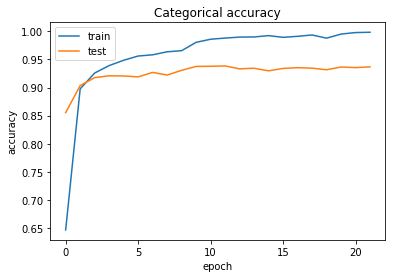

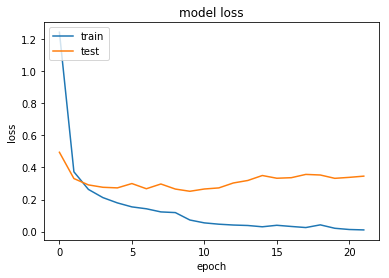

In [20]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
results.history

{'loss': [0.9235785752161404,
  0.30439105943162786,
  0.2137401657888577,
  0.16842615049108303,
  0.14617683028599204,
  0.12850053276619255,
  0.10396183432222235,
  0.09925992061549746,
  0.08382987901994393,
  0.048428719682618394,
  0.03409870768265413,
  0.030820204871312047,
  0.03521614931870639,
  0.021686181359589062,
  0.0237924152790132,
  0.018530239502858575,
  0.01988488370144002,
  0.0168656724344326,
  0.012147446359768653,
  0.007729619742905496,
  0.007117658434889789,
  0.005043832773420567,
  0.004326418976064163],
 'sparse_categorical_accuracy': [0.7402098997493735,
  0.9145324248120301,
  0.939516760651629,
  0.9513627819548872,
  0.9575109649122807,
  0.9631500626566416,
  0.9692982456140351,
  0.9709038220551378,
  0.9757205513784462,
  0.9870966478696742,
  0.990953947368421,
  0.9919916979949874,
  0.9900336779448622,
  0.994732926065163,
  0.9937734962406015,
  0.9952615914786967,
  0.995046209273183,
  0.9955748746867168,
  0.9972000313283208,
  0.99845316

In [15]:
#load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [54]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [55]:
valEval = model.evaluate_generator(valGen, use_multiprocessing=True, workers=4,verbose=1)
trainEval = model.evaluate_generator(trainGen, use_multiprocessing=True, workers=4,verbose=1)
testEval = model.evaluate(x_test, y_test, verbose=1)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

106/106 [==============================] - ETA: 21:2 - ETA: 12:0 - ETA: 8:4 - ETA: 7: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 56 - ETA: 54 - ETA: 52 - ETA: 50 - ETA: 48 - ETA: 46 - ETA: 44 - ETA: 43 - ETA: 41 - ETA: 39 - ETA: 37 - ETA: 35 - ETA: 33 - ETA: 32 - ETA: 30 - ETA: 28 - ETA: 26 - ETA: 24 - ETA: 23 - ETA: 21 - ETA: 19 - E

722/798 [==========================>...] - ETA: 2:53:5 - ETA: 1:39:3 - ETA: 1:14:3 - ETA: 1:01:5 - ETA: 54:19  - ETA: 49:4 - ETA: 46:2 - ETA: 44:0 - ETA: 42:0 - ETA: 40:1 - ETA: 38:4 - ETA: 37:2 - ETA: 36:3 - ETA: 35:4 - ETA: 34:4 - ETA: 34:1 - ETA: 33:2 - ETA: 32:4 - ETA: 32:1 - ETA: 31:4 - ETA: 31:1 - ETA: 30:4 - ETA: 30:1 - ETA: 29:5 - ETA: 29:3 - ETA: 29:1 - ETA: 28:5 - ETA: 28:4 - ETA: 28:2 - ETA: 28:1 - ETA: 27:5 - ETA: 27:4 - ETA: 27:2 - ETA: 27:1 - ETA: 27:0 - ETA: 26:5 - ETA: 26:4 - ETA: 26:3 - ETA: 26:2 - ETA: 26:1 - ETA: 26:0 - ETA: 26:0 - ETA: 25:5 - ETA: 25:4 - ETA: 25:3 - ETA: 25:3 - ETA: 25:2 - ETA: 25:1 - ETA: 25:1 - ETA: 25:0 - ETA: 24:5 - ETA: 24:5 - ETA: 24:4 - ETA: 24:3 - ETA: 24:3 - ETA: 24:2 - ETA: 24:1 - ETA: 24:1 - ETA: 24:0 - ETA: 24:0 - ETA: 23:5 - ETA: 23:5 - ETA: 23:4 - ETA: 23:4 - ETA: 23:3 - ETA: 23:3 - ETA: 23:2 - ETA: 23:2 - ETA: 23:1 - ETA: 23:1 - ETA: 23:0 - ETA: 23:0 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:4 - ETA: 22:4 - ETA: 22:3 - ETA: 22:3 -

6835/6835 [==============================] - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 

In [58]:
# save results from testing evaluation
import json
with open('My_GRU_Model/GRU_test_results.json', 'w') as file :
    test_res = {'valEval' : dict(zip(['loss', 'accuracy'], valEval)), 
                'trainEval' : dict(zip(['loss', 'accuracy'], trainEval)), 
                'testEval' : dict(zip(['loss', 'accuracy'], testEval))}
    json.dump(test_res, file)

In [27]:
#only for the Kaggle competition, 12-cmd
x_testR, y_testR = testRGen.__getitem__(0)
testREval = model.evaluate(x_testR, y_testR, verbose=1)
testREval

3081/3081 [==============================] - 4s 1ms/step


[0.27773856560475046, 0.9282700421940928]

In [0]:
testREval = model.evaluate_generator(testRGen, use_multiprocessing=True, workers=4,verbose=1)
testREval

76/76 [==============================] - 5s 66ms/step


[0.37633738776170694, 0.9420230263157895]

# Evaluation and Attention Plots

In [59]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [60]:
audios, classes = valGen.__getitem__(3)
classes

array([35, 24, 29, 23, 31, 14, 20, 16, 17, 23,  6,  1, 20, 15,  9, 32,  4,
        8,  7,  3,  9, 33,  2, 17, 10, 13, 17, 32, 11, 16,  8,  3, 11,  9,
        6, 22,  8, 11,  2,  2,  4,  5,  5, 19, 20, 12, 13,  1, 14,  3,  7,
       35,  5,  3,  7, 24,  8, 32, 19,  9, 18,  1, 28, 10])

In [67]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

17

In [68]:
outs, attW, specs = attSpeechModel.predict( audios )

In [69]:
np.argmax(outs,axis=1)

array([35, 25, 29, 23, 31, 14, 20, 16, 17, 23,  6,  1, 20, 15,  9, 32,  4,
        8,  7,  3,  9, 33,  2, 17, 10, 13, 17, 32, 11, 16,  4,  3, 11,  9,
        3, 22,  8, 11,  2,  2,  4,  5,  5, 19, 20, 12, 13,  1, 14,  3,  7,
       35,  5,  3,  7, 24,  8, 32, 19,  9, 18,  1, 28, 10], dtype=int64)

In [70]:
specs.shape

(64, 80, 125, 1)

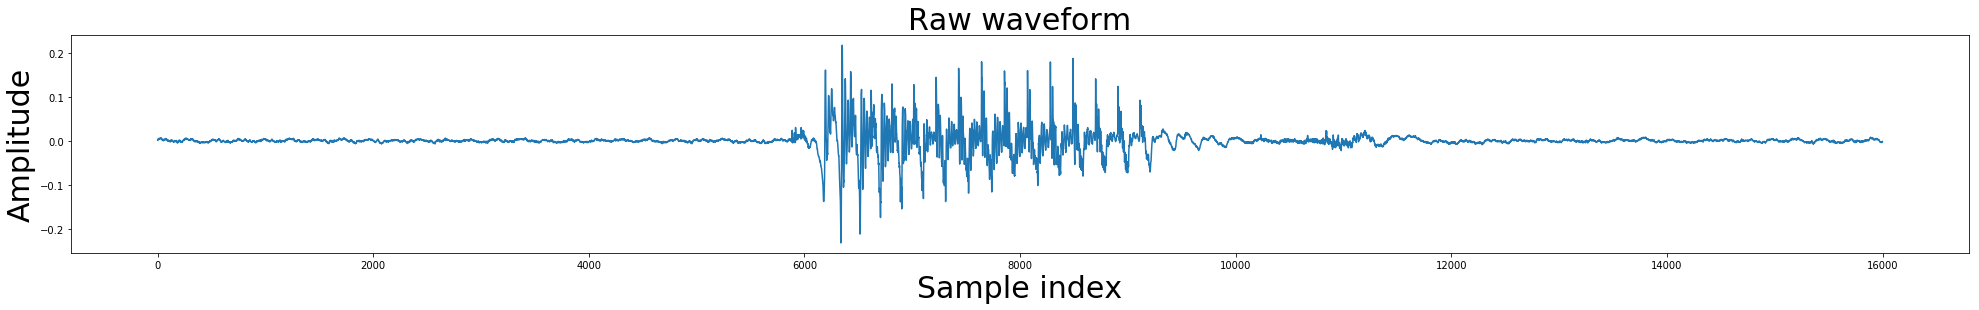

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


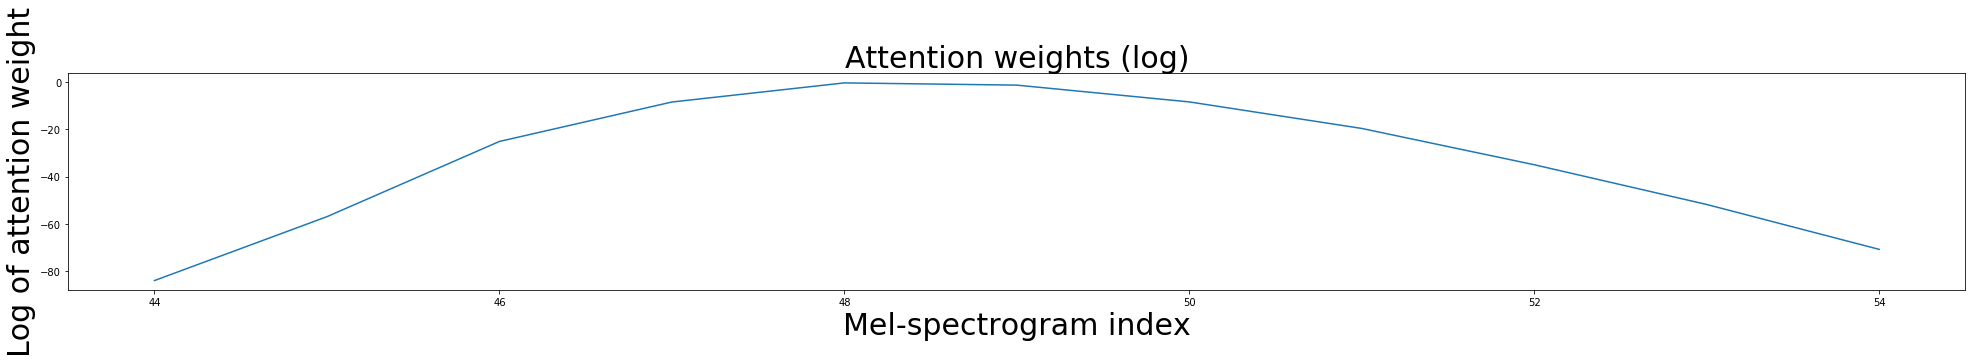

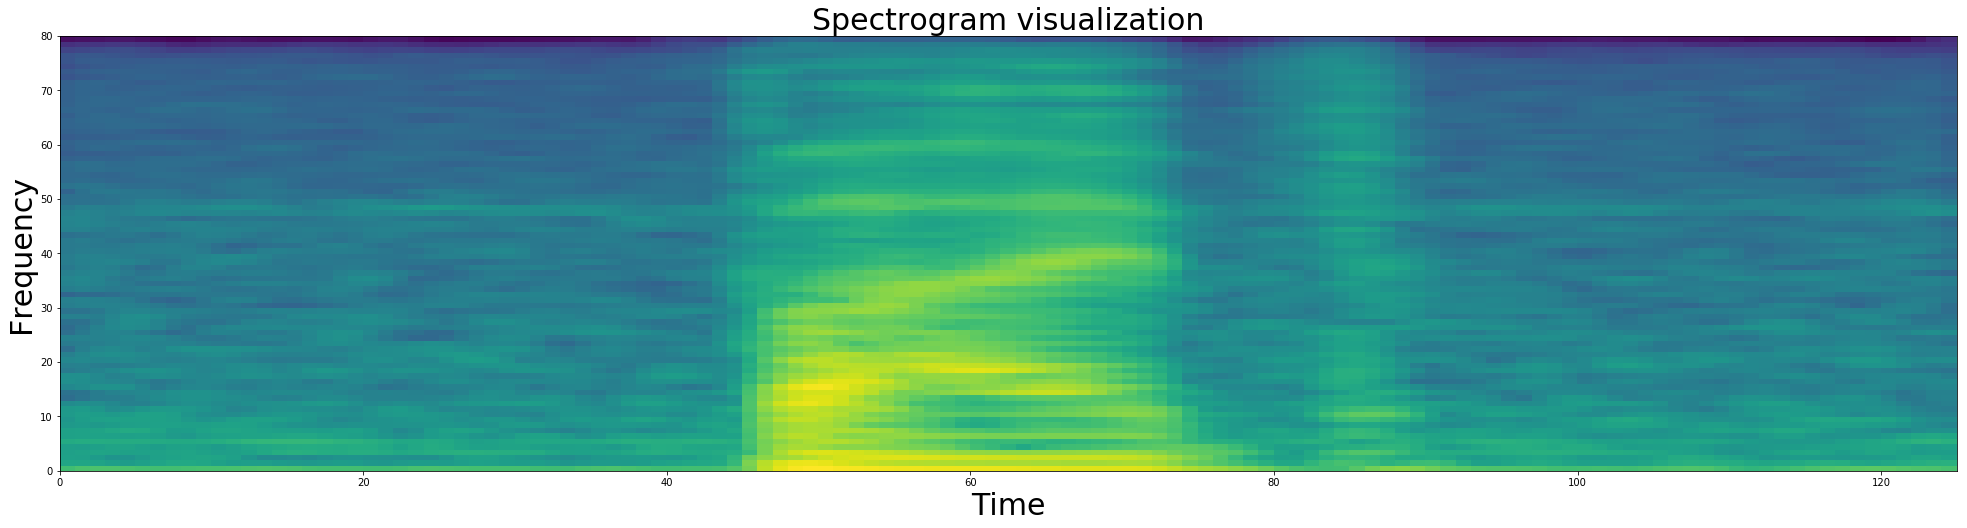

In [71]:

imgHeight = 2*2

plt.figure(figsize=(17*2,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
#plt.savefig('My_GRU_Model/picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17*2,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
#plt.savefig('My_GRU_Model/picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17*2,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
#plt.savefig('My_GRU_Model/picmelSpec.png', dpi = 400)

plt.show()

In [72]:
y_pred = model.predict(x_test, verbose=1)

6835/6835 [==============================] - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 

In [73]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [74]:
set(y_test)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 28,
 29,
 31,
 32,
 33,
 35}

In [75]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [76]:
#35word, v1
classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
         'marvin', 'sheila', 'tree', 'wow']

In [31]:
#20cmd
classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Normalized confusion matrix


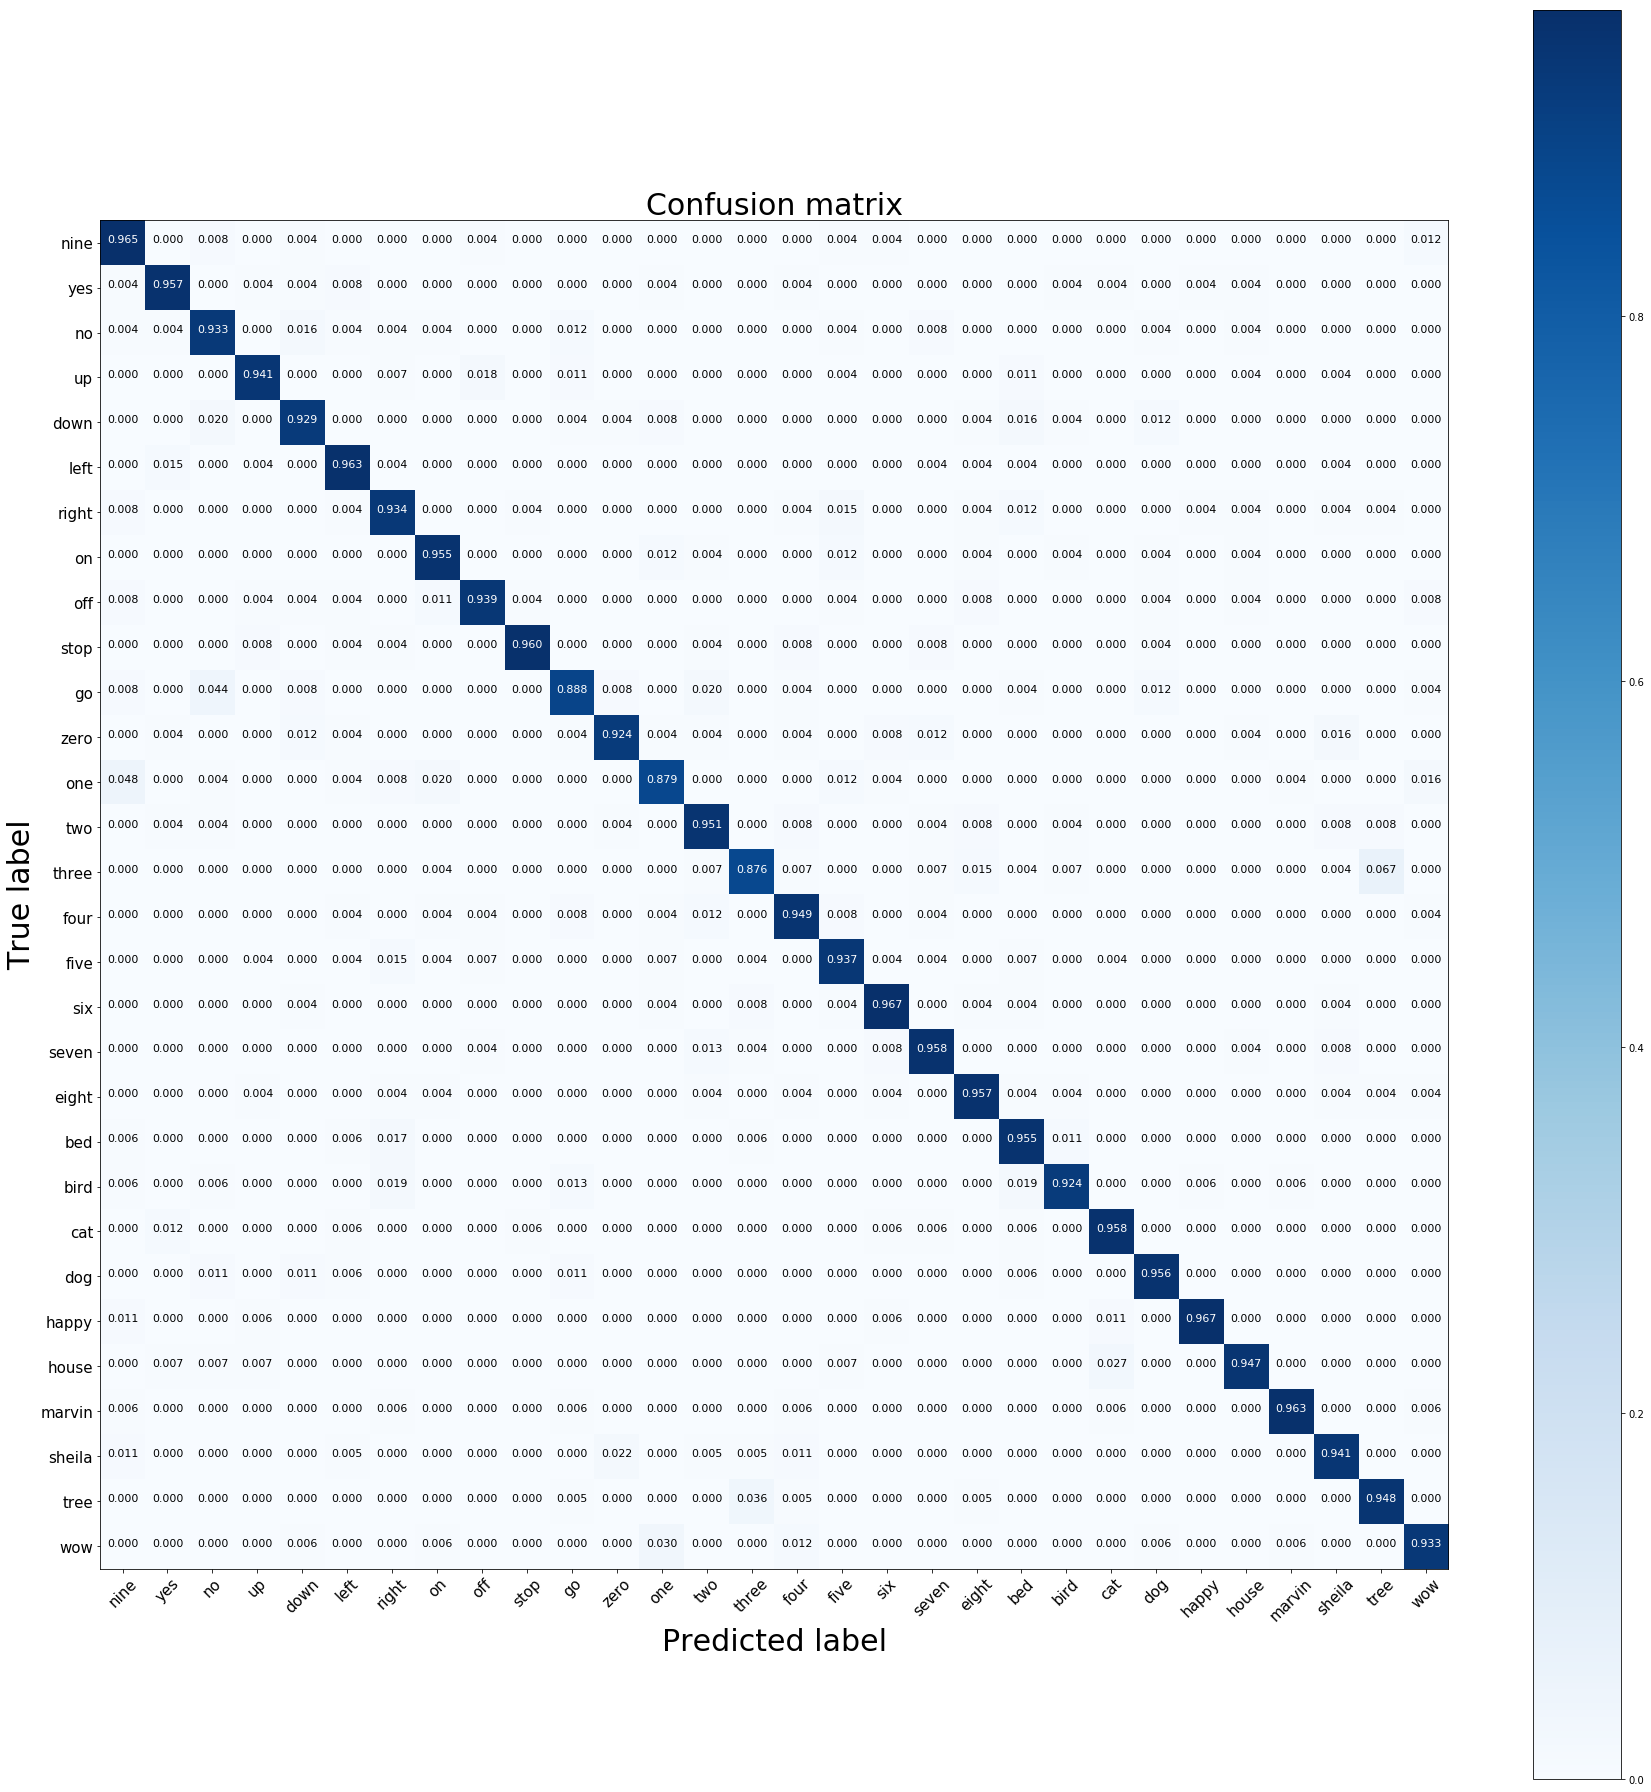

In [78]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=True)